# Analise de aluguel de imoveis São Paulo


## Importando Libs


In [7]:
import pandas as pd
import time
import numpy as np
import joblib
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

## Carregamento dos Dataset


In [8]:
df = pd.read_csv('dados/data.csv')
df.head()

address      district  area  bedrooms  garage  \
0          Rua Herval    Belenzinho    21         1       0   
1  Avenida São Miguel  Vila Marieta    15         1       1   
2    Rua Oscar Freire     Pinheiros    18         1       0   
3    Rua Júlio Sayago       Vila Ré    56         2       2   
4  Rua Barata Ribeiro    Bela Vista    19         1       0   

                 type  rent  total  
0     Studio e kitnet  2400   2939  
1     Studio e kitnet  1030   1345  
2         Apartamento  4000   4661  
3  Casa em condomínio  1750   1954  
4     Studio e kitnet  4000   4654

## Analise de Dados


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB


In [10]:
df.describe()

area      bedrooms        garage          rent         total
count  11657.000000  11657.000000  11657.000000  11657.000000  11657.000000
mean      84.655658      1.966286      1.060393   3250.814789   4080.030625
std       74.020536      0.931313      1.132349   2650.711557   3352.480274
min        0.000000      0.000000      0.000000    500.000000    509.000000
25%       40.000000      1.000000      0.000000   1590.000000   1996.000000
50%       60.000000      2.000000      1.000000   2415.000000   3057.000000
75%       96.000000      3.000000      2.000000   3800.000000   4774.000000
max      580.000000      6.000000      6.000000  25000.000000  28700.000000

In [11]:
df.isnull().sum()

address     0
district    0
area        0
bedrooms    0
garage      0
type        0
rent        0
total       0
dtype: int64

## Visualização de Dados


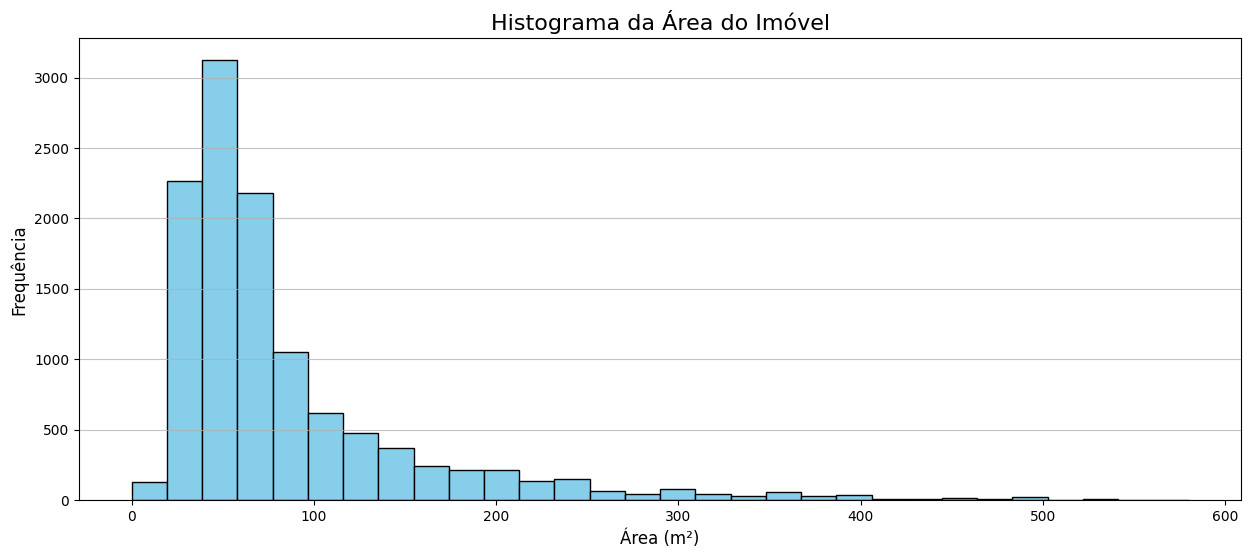

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.hist(df.area, bins=30, color='skyblue', edgecolor='black')
ax.set_title('Histograma da Área do Imóvel', fontsize=16)
ax.set_xlabel('Área (m²)', fontsize=12)
ax.set_ylabel('Frequência', fontsize=12)
ax.grid(axis='y', alpha=0.75)

count    11657.000000
mean        84.655658
std         74.020536
min          0.000000
25%         40.000000
50%         60.000000
75%         96.000000
max        580.000000
Name: area, dtype: float64

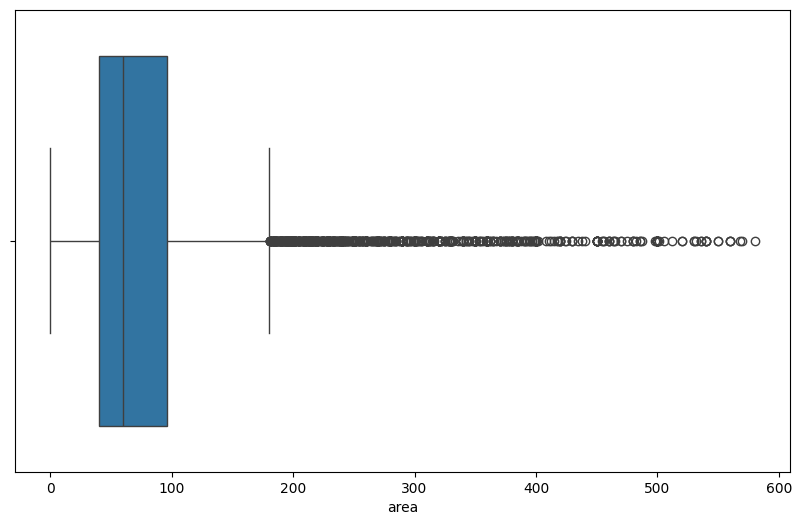

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])
df.area.describe()

### Correlação entre os dados

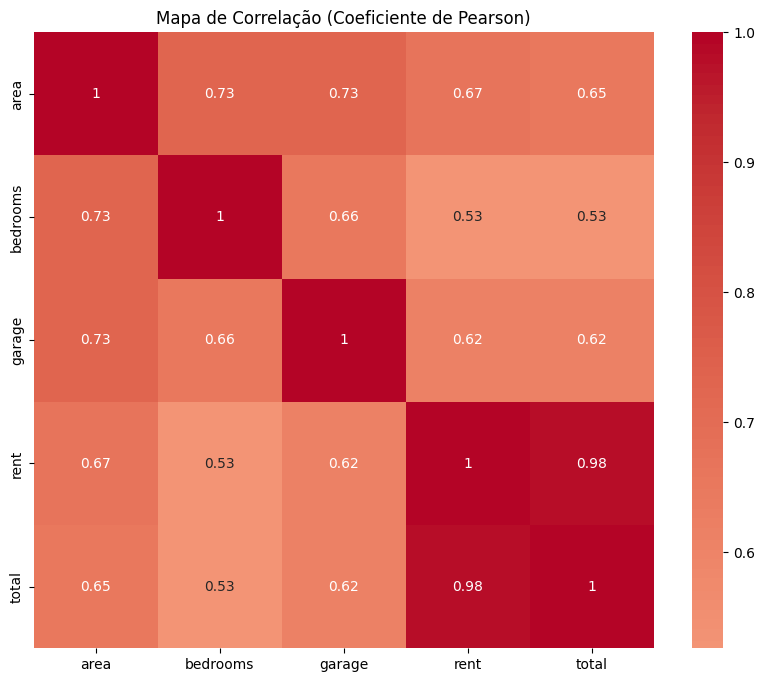

In [14]:
numeric_cols = df.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()

#### Area com menor valor de aluguel


In [15]:
df[df.rent == 500]

address                  district  area  \
51                  Rua Tanque Velho                 Vila Nivi    45   
1188           Viela Renaldo Laporta  Vila Aurora (zona Norte)    30   
4741   Rua Manoel Oliveira Gonçalves             Jardim Jaçanã    30   
5901       Rua Manuel José Rodrigues                    Sacoma    40   
6428            Rua Eugênia S Vitale                    Taboão    30   
7420       Rua Manuel José Rodrigues                    Sacoma    20   
10559  Rua Arraial de São Bartolomeu            Vila Carmosina    70   

       bedrooms  garage             type  rent  total  
51            1       0             Casa   500    551  
1188          1       0             Casa   500    521  
4741          1       0             Casa   500    509  
5901          1       0             Casa   500    521  
6428          1       0  Studio e kitnet   500    594  
7420          1       0             Casa   500    521  
10559         2       0             Casa   500    821

## Limpeza de Dados


In [16]:
# Normaliza os nomes dos bairros para padronização
df['district'] = df['district'].str.lower().str.strip()
# Mapeamento manual de variações para nomes oficiais.
# Adicione mais mapeamentos aqui conforme necessário.
mapeamento_nomes = {
    'vila aricanduva': 'Aricanduva',
    'jardim aricanduva': 'Aricanduva',
    'agua branca': 'Água Branca',
    'agua fria': 'Água Fria',
    'agua rasa': 'Água Rasa',
    'bras': 'Brás',
    'santa cecilia': 'Santa Cecília',
    'santa ifigenia': 'Santa Efigênia',
    'chacara santo antonio (zona sul)': 'Chácara Santo Antônio',
    'chacara santo antonio (zona leste)': 'Chácara Santo Antônio',
    'jardim santa cruz (campo grande)': 'Campo Grande',
    'jardim sao paulo(zona norte)': 'Jardim São Paulo',
    'parque são lucas': 'São Lucas',
    'parque da vila prudente': 'Vila Prudente',
    'vila sonia': 'Vila Sônia',
    'bosque da saude': 'Saúde',
    'vila da saude': 'Saúde',
    'jardim da saude': 'Saúde',
    'parque jabaquara': 'Jabaquara',
    'vila parque jabaquara': 'Jabaquara',
    'jardim jabaquara': 'Jabaquara',
    'jardim analia franco': 'Jardim Anália Franco',
    'vila pompéia': 'Pompéia',
    'varzea da barra funda': 'Barra Funda',
    'lapa de baixo': 'Lapa',
    'parque da lapa': 'Lapa',
    'parque residencial da lapa': 'Lapa',
    'jardim das perdizes': 'Perdizes',
    'saco ma': 'Sacomã',
    'jardim vergueiro (sacomã)': 'Sacdf[df.rent == 500]omã',
    'jardim santa cruz (sacomã)': 'Sacomã',
    'vila matiilde': 'Vila Matilde',
    'centro capital': 'Centro',
    'vila brasilandia': 'Brasilândia',
    'vila pirituba': 'Pirituba',
    'jardim cidade pirituba': 'Pirituba',
    'jardim pirituba': 'Pirituba',
    'republica': 'República',
    'jardim rio pequeno': 'Rio Pequeno',
    'parque da mooca': 'Mooca',
    'vila butanta': 'Butantã',
    'conjunto residencial butantã': 'Butantã',
    'vila brasilandia': 'Brasilândia',
    'vila butanta': 'Butantã',
    'conjunto residencial butantã': 'Butantã',
    'nossa senhora do ó': 'Freguesia do Ó',
    'nossa senhora do o': 'Freguesia do Ó',
    'penha de frança': 'Penha',
    'jardim penha': 'Penha',
    'jardim america da penha': 'Penha',
    'jardim paulistano': 'Jardim Paulista',
    'jardim peri peri': 'Jardim Peri',
    'vila são josé (ipiranga)': 'Ipiranga',
    'vila maria alta': 'Vila Maria',
    'vila maria baixa': 'Vila Maria',
    'jardim vila mariana': 'Vila Mariana',
    'panamby': 'Panamby',
    'super quadra morumbi': 'Morumbi',
    'recanto morumbi': 'Morumbi',
    'jardim parque morumbi': 'Morumbi',
    'parque bairro morumbi': 'Morumbi',
    'jardim independencia (são paulo)': 'Jardim Independência',
    'jardim panaroma (zona leste)': 'Jardim América',
    'brooklin novo': 'Brooklin',
    'brooklin paulista': 'Brooklin',
}

# Aplica o mapeamento para criar a coluna de bairro oficial
df['district'] = df['district'].apply(
    lambda x: mapeamento_nomes.get(x, x.title())
)

#### Bairros

In [17]:
bairros = df['district'].unique()
print(bairros)

['Belenzinho' 'Vila Marieta' 'Pinheiros' ... 'Vila Elvira'
 'Jardim Vitoria Regia' 'Retiro Morumbi']


### Tratando os outliers


Consideramos imóveis entre 40m² e 90m², pois refletem o padrão de apartamentos destinados à
classe média, segundo dados do mercado imobiliário.”


In [18]:
print(df.iloc[7420])
df = df[df.area >= 20]
df = df[df.area < 90]
df.describe()

address     Rua Manuel José Rodrigues
district                       Sacoma
area                               20
bedrooms                            1
garage                              0
type                             Casa
rent                              500
total                             521
Name: 7420, dtype: object


area     bedrooms       garage          rent         total
count  8276.000000  8276.000000  8276.000000   8276.000000   8276.000000
mean     50.707347     1.592073     0.639439   2313.761479   2932.239004
std      17.067264     0.644834     0.644764   1393.406429   1723.223935
min      20.000000     0.000000     0.000000    500.000000    509.000000
25%      37.000000     1.000000     0.000000   1400.000000   1747.000000
50%      50.000000     2.000000     1.000000   2000.000000   2543.000000
75%      64.000000     2.000000     1.000000   2810.000000   3652.250000
max      89.000000     4.000000     5.000000  25000.000000  26710.000000

<Axes: xlabel='area'>

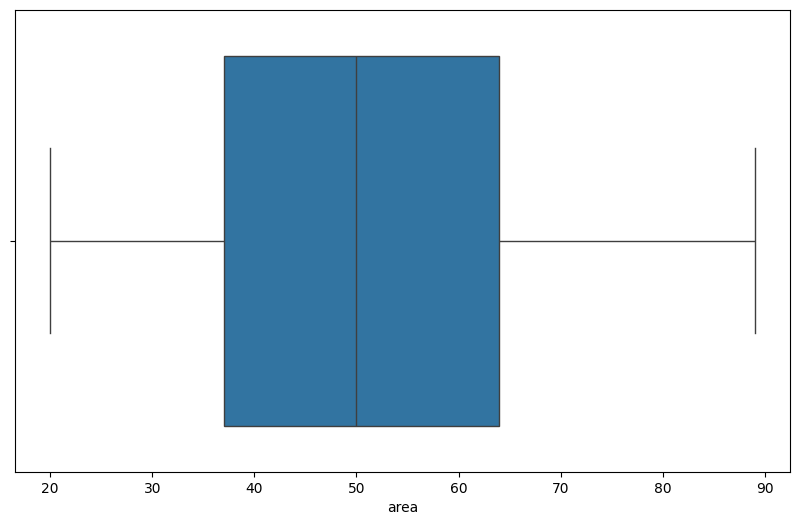

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['area'])

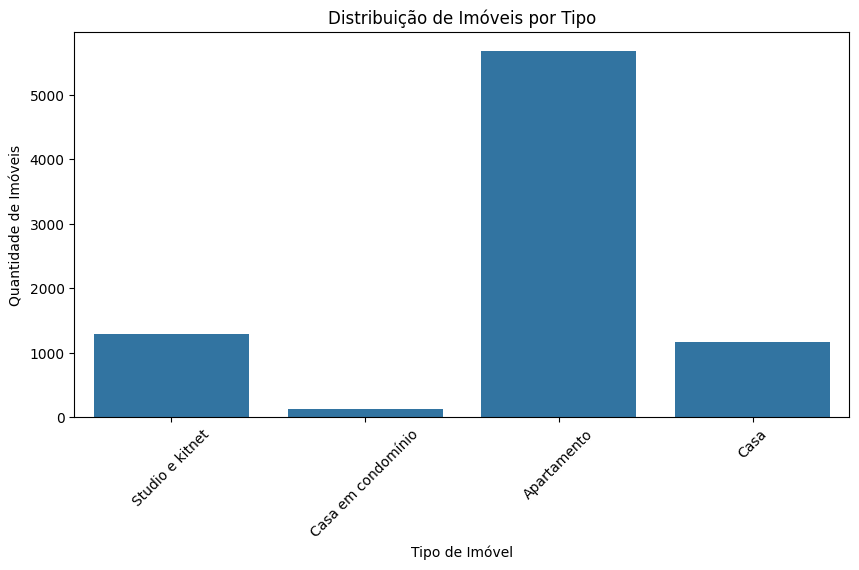

In [20]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='type')
plt.title('Distribuição de Imóveis por Tipo')
plt.xticks(rotation=45)
plt.ylabel('Quantidade de Imóveis')
plt.xlabel('Tipo de Imóvel')
plt.show()

#### Removendo imoveis sem quartos


In [21]:
df = df[df.bedrooms >= 1]
df.describe()

area     bedrooms       garage          rent         total
count  8245.000000  8245.000000  8245.000000   8245.000000   8245.000000
mean     50.769436     1.598059     0.641601   2316.470467   2935.720558
std      17.055005     0.638598     0.644833   1394.657523   1724.806960
min      20.000000     1.000000     0.000000    500.000000    509.000000
25%      37.000000     1.000000     0.000000   1400.000000   1750.000000
50%      50.000000     2.000000     1.000000   2000.000000   2545.000000
75%      64.000000     2.000000     1.000000   2820.000000   3657.000000
max      89.000000     4.000000     5.000000  25000.000000  26710.000000

## Engenharia de Features


#### Removendo features que não serão utilizadas


In [22]:
df_clean = df.drop(columns=['rent','address'])

#### Criando coluna "price_m2"


In [23]:
df_clean["price_m2"] = df_clean["total"] / df_clean["area"]
df_clean.price_m2.describe()

count    8245.000000
mean       61.374726
std        37.250008
min         9.650000
25%        37.628571
50%        51.500000
75%        74.543210
max      1112.916667
Name: price_m2, dtype: float64

#### Criando coluna "price_level"


Foi utilizado dados a partir de uma pesquisa de mercado para entender os valores do m2 de alguel em SP, assim substituimos so valores dos quartis na nossa analise para os encotrados


In [24]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Medio", "Alto", "Muito Alto"]

df_clean["price_level"] = pd.cut(
    df_clean["price_m2"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

#### Distribuição de Imoveis Preço Total


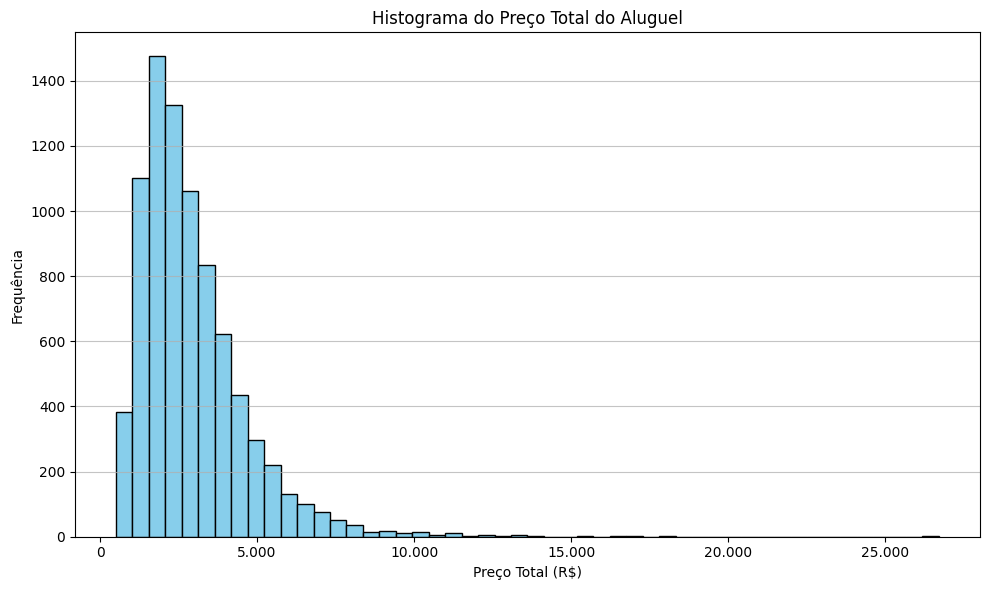

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(df_clean['total'], bins=50, color='skyblue', edgecolor='black')

ax.set_title('Histograma do Preço Total do Aluguel')
ax.set_xlabel('Preço Total (R$)')
ax.set_ylabel('Frequência')
ax.grid(axis='y', alpha=0.75)

ax.get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,.0f}".format(x).replace(",", "."))
)

plt.tight_layout()

#### Distribuição de Imoveis Preço m2


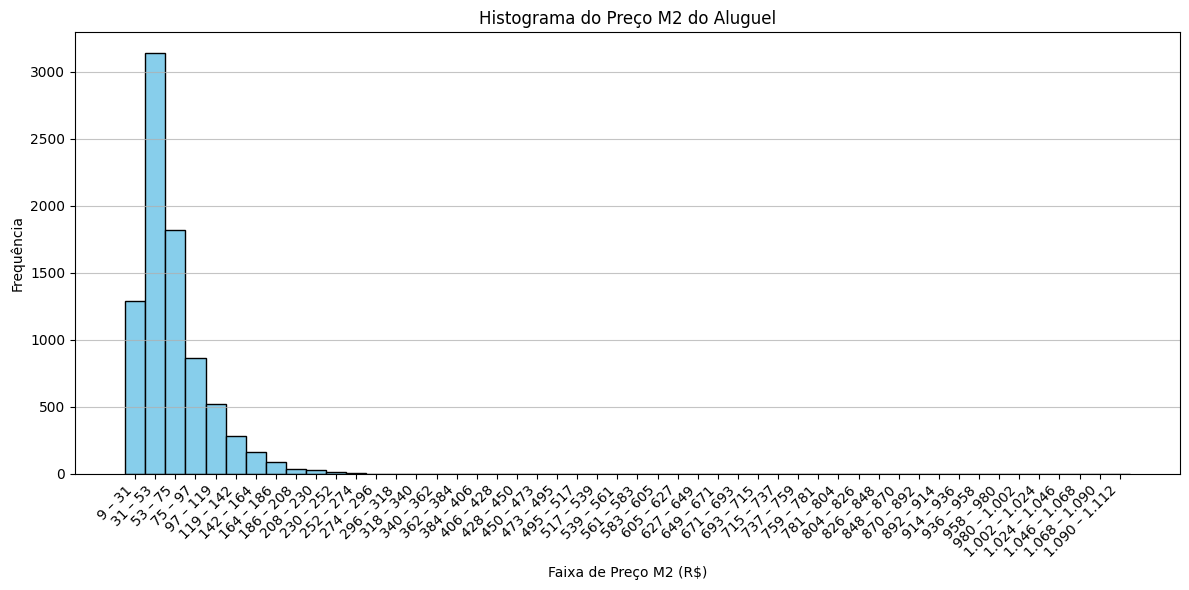

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

counts, bins, patches = ax.hist(
    df_clean['price_m2'], bins=50, color='skyblue', edgecolor='black'
)

bin_labels = [f"{int(bins[i]):,} – {int(bins[i+1]):,}".replace(",", ".")
              for i in range(len(bins)-1)]

bin_centers = (bins[:-1] + bins[1:]) / 2
ax.set_xticks(bin_centers)
ax.set_xticklabels(bin_labels, rotation=45, ha="right")

ax.set_title("Histograma do Preço M2 do Aluguel")
ax.set_xlabel("Faixa de Preço M2 (R$)")
ax.set_ylabel("Frequência")
ax.grid(axis="y", alpha=0.75)

plt.tight_layout()
plt.show()


#### Mapear bairros para cada faixa


In [27]:
bins = [9, 50, 70,90 , 1115]
labels = ["Baixo", "Médio", "Alto", "Muito Alto"]

df_clean["faixa_preco_m2"] = pd.cut(df_clean["price_m2"], bins=bins, labels=labels, include_lowest=True)

# Contagem de imóveis por distrito dentro de cada faixa
concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")

# Para cada faixa, pegar o distrito com maior concentração
top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]

top_distritos


/tmp/ipykernel_2915397/2679612559.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  concentracao = df_clean.groupby(["faixa_preco_m2", "district"]).size().reset_index(name="quantidade")
/tmp/ipykernel_2915397/2679612559.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_distritos = concentracao.loc[concentracao.groupby("faixa_preco_m2")["quantidade"].idxmax()]


faixa_preco_m2      district  quantidade
17            Baixo    Bela Vista          88
1003          Médio    Bela Vista          78
1989           Alto    Bela Vista          61
3770     Muito Alto  Vila Mariana          92

#### Distribuição Bairro e Nível de Preço


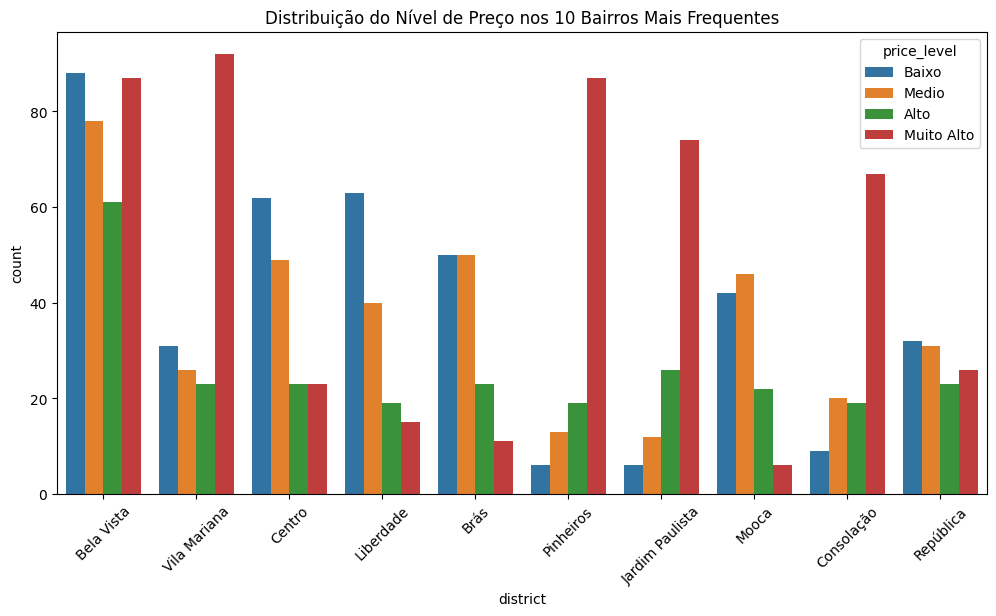

In [28]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_clean, x='district', hue='price_level', order=df_clean['district'].value_counts().iloc[:10].index)
plt.title('Distribuição do Nível de Preço nos 10 Bairros Mais Frequentes')
plt.xticks(rotation=45)
plt.show()

#### Distribuição Tipo de Imóvel e Nível de Preço


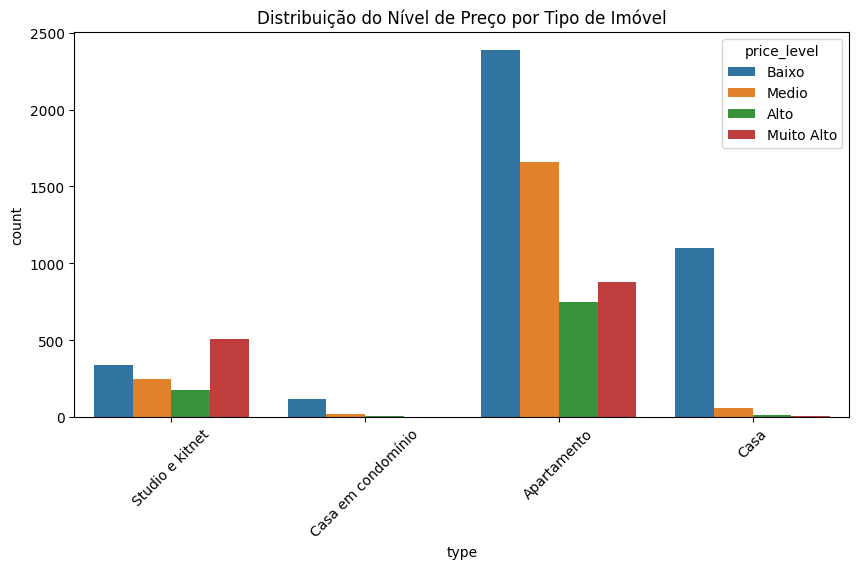

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clean, x='type', hue='price_level')
plt.title('Distribuição do Nível de Preço por Tipo de Imóvel')
plt.xticks(rotation=45)
plt.show()

### Correlação de Pearson


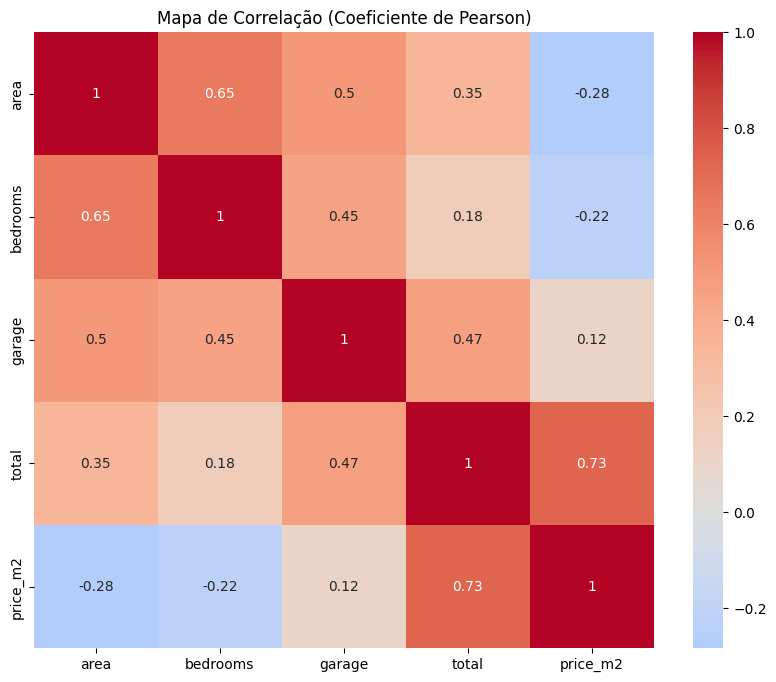

In [30]:
numeric_cols = df_clean.select_dtypes(include=["int64", "float64"])

corr = numeric_cols.corr(method="pearson")

# Plotar heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mapa de Correlação (Coeficiente de Pearson)")
plt.show()


#### Removendo linhas com NaN na feature target


In [31]:
df_clean.replace("?", np.nan, inplace=True)
df_clean = df_clean.dropna(subset=["price_level"])
df_clean

district  area  bedrooms  garage                type  \
0                   Belenzinho    21         1       0     Studio e kitnet   
3                      Vila Ré    56         2       2  Casa em condomínio   
5                         Brás    50         2       1         Apartamento   
6                     Brooklin    72         2       1         Apartamento   
7                       Centro    26         1       0     Studio e kitnet   
...                        ...   ...       ...     ...                 ...   
11638              Santo Amaro    70         2       1         Apartamento   
11640         Jardim Caravelas    78         2       1         Apartamento   
11645              Santo Amaro    70         2       0         Apartamento   
11654         Jardim Caravelas    84         1       2         Apartamento   
11655  Jardim Fonte Do Morumbi    76         1       0         Apartamento   

       total    price_m2 price_level faixa_preco_m2  
0       2939  139.952381  Muito Alto     Muito Alto  
3       1954   34.892857       Baixo          Baixo  
5       4587   91.740000  Muito Alto     Muito Alto  
6       5187   72.041667        Alto           Alto  
7       2244   86.307692        Alto           Alto  
...      ...         ...         ...            ...  
11638   4215   60.214286       Medio          Médio  
11640   3686   47.256410       Baixo          Baixo  
11645   3116   44.514286       Baixo          Baixo  
11654   5467   65.083333       Medio          Médio  
11655  10200  134.210526  Muito Alto     Muito Alto  

[8245 rows x 9 columns]

#### Distribuição Imoveis por Price_level


price_level
Baixo         3936
Medio         1981
Muito Alto    1390
Alto           938
Name: count, dtype: int64


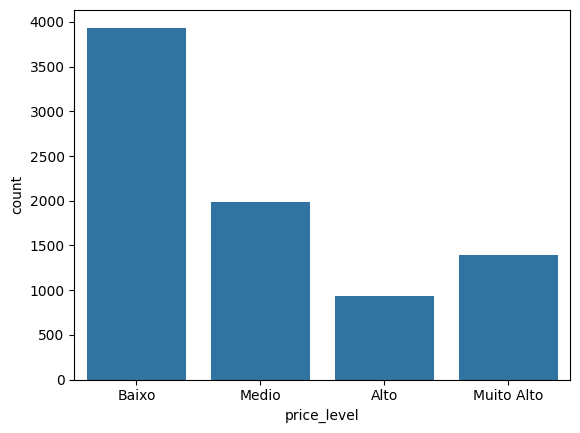

In [32]:
sns.countplot(x = df_clean['price_level'])
print(df_clean["price_level"].value_counts())

## Separação de Dados e Treinamento


#### Divisão entre previsores (X) e classe (y)


In [33]:
target = "price_level"
X = df_clean.drop(columns=[target, 'price_m2', 'total','faixa_preco_m2'])
y = df_clean[target]

print("Features utilizadas para o treinamento:", X.columns.tolist())

Features utilizadas para o treinamento: ['district', 'area', 'bedrooms', 'garage', 'type']


#### Separando variaveis entre numericas e categoricas


In [34]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [35]:
num_features

['area', 'bedrooms', 'garage']

In [36]:
cat_features

['district', 'type']

#### Escalonamento dos valores e Codificação de variáveis categóricas


In [37]:
ohe_enc = OneHotEncoder(sparse_output=False)
scaler_std = StandardScaler()

X_num_std = scaler_std.fit_transform(df[num_features])
X_nom = ohe_enc.fit_transform(df[cat_features]) if cat_features else np.empty((len(df),0))

X_final = np.hstack([X_num_std, X_nom])
X_final

array([[-1.74560142, -0.93657557, -0.99504865, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.30670651,  0.62944868,  2.10671926, ...,  0.        ,
         1.        ,  0.        ],
       [-0.0451177 ,  0.62944868,  0.5558353 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12762969,  0.62944868, -0.99504865, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.94855286, -0.93657557,  2.10671926, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.47945391, -0.93657557, -0.99504865, ...,  0.        ,
         0.        ,  0.        ]], shape=(8245, 993))

In [38]:
import joblib

joblib.dump(scaler_std, "dados/scaler_std.pkl")
joblib.dump(ohe_enc, "dados/ohe_enc.pkl")

['dados/ohe_enc.pkl']

#### Divisão da Base em treinamento, teste


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

#### Transformer para converter sparse -> dense (para Naive Bayes)


In [40]:
from sklearn.base import BaseEstimator, TransformerMixin
class DenseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X_final, y=None):
        return self
    def transform(self, X_final, y=None):
        return X_final.toarray()

#### Configurando modelos


In [41]:
models_default = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "NeuralNetwork": MLPClassifier(),
    "NaiveBayes": GaussianNB()
}

#### Configurando Parametros

In [42]:
param_grids = {
    "LogisticRegression": {
        'C': [0.1, 1.0, 10.0],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [500, 1000]
    },
    "RandomForest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    "DecisionTree": {
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    "NeuralNetwork": {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001]
    }
}

In [43]:
resultados = []

#### Configurando treinamento

In [44]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

resultados_global = [] 

def treinar_modelos(balanceamento=None, usar_pca=False, tipo_parametros='default', salvar_parametros=True):

    resultados = []
    models_best_parameters = {}

    # Variáveis para armazenar o melhor modelo
    melhor_pipeline = None
    nome_melhor_modelo = ""
    melhor_score = 0.0
    # Aplicar balanceamento, se necessário
    if balanceamento == "SMOTE":
        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    elif balanceamento == "TomekLinks":
        tml = TomekLinks()
        X_train_bal, y_train_bal = tml.fit_resample(X_train, y_train)
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Aplicar PCA, se necessário
    if usar_pca:
        pca = PCA(n_components=100)
        X_train_bal = pca.fit_transform(X_train_bal)
        X_test_pca = pca.transform(X_test)
    else:
        X_test_pca = X_test

    # Loop para treinar os modelos
    for name, model in models_default.items():
        param_file = f"/content/dados/parametros_{name}.pkl"
        if os.path.exists(param_file):
            models_best_parameters[name] = joblib.load(param_file)

        descricao_cenario = (
            f"{name} | Balanceamento: {balanceamento if balanceamento else 'Nenhum'} "
            f"| PCA: {'Sim' if usar_pca else 'Não'} | Parametros: {tipo_parametros}"
        )

        print(f"\n==================== {name} ====================")

        # Condicional para NaiveBayes (sem GridSearch)
        if tipo_parametros == "default" or name == "NaiveBayes":
            grid_search = model
        elif tipo_parametros == "grid":
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=5,
                n_jobs=-1,
                scoring='accuracy',
                verbose=1
            )
        elif tipo_parametros == "best":
            if name in models_best_parameters:
                grid_search = model.set_params(**models_best_parameters[name])
            else:
                print(f"Atenção ⚠️: Não encontrei parâmetros salvos para {name}, usando default.")
                grid_search = model

        # Treinamento com medição de tempo
        inicio = time.time()
        grid_search.fit(X_train_bal, y_train_bal)
        fim = time.time()
        tempo_treino = fim - inicio

        # Previsões
        y_pred_test = grid_search.predict(X_test_pca)
        acc_test = accuracy_score(y_test, y_pred_test)

        # Atualizar melhor modelo
        if acc_test > melhor_score:
            print(f"✨ Novo melhor modelo encontrado: {descricao_cenario} com acurácia de {acc_test:.4f}!")
            melhor_score = acc_test
            melhor_pipeline = grid_search
            nome_melhor_modelo = name

        # Classes dinâmicas
        classes = unique_labels(y_test, y_pred_test)
        target_names = [f"Classe {c}" for c in classes]

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred_test, labels=classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confusão - {descricao_cenario}')
        plt.show()

        # Relatório de classificação
        print(f"\nRelatório de Classificação para {descricao_cenario}:")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")

        # Salvar resultados
        if name != "NaiveBayes":
            if tipo_parametros == "grid":
                best_params = grid_search.best_params_
                print(f"📌 Melhores parâmetros encontrados para {name}:")
                print(grid_search.best_params_)
            elif tipo_parametros == "best":
                best_params = models_best_parameters.get(name, "N/A")
            else:
                best_params = "N/A"

            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": best_params
            })

            # Salvar parâmetros apenas se for grid
            if salvar_parametros and tipo_parametros == "grid":
                joblib.dump(grid_search.best_params_, f'dados/parametros_{name}.pkl')
        else:
            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": "N/A"
            })

        print("=" * 52)

    # Comparação final
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="Acurácia Teste", ascending=False))

    resultados_global.extend(resultados)

    # Salvar o melhor modelo
    joblib.dump(melhor_pipeline, f'dados/{nome_melhor_modelo}_melhor_modelo.pkl')
    print(f"✨ Melhor modelo salvo: {nome_melhor_modelo} com acurácia de {melhor_score:.4f}!")

    # RETORNA o melhor modelo treinado
    return melhor_pipeline



==================== LogisticRegression ====================
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: default com acurácia de 0.6531!


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


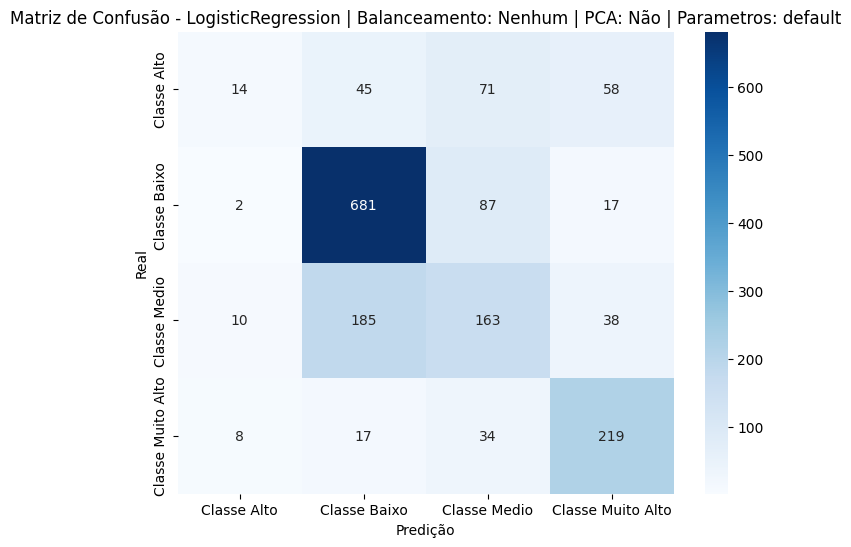


Relatório de Classificação para LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.07      0.13       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.79      0.72       278

         accuracy                           0.65      1649
        macro avg       0.57      0.53      0.52      1649
     weighted avg       0.62      0.65      0.62      1649

Tempo de treinamento: 0.8920 segundos

==================== RandomForest ====================


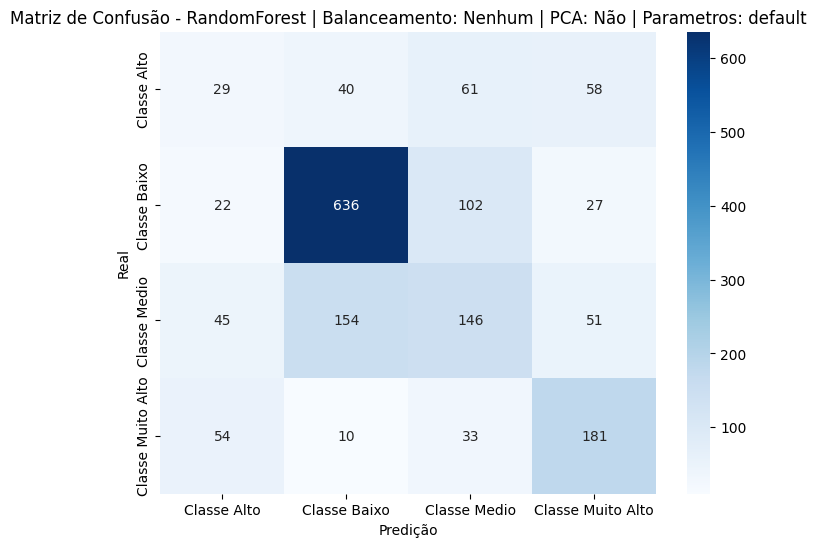


Relatório de Classificação para RandomForest | Balanceamento: Nenhum | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.19      0.15      0.17       188
     Classe Baixo       0.76      0.81      0.78       787
     Classe Medio       0.43      0.37      0.40       396
Classe Muito Alto       0.57      0.65      0.61       278

         accuracy                           0.60      1649
        macro avg       0.49      0.50      0.49      1649
     weighted avg       0.58      0.60      0.59      1649

Tempo de treinamento: 3.6148 segundos

==================== SVM ====================


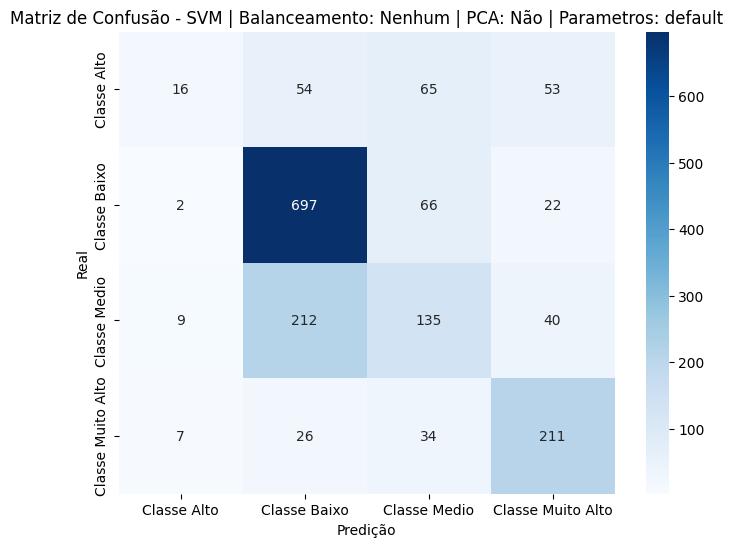


Relatório de Classificação para SVM | Balanceamento: Nenhum | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.47      0.09      0.14       188
     Classe Baixo       0.70      0.89      0.78       787
     Classe Medio       0.45      0.34      0.39       396
Classe Muito Alto       0.65      0.76      0.70       278

         accuracy                           0.64      1649
        macro avg       0.57      0.52      0.50      1649
     weighted avg       0.61      0.64      0.60      1649

Tempo de treinamento: 17.9947 segundos

==================== KNN ====================


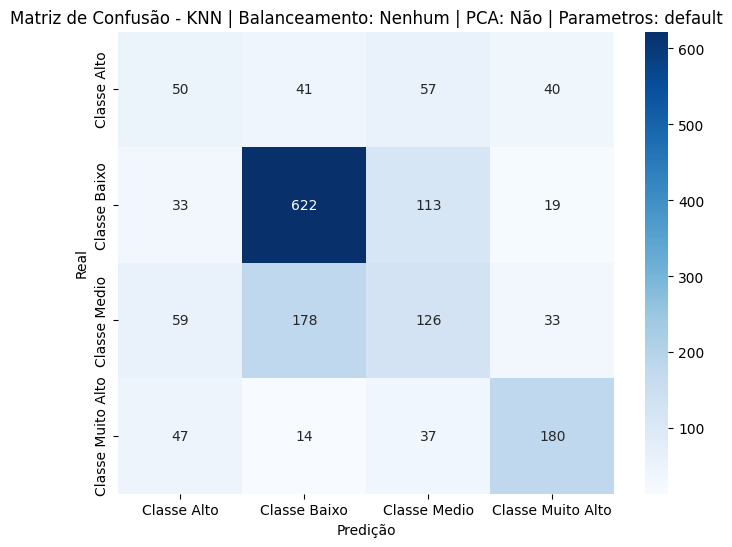


Relatório de Classificação para KNN | Balanceamento: Nenhum | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.27      0.27       188
     Classe Baixo       0.73      0.79      0.76       787
     Classe Medio       0.38      0.32      0.35       396
Classe Muito Alto       0.66      0.65      0.65       278

         accuracy                           0.59      1649
        macro avg       0.51      0.51      0.51      1649
     weighted avg       0.58      0.59      0.59      1649

Tempo de treinamento: 0.0074 segundos

==================== DecisionTree ====================


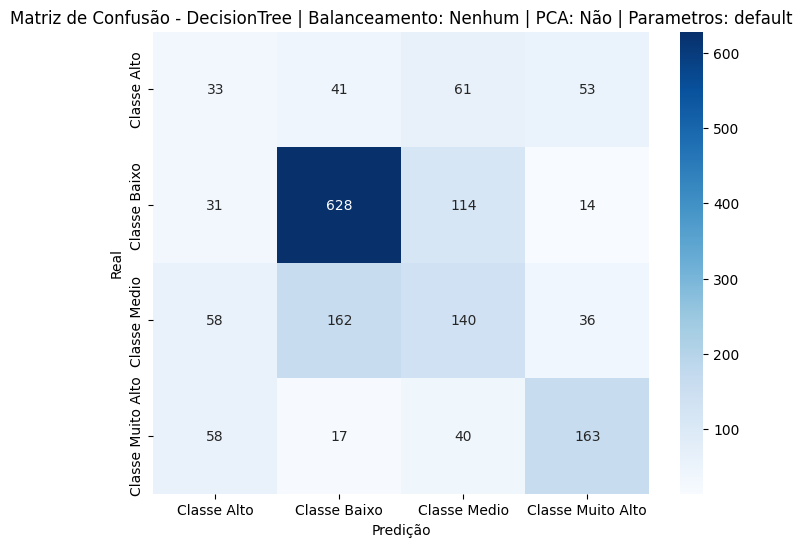


Relatório de Classificação para DecisionTree | Balanceamento: Nenhum | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.18      0.18      0.18       188
     Classe Baixo       0.74      0.80      0.77       787
     Classe Medio       0.39      0.35      0.37       396
Classe Muito Alto       0.61      0.59      0.60       278

         accuracy                           0.58      1649
        macro avg       0.48      0.48      0.48      1649
     weighted avg       0.57      0.58      0.58      1649

Tempo de treinamento: 0.4291 segundos

==================== NeuralNetwork ====================


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


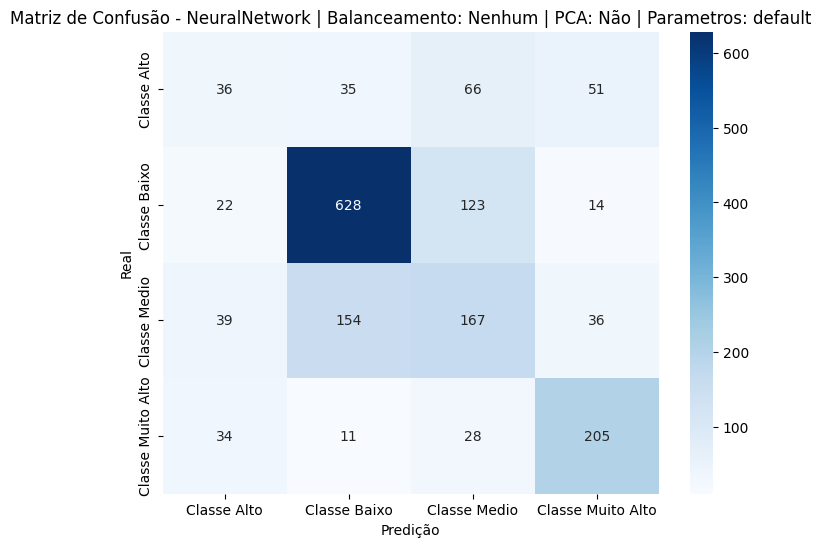


Relatório de Classificação para NeuralNetwork | Balanceamento: Nenhum | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.19      0.23       188
     Classe Baixo       0.76      0.80      0.78       787
     Classe Medio       0.43      0.42      0.43       396
Classe Muito Alto       0.67      0.74      0.70       278

         accuracy                           0.63      1649
        macro avg       0.53      0.54      0.53      1649
     weighted avg       0.61      0.63      0.62      1649

Tempo de treinamento: 19.6743 segundos

==================== NaiveBayes ====================


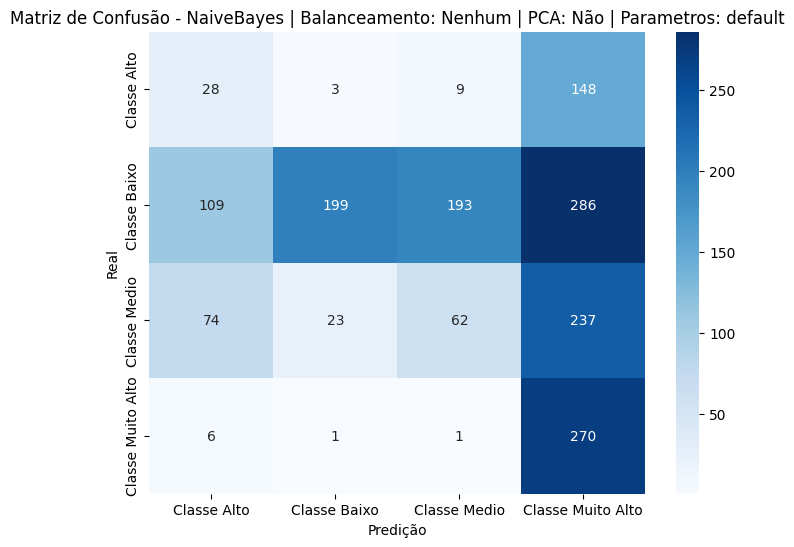


Relatório de Classificação para NaiveBayes | Balanceamento: Nenhum | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0495 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: Nenhum | P...        0.653123   
2  SVM | Balanceamento: Nenhum | PCA: Não | Param...        0.642207   
5  NeuralNetwork | Balanceamento: Nenhum | PCA: N...        0.628260   
1  RandomForest | Balanceamento: Nenhum | PCA: Nã...        0.601577   
3  KNN | Balanceamento: Nenhum | PCA: Não | Param...        0.593087   
4  DecisionTree | Balanceamento: Nenhum | PCA: Nã...        0.584597   
6  NaiveBayes | Balanceamento: Nenhum | PCA: Não ...        0.338993   

   Tempo Treinamento (s) Melhores Parâmetros  
0               0.892039                 N/A  
2              17.994667                 N/A  
5              19.674347                 N/A  
1               3.614778                 N/A  
3               0.007397                 N/A  
4               0.429140                 N/A  
6               0.049502                 N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6531!

==================== LogisticRegression ====================
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Não | Parametros: default com acurácia de 0.6531!


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


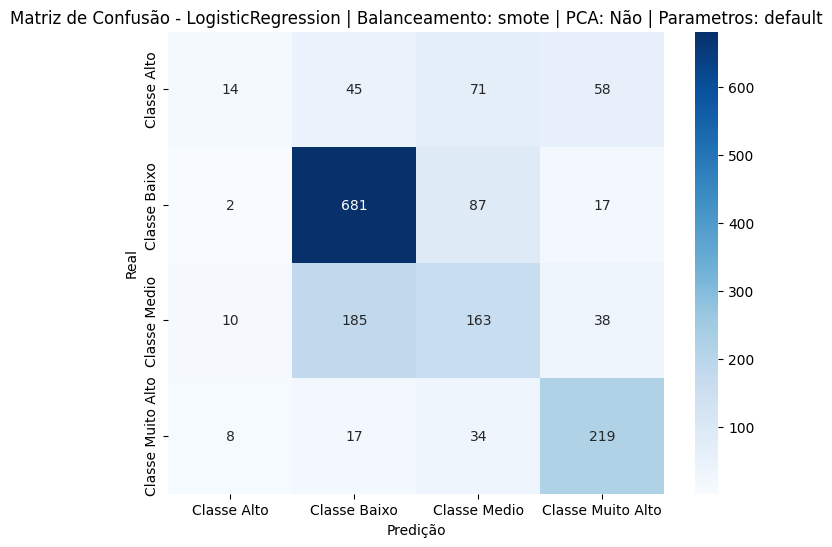


Relatório de Classificação para LogisticRegression | Balanceamento: smote | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.07      0.13       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.79      0.72       278

         accuracy                           0.65      1649
        macro avg       0.57      0.53      0.52      1649
     weighted avg       0.62      0.65      0.62      1649

Tempo de treinamento: 0.9530 segundos

==================== RandomForest ====================


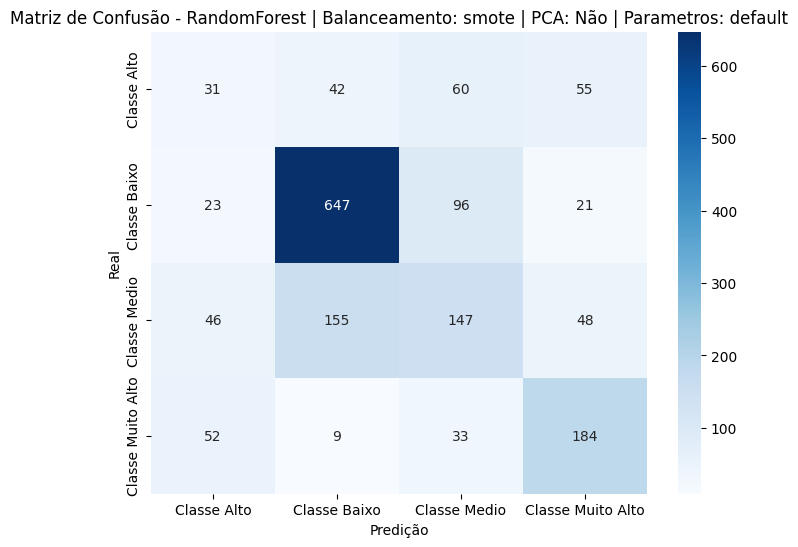


Relatório de Classificação para RandomForest | Balanceamento: smote | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.16      0.18       188
     Classe Baixo       0.76      0.82      0.79       787
     Classe Medio       0.44      0.37      0.40       396
Classe Muito Alto       0.60      0.66      0.63       278

         accuracy                           0.61      1649
        macro avg       0.50      0.51      0.50      1649
     weighted avg       0.59      0.61      0.60      1649

Tempo de treinamento: 3.7483 segundos

==================== SVM ====================


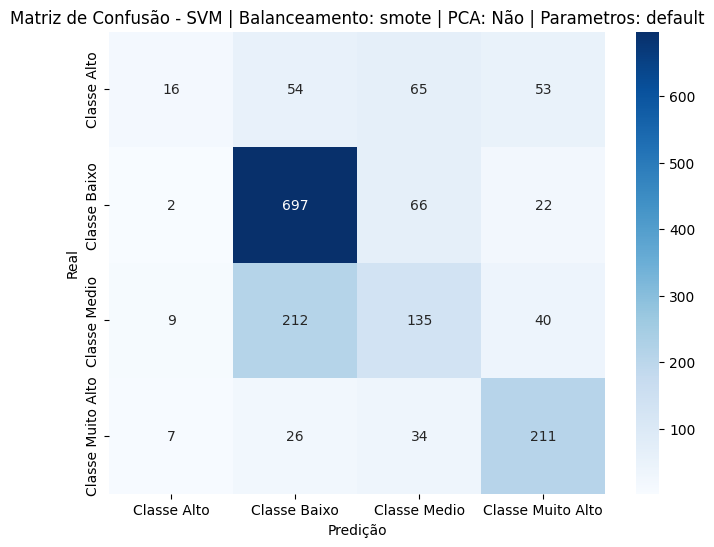


Relatório de Classificação para SVM | Balanceamento: smote | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.47      0.09      0.14       188
     Classe Baixo       0.70      0.89      0.78       787
     Classe Medio       0.45      0.34      0.39       396
Classe Muito Alto       0.65      0.76      0.70       278

         accuracy                           0.64      1649
        macro avg       0.57      0.52      0.50      1649
     weighted avg       0.61      0.64      0.60      1649

Tempo de treinamento: 17.0836 segundos

==================== KNN ====================


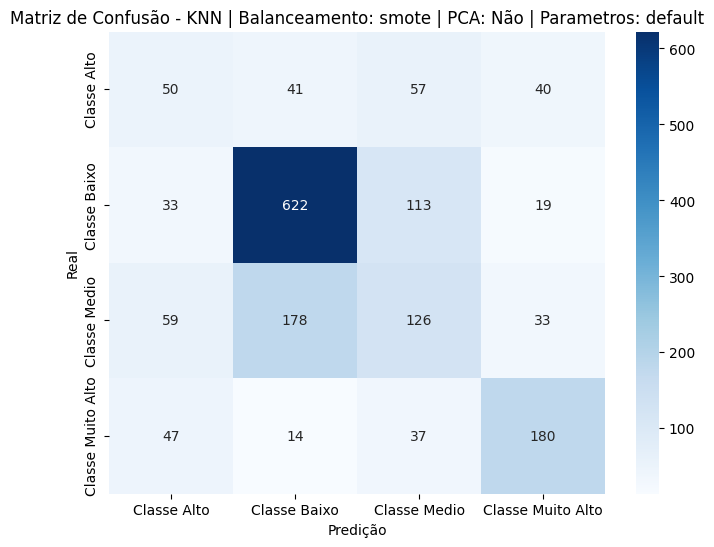


Relatório de Classificação para KNN | Balanceamento: smote | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.27      0.27       188
     Classe Baixo       0.73      0.79      0.76       787
     Classe Medio       0.38      0.32      0.35       396
Classe Muito Alto       0.66      0.65      0.65       278

         accuracy                           0.59      1649
        macro avg       0.51      0.51      0.51      1649
     weighted avg       0.58      0.59      0.59      1649

Tempo de treinamento: 0.0071 segundos

==================== DecisionTree ====================


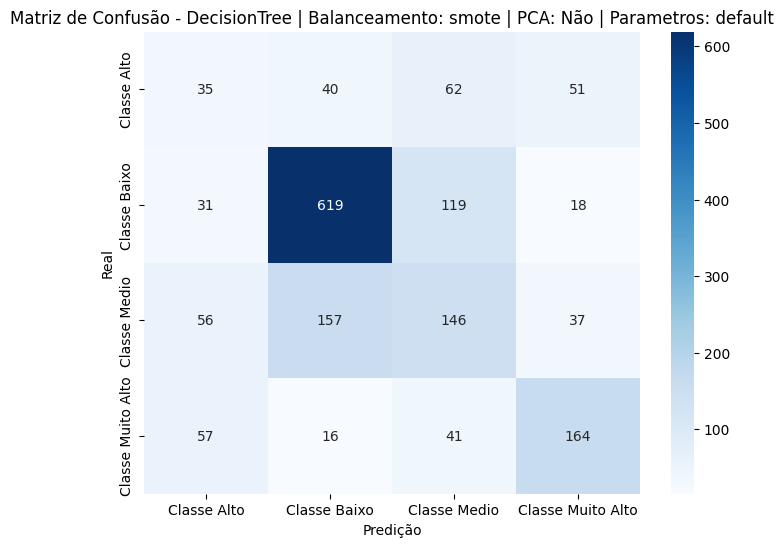


Relatório de Classificação para DecisionTree | Balanceamento: smote | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.19      0.19       188
     Classe Baixo       0.74      0.79      0.76       787
     Classe Medio       0.40      0.37      0.38       396
Classe Muito Alto       0.61      0.59      0.60       278

         accuracy                           0.58      1649
        macro avg       0.49      0.48      0.48      1649
     weighted avg       0.58      0.58      0.58      1649

Tempo de treinamento: 0.4751 segundos

==================== NeuralNetwork ====================


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


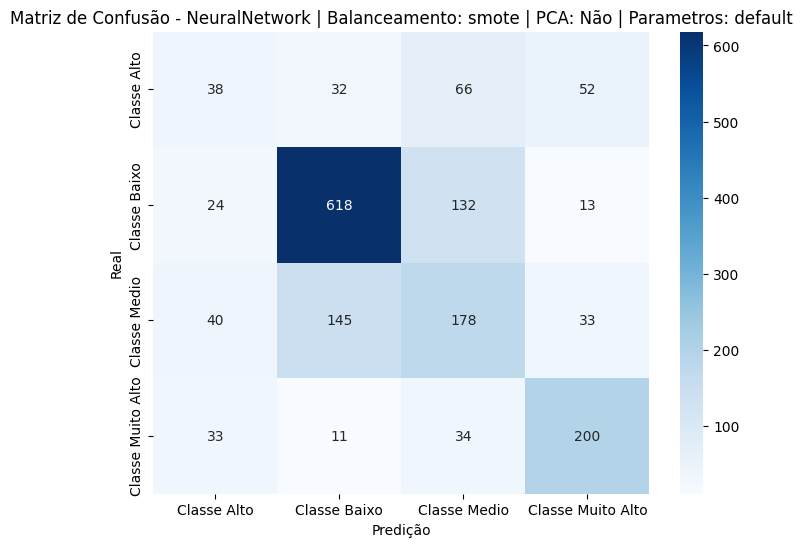


Relatório de Classificação para NeuralNetwork | Balanceamento: smote | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.28      0.20      0.24       188
     Classe Baixo       0.77      0.79      0.78       787
     Classe Medio       0.43      0.45      0.44       396
Classe Muito Alto       0.67      0.72      0.69       278

         accuracy                           0.63      1649
        macro avg       0.54      0.54      0.54      1649
     weighted avg       0.62      0.63      0.62      1649

Tempo de treinamento: 17.9423 segundos

==================== NaiveBayes ====================


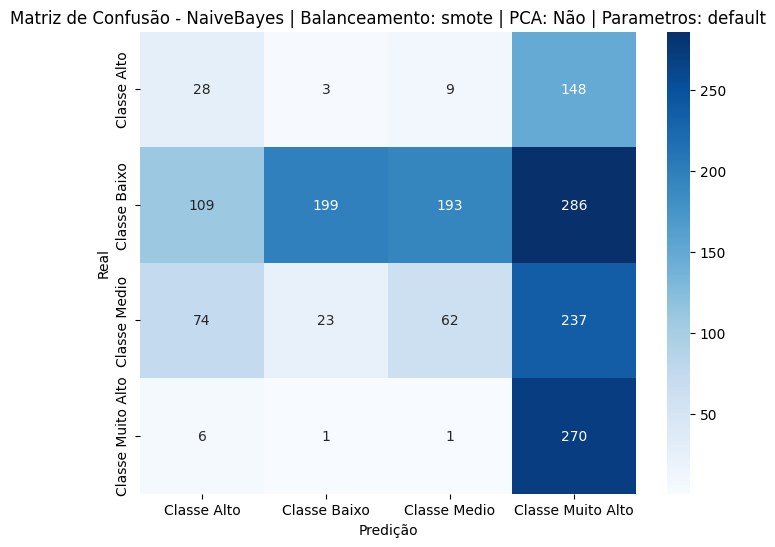


Relatório de Classificação para NaiveBayes | Balanceamento: smote | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0611 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: smote | PC...        0.653123   
2  SVM | Balanceamento: smote | PCA: Não | Parame...        0.642207   
5  NeuralNetwork | Balanceamento: smote | PCA: Nã...        0.627047   
1  RandomForest | Balanceamento: smote | PCA: Não...        0.611886   
3  KNN | Balanceamento: smote | PCA: Não | Parame...        0.593087   
4  DecisionTree | Balanceamento: smote | PCA: Não...        0.584597   
6  NaiveBayes | Balanceamento: smote | PCA: Não |...        0.338993   

   Tempo Treinamento (s) Melhores Parâmetros  
0               0.952973                 N/A  
2              17.083618                 N/A  
5              17.942344                 N/A  
1               3.748324                 N/A  
3               0.007127                 N/A  
4               0.475144                 N/A  
6               0.061093                 N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6531!

==================== LogisticRegression ====================
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Não | Parametros: default com acurácia de 0.6531!


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


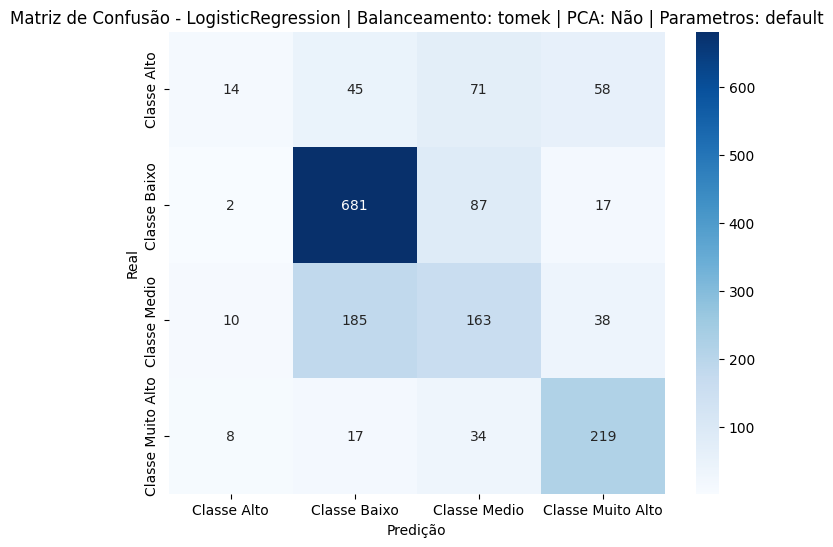


Relatório de Classificação para LogisticRegression | Balanceamento: tomek | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.41      0.07      0.13       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.79      0.72       278

         accuracy                           0.65      1649
        macro avg       0.57      0.53      0.52      1649
     weighted avg       0.62      0.65      0.62      1649

Tempo de treinamento: 0.9698 segundos

==================== RandomForest ====================


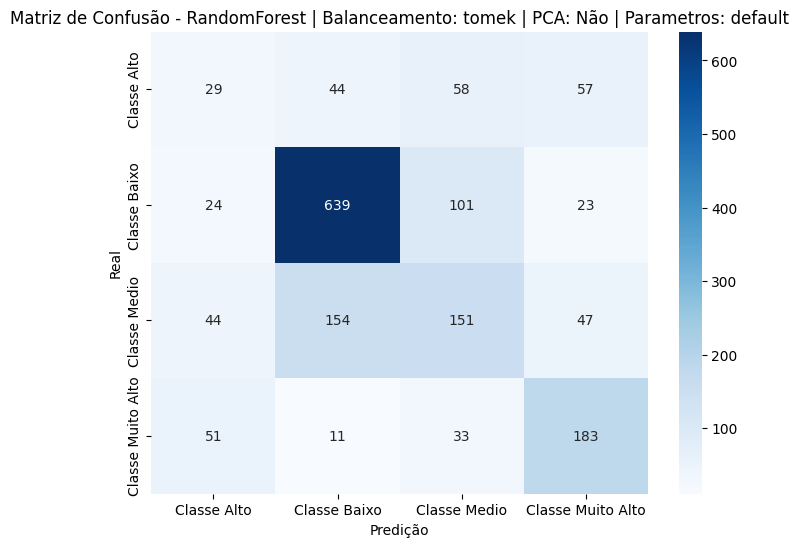


Relatório de Classificação para RandomForest | Balanceamento: tomek | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.15      0.17       188
     Classe Baixo       0.75      0.81      0.78       787
     Classe Medio       0.44      0.38      0.41       396
Classe Muito Alto       0.59      0.66      0.62       278

         accuracy                           0.61      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.61      0.60      1649

Tempo de treinamento: 4.0867 segundos

==================== SVM ====================


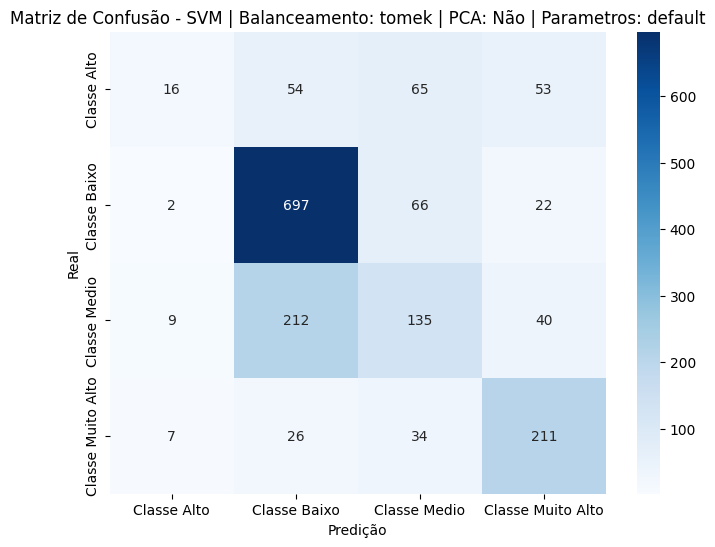


Relatório de Classificação para SVM | Balanceamento: tomek | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.47      0.09      0.14       188
     Classe Baixo       0.70      0.89      0.78       787
     Classe Medio       0.45      0.34      0.39       396
Classe Muito Alto       0.65      0.76      0.70       278

         accuracy                           0.64      1649
        macro avg       0.57      0.52      0.50      1649
     weighted avg       0.61      0.64      0.60      1649

Tempo de treinamento: 17.6133 segundos

==================== KNN ====================


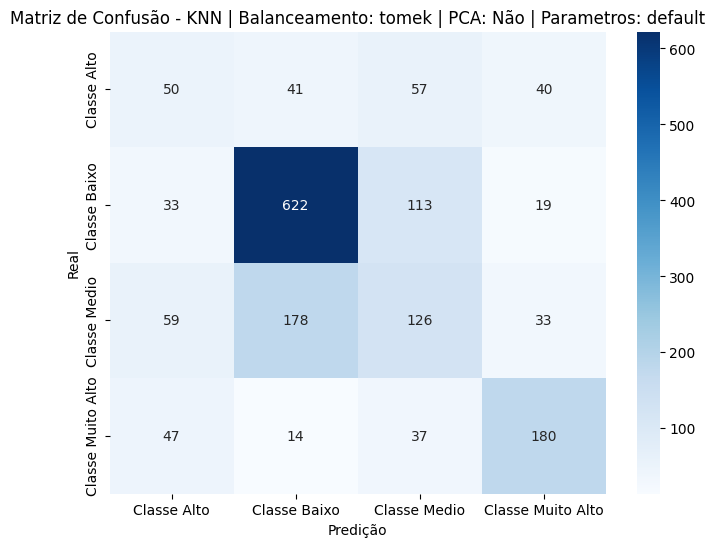


Relatório de Classificação para KNN | Balanceamento: tomek | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.27      0.27       188
     Classe Baixo       0.73      0.79      0.76       787
     Classe Medio       0.38      0.32      0.35       396
Classe Muito Alto       0.66      0.65      0.65       278

         accuracy                           0.59      1649
        macro avg       0.51      0.51      0.51      1649
     weighted avg       0.58      0.59      0.59      1649

Tempo de treinamento: 0.0071 segundos

==================== DecisionTree ====================


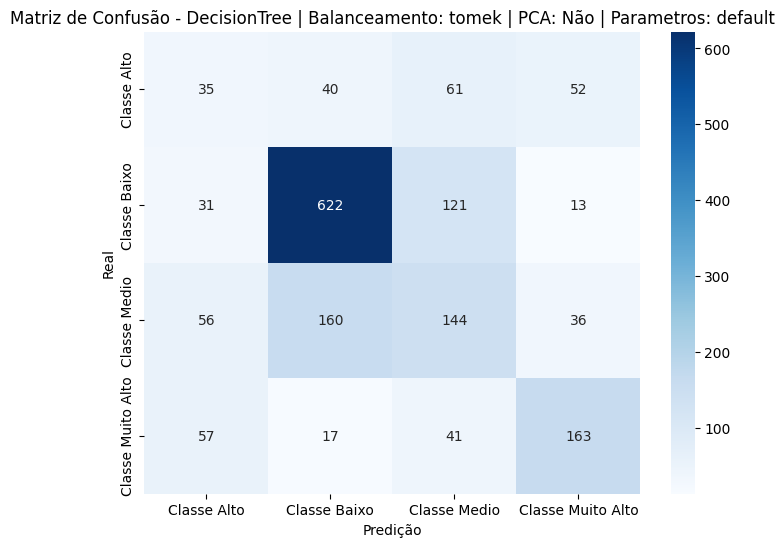


Relatório de Classificação para DecisionTree | Balanceamento: tomek | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.19      0.19       188
     Classe Baixo       0.74      0.79      0.77       787
     Classe Medio       0.39      0.36      0.38       396
Classe Muito Alto       0.62      0.59      0.60       278

         accuracy                           0.58      1649
        macro avg       0.49      0.48      0.48      1649
     weighted avg       0.57      0.58      0.58      1649

Tempo de treinamento: 0.5178 segundos

==================== NeuralNetwork ====================


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


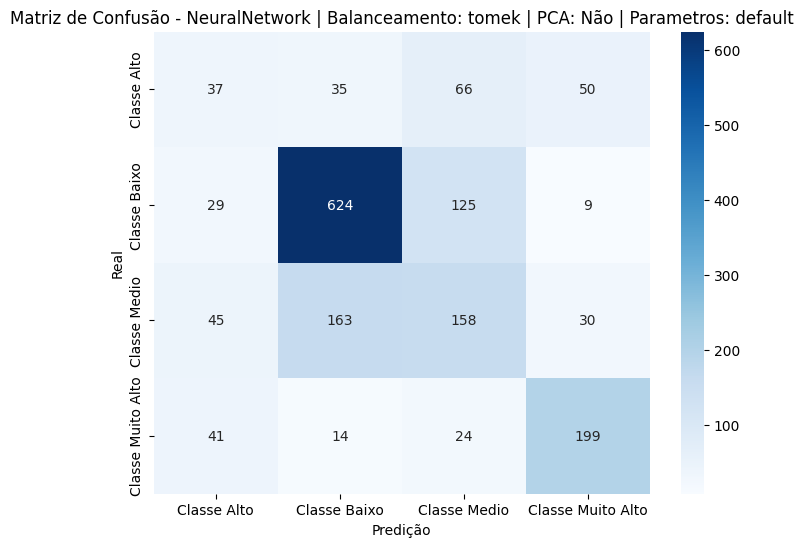


Relatório de Classificação para NeuralNetwork | Balanceamento: tomek | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.24      0.20      0.22       188
     Classe Baixo       0.75      0.79      0.77       787
     Classe Medio       0.42      0.40      0.41       396
Classe Muito Alto       0.69      0.72      0.70       278

         accuracy                           0.62      1649
        macro avg       0.53      0.53      0.53      1649
     weighted avg       0.60      0.62      0.61      1649

Tempo de treinamento: 19.6809 segundos

==================== NaiveBayes ====================


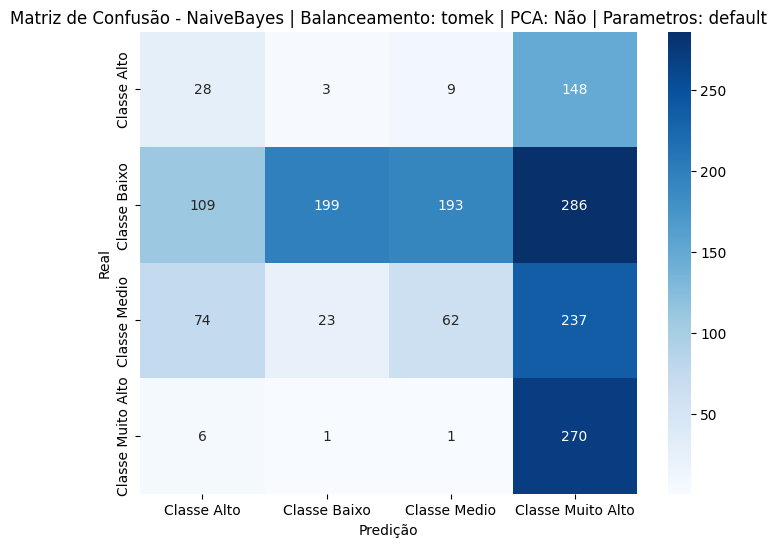


Relatório de Classificação para NaiveBayes | Balanceamento: tomek | PCA: Não | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0695 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: tomek | PC...        0.653123   
2  SVM | Balanceamento: tomek | PCA: Não | Parame...        0.642207   
5  NeuralNetwork | Balanceamento: tomek | PCA: Nã...        0.617344   
1  RandomForest | Balanceamento: tomek | PCA: Não...        0.607641   
3  KNN | Balanceamento: tomek | PCA: Não | Parame...        0.593087   
4  DecisionTree | Balanceamento: tomek | PCA: Não...        0.584597   
6  NaiveBayes | Balanceamento: tomek | PCA: Não |...        0.338993   

   Tempo Treinamento (s) Melhores Parâmetros  
0               0.969751                 N/A  
2              17.613333                 N/A  
5              19.680905                 N/A  
1               4.086704                 N/A  
3               0.007050                 N/A  
4               0.517762                 N/A  
6               0.069459                 N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6531!

==================== LogisticRegression ====================
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: default com acurácia de 0.6295!


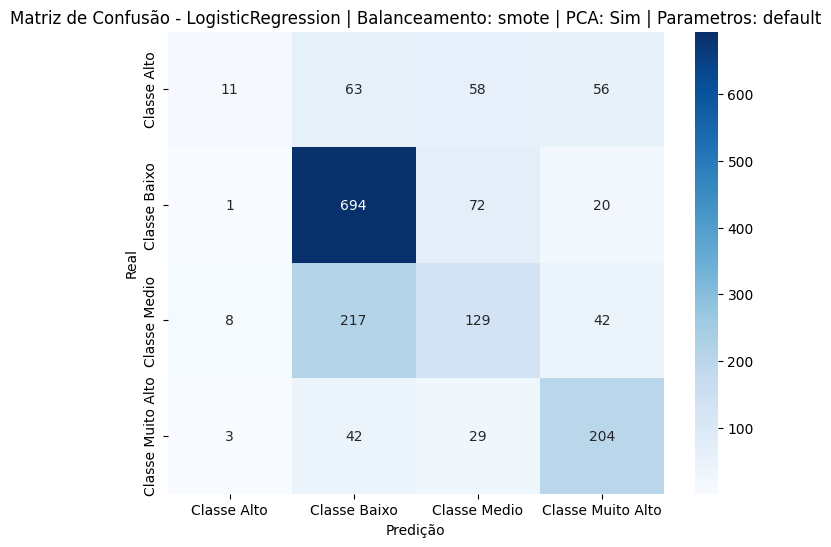


Relatório de Classificação para LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.48      0.06      0.10       188
     Classe Baixo       0.68      0.88      0.77       787
     Classe Medio       0.45      0.33      0.38       396
Classe Muito Alto       0.63      0.73      0.68       278

         accuracy                           0.63      1649
        macro avg       0.56      0.50      0.48      1649
     weighted avg       0.59      0.63      0.58      1649

Tempo de treinamento: 0.1432 segundos

==================== RandomForest ====================


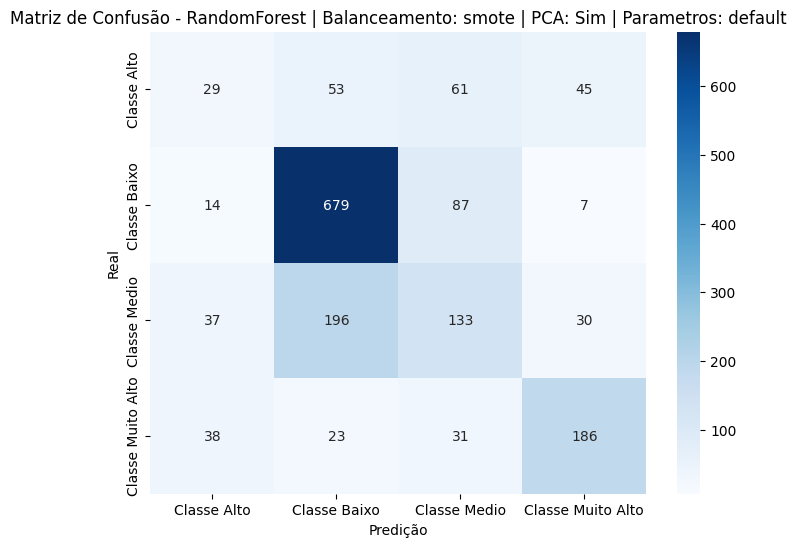


Relatório de Classificação para RandomForest | Balanceamento: smote | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.15      0.19       188
     Classe Baixo       0.71      0.86      0.78       787
     Classe Medio       0.43      0.34      0.38       396
Classe Muito Alto       0.69      0.67      0.68       278

         accuracy                           0.62      1649
        macro avg       0.52      0.51      0.51      1649
     weighted avg       0.59      0.62      0.60      1649

Tempo de treinamento: 7.3718 segundos

==================== SVM ====================


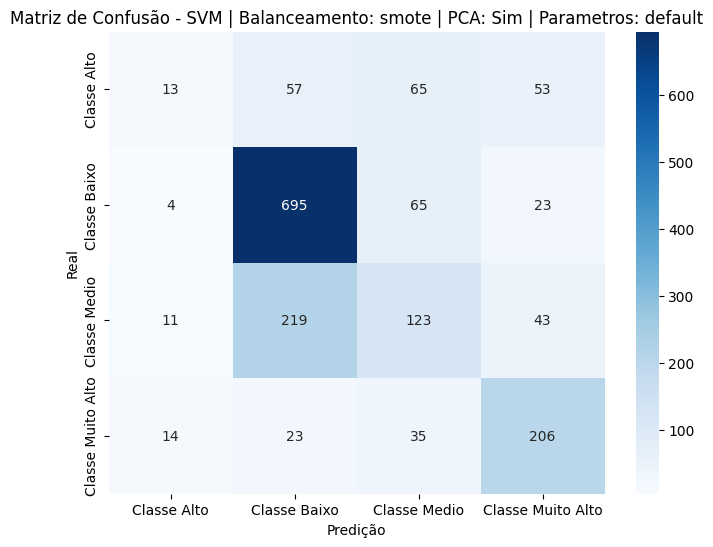


Relatório de Classificação para SVM | Balanceamento: smote | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.31      0.07      0.11       188
     Classe Baixo       0.70      0.88      0.78       787
     Classe Medio       0.43      0.31      0.36       396
Classe Muito Alto       0.63      0.74      0.68       278

         accuracy                           0.63      1649
        macro avg       0.52      0.50      0.48      1649
     weighted avg       0.58      0.63      0.59      1649

Tempo de treinamento: 1.8288 segundos

==================== KNN ====================


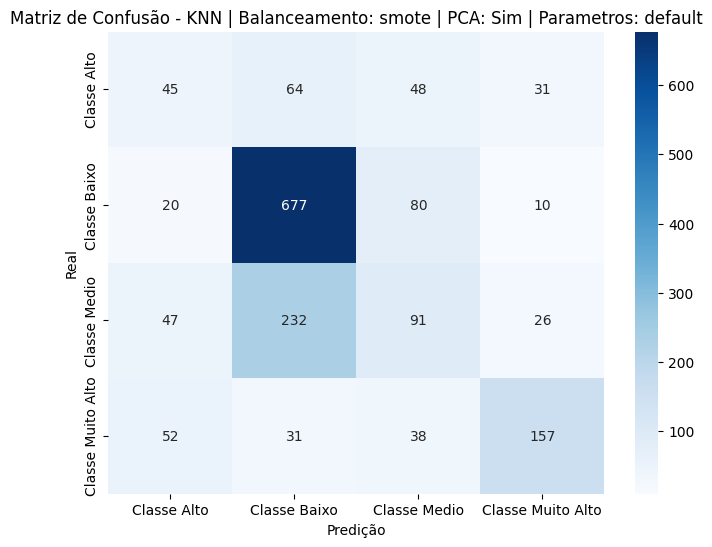


Relatório de Classificação para KNN | Balanceamento: smote | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.24      0.26       188
     Classe Baixo       0.67      0.86      0.76       787
     Classe Medio       0.35      0.23      0.28       396
Classe Muito Alto       0.70      0.56      0.63       278

         accuracy                           0.59      1649
        macro avg       0.50      0.47      0.48      1649
     weighted avg       0.56      0.59      0.56      1649

Tempo de treinamento: 0.0053 segundos

==================== DecisionTree ====================


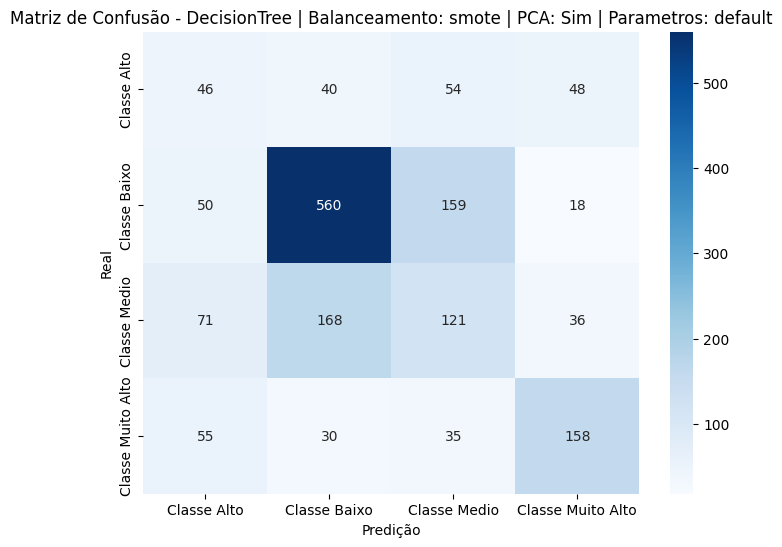


Relatório de Classificação para DecisionTree | Balanceamento: smote | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.21      0.24      0.22       188
     Classe Baixo       0.70      0.71      0.71       787
     Classe Medio       0.33      0.31      0.32       396
Classe Muito Alto       0.61      0.57      0.59       278

         accuracy                           0.54      1649
        macro avg       0.46      0.46      0.46      1649
     weighted avg       0.54      0.54      0.54      1649

Tempo de treinamento: 1.0752 segundos

==================== NeuralNetwork ====================


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


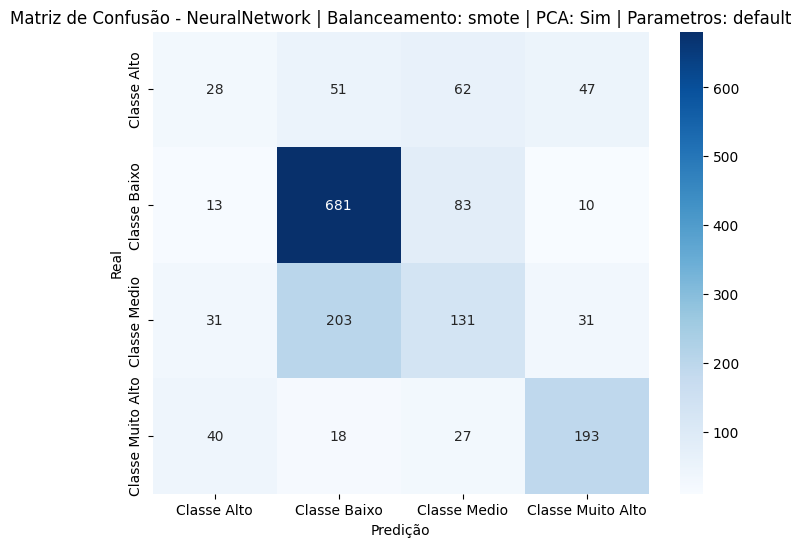


Relatório de Classificação para NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.15      0.19       188
     Classe Baixo       0.71      0.87      0.78       787
     Classe Medio       0.43      0.33      0.37       396
Classe Muito Alto       0.69      0.69      0.69       278

         accuracy                           0.63      1649
        macro avg       0.52      0.51      0.51      1649
     weighted avg       0.59      0.63      0.60      1649

Tempo de treinamento: 4.7898 segundos

==================== NaiveBayes ====================


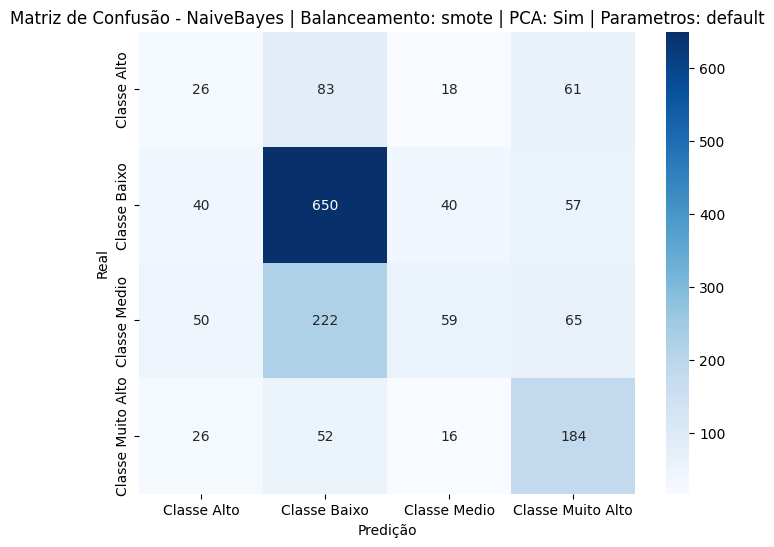


Relatório de Classificação para NaiveBayes | Balanceamento: smote | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.18      0.14      0.16       188
     Classe Baixo       0.65      0.83      0.72       787
     Classe Medio       0.44      0.15      0.22       396
Classe Muito Alto       0.50      0.66      0.57       278

         accuracy                           0.56      1649
        macro avg       0.44      0.44      0.42      1649
     weighted avg       0.52      0.56      0.51      1649

Tempo de treinamento: 0.0100 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: smote | PC...        0.629472   
2  SVM | Balanceamento: smote | PCA: Sim | Parame...        0.628866   
5  NeuralNetwork | Balanceamento: smote | PCA: Si...        0.626440   
1  RandomForest | Balanceamento: smote | PCA: Sim...        0.622802   
3  KNN | Balanceamento: smote | PCA: Sim | Parame...        0.588235   
6  NaiveBayes | Balanceamento: smote | PCA: Sim |...        0.557307   
4  DecisionTree | Balanceamento: smote | PCA: Sim...        0.536689   

   Tempo Treinamento (s) Melhores Parâmetros  
0               0.143187                 N/A  
2               1.828792                 N/A  
5               4.789833                 N/A  
1               7.371759                 N/A  
3               0.005315                 N/A  
6               0.009990                 N/A  
4               1.075174                 N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6295!

==================== LogisticRegression ====================
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: default com acurácia de 0.6258!


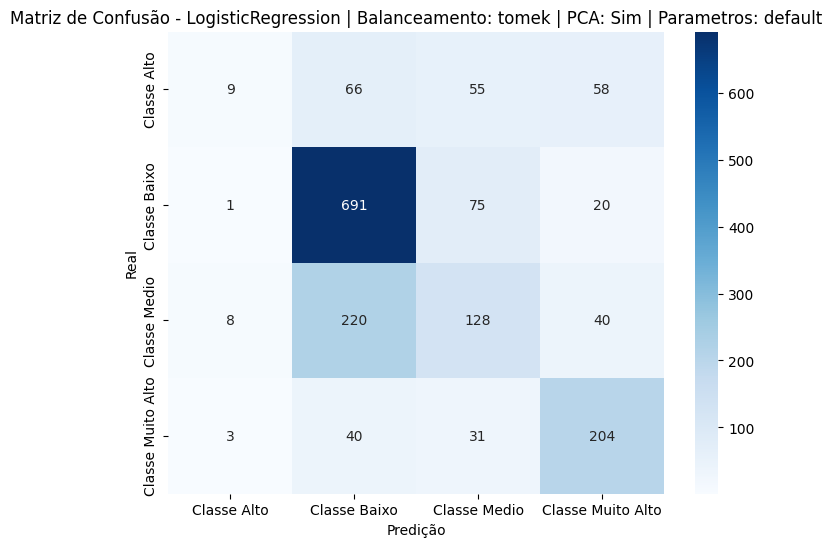


Relatório de Classificação para LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.43      0.05      0.09       188
     Classe Baixo       0.68      0.88      0.77       787
     Classe Medio       0.44      0.32      0.37       396
Classe Muito Alto       0.63      0.73      0.68       278

         accuracy                           0.63      1649
        macro avg       0.55      0.50      0.48      1649
     weighted avg       0.59      0.63      0.58      1649

Tempo de treinamento: 0.1133 segundos

==================== RandomForest ====================


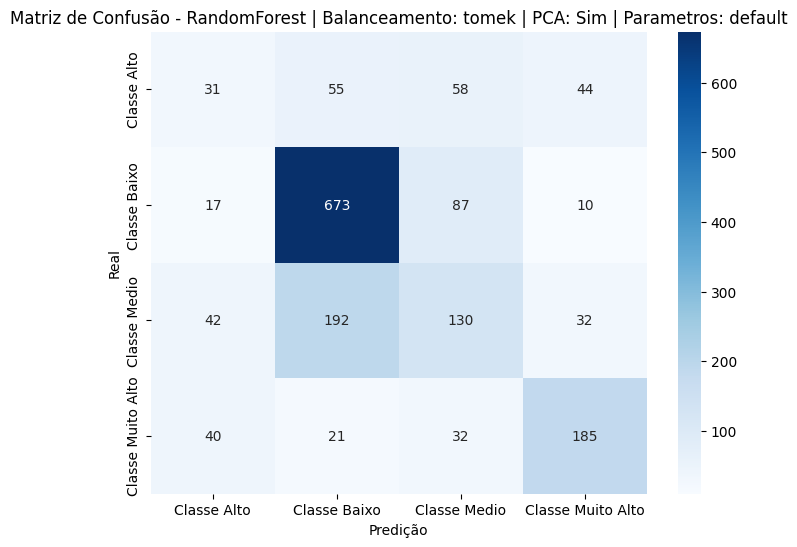


Relatório de Classificação para RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.24      0.16      0.19       188
     Classe Baixo       0.72      0.86      0.78       787
     Classe Medio       0.42      0.33      0.37       396
Classe Muito Alto       0.68      0.67      0.67       278

         accuracy                           0.62      1649
        macro avg       0.51      0.50      0.50      1649
     weighted avg       0.59      0.62      0.60      1649

Tempo de treinamento: 7.1504 segundos

==================== SVM ====================
✨ Novo melhor modelo encontrado: SVM | Balanceamento: tomek | PCA: Sim | Parametros: default com acurácia de 0.6283!


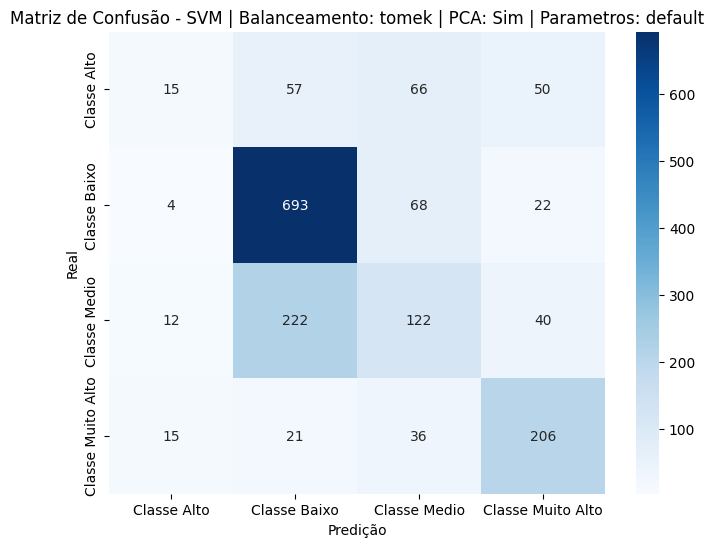


Relatório de Classificação para SVM | Balanceamento: tomek | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.33      0.08      0.13       188
     Classe Baixo       0.70      0.88      0.78       787
     Classe Medio       0.42      0.31      0.35       396
Classe Muito Alto       0.65      0.74      0.69       278

         accuracy                           0.63      1649
        macro avg       0.52      0.50      0.49      1649
     weighted avg       0.58      0.63      0.59      1649

Tempo de treinamento: 1.8239 segundos

==================== KNN ====================


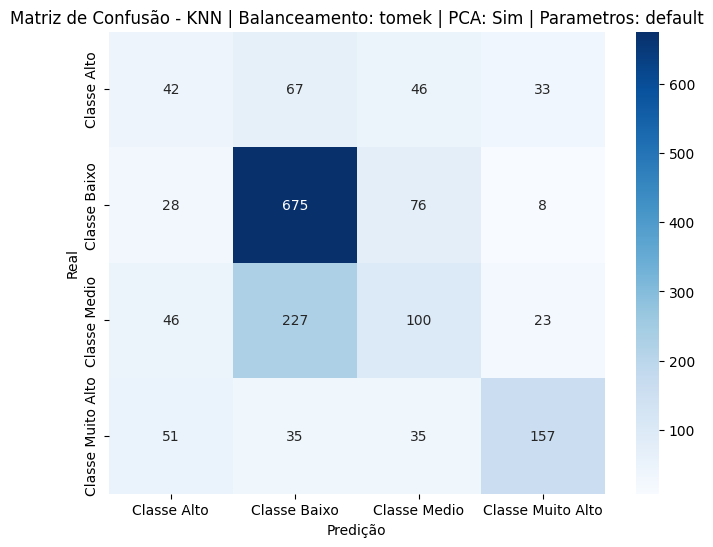


Relatório de Classificação para KNN | Balanceamento: tomek | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.22      0.24       188
     Classe Baixo       0.67      0.86      0.75       787
     Classe Medio       0.39      0.25      0.31       396
Classe Muito Alto       0.71      0.56      0.63       278

         accuracy                           0.59      1649
        macro avg       0.51      0.47      0.48      1649
     weighted avg       0.56      0.59      0.57      1649

Tempo de treinamento: 0.0050 segundos

==================== DecisionTree ====================


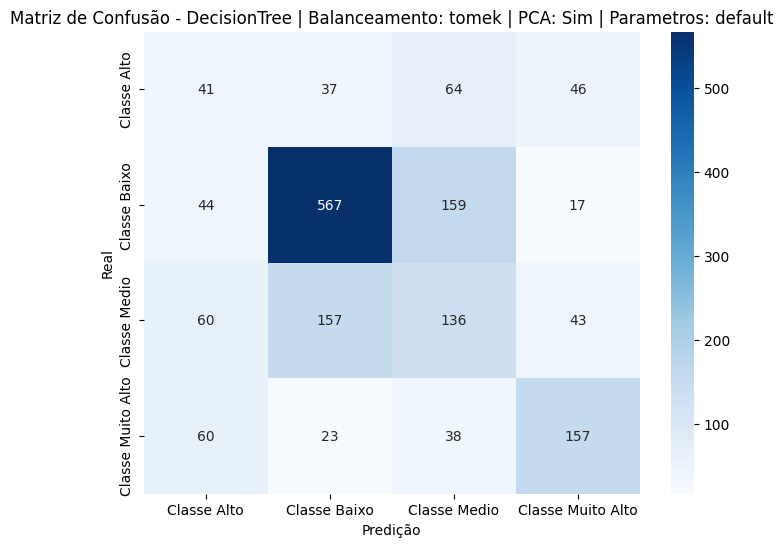


Relatório de Classificação para DecisionTree | Balanceamento: tomek | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.22      0.21       188
     Classe Baixo       0.72      0.72      0.72       787
     Classe Medio       0.34      0.34      0.34       396
Classe Muito Alto       0.60      0.56      0.58       278

         accuracy                           0.55      1649
        macro avg       0.47      0.46      0.46      1649
     weighted avg       0.55      0.55      0.55      1649

Tempo de treinamento: 1.0767 segundos

==================== NeuralNetwork ====================


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


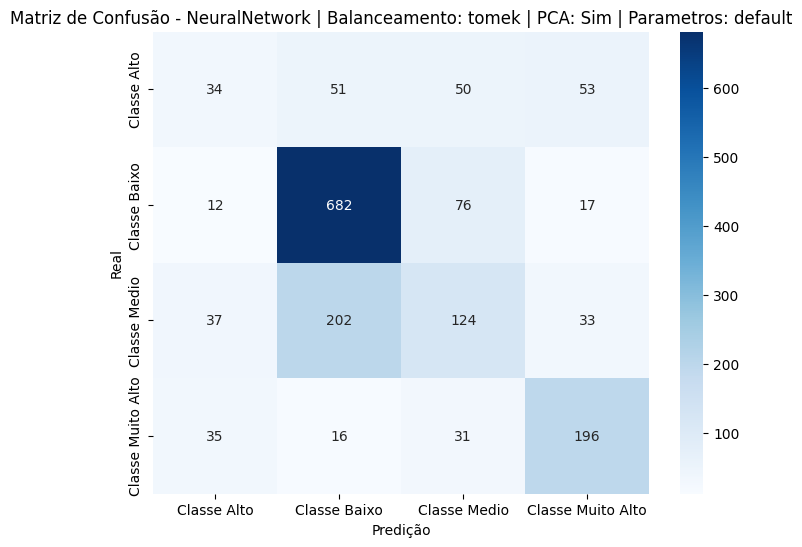


Relatório de Classificação para NeuralNetwork | Balanceamento: tomek | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.29      0.18      0.22       188
     Classe Baixo       0.72      0.87      0.78       787
     Classe Medio       0.44      0.31      0.37       396
Classe Muito Alto       0.66      0.71      0.68       278

         accuracy                           0.63      1649
        macro avg       0.53      0.52      0.51      1649
     weighted avg       0.59      0.63      0.60      1649

Tempo de treinamento: 4.6752 segundos

==================== NaiveBayes ====================


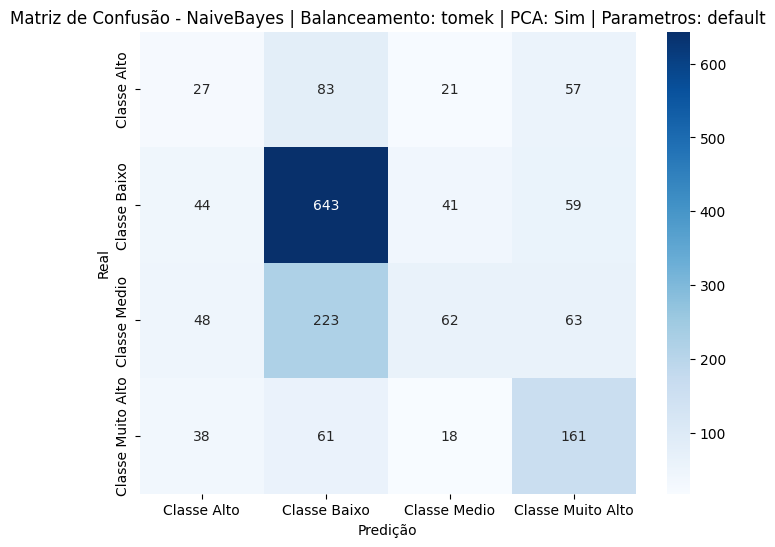


Relatório de Classificação para NaiveBayes | Balanceamento: tomek | PCA: Sim | Parametros: default:
                   precision    recall  f1-score   support

      Classe Alto       0.17      0.14      0.16       188
     Classe Baixo       0.64      0.82      0.72       787
     Classe Medio       0.44      0.16      0.23       396
Classe Muito Alto       0.47      0.58      0.52       278

         accuracy                           0.54      1649
        macro avg       0.43      0.42      0.41      1649
     weighted avg       0.51      0.54      0.50      1649

Tempo de treinamento: 0.0095 segundos


Modelo  Acurácia Teste  \
2  SVM | Balanceamento: tomek | PCA: Sim | Parame...        0.628260   
5  NeuralNetwork | Balanceamento: tomek | PCA: Si...        0.628260   
0  LogisticRegression | Balanceamento: tomek | PC...        0.625834   
1  RandomForest | Balanceamento: tomek | PCA: Sim...        0.617950   
3  KNN | Balanceamento: tomek | PCA: Sim | Parame...        0.590661   
4  DecisionTree | Balanceamento: tomek | PCA: Sim...        0.546392   
6  NaiveBayes | Balanceamento: tomek | PCA: Sim |...        0.541540   

   Tempo Treinamento (s) Melhores Parâmetros  
2               1.823919                 N/A  
5               4.675247                 N/A  
0               0.113343                 N/A  
1               7.150367                 N/A  
3               0.005002                 N/A  
4               1.076695                 N/A  
6               0.009498                 N/A

✨ Melhor modelo salvo: SVM com acurácia de 0.6283!

==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: grid com acurácia de 0.6513!


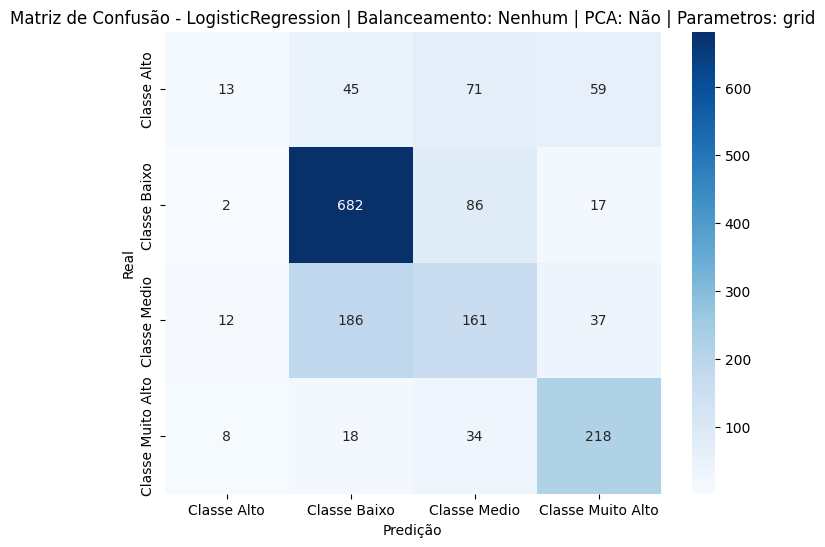


Relatório de Classificação para LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 8.3558 segundos
📌 Melhores parâmetros encontrados para LogisticRegression:
{'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits


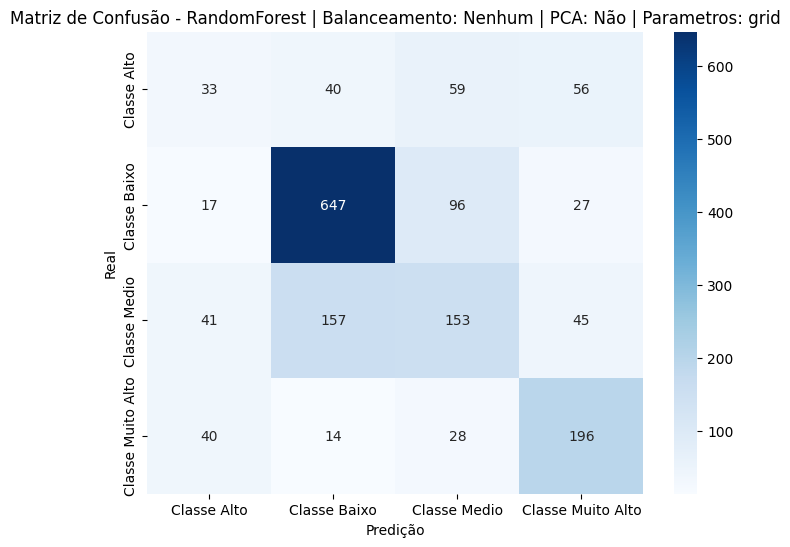


Relatório de Classificação para RandomForest | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.18      0.21       188
     Classe Baixo       0.75      0.82      0.79       787
     Classe Medio       0.46      0.39      0.42       396
Classe Muito Alto       0.60      0.71      0.65       278

         accuracy                           0.62      1649
        macro avg       0.52      0.52      0.52      1649
     weighted avg       0.60      0.62      0.61      1649

Tempo de treinamento: 23.3438 segundos
📌 Melhores parâmetros encontrados para RandomForest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


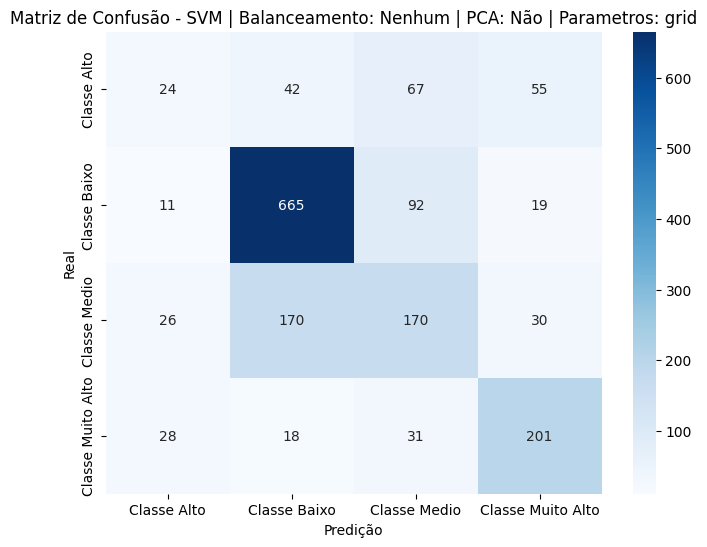


Relatório de Classificação para SVM | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 128.6688 segundos
📌 Melhores parâmetros encontrados para SVM:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_sc

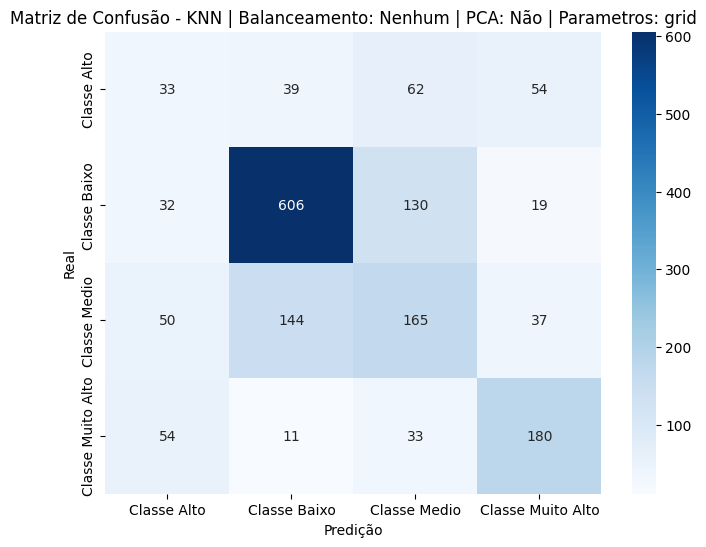


Relatório de Classificação para KNN | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.76       787
     Classe Medio       0.42      0.42      0.42       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.59      1649

Tempo de treinamento: 6.5878 segundos
📌 Melhores parâmetros encontrados para KNN:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


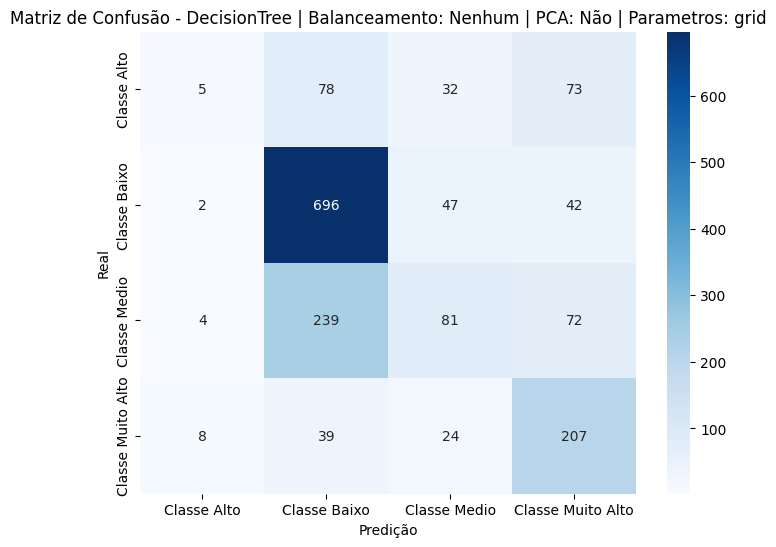


Relatório de Classificação para DecisionTree | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.88      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.53      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.47      0.43      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 1.1512 segundos
📌 Melhores parâmetros encontrados para DecisionTree:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/sit

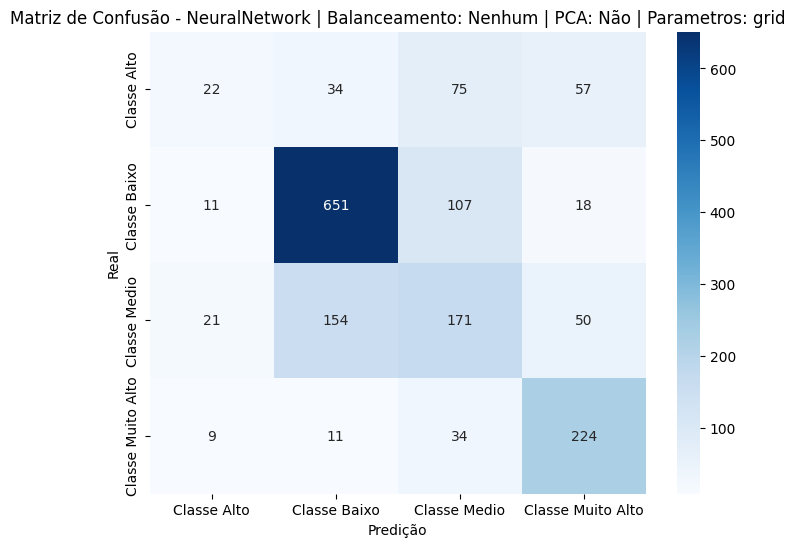


Relatório de Classificação para NeuralNetwork | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.35      0.12      0.18       188
     Classe Baixo       0.77      0.83      0.80       787
     Classe Medio       0.44      0.43      0.44       396
Classe Muito Alto       0.64      0.81      0.71       278

         accuracy                           0.65      1649
        macro avg       0.55      0.55      0.53      1649
     weighted avg       0.62      0.65      0.62      1649

Tempo de treinamento: 41.7044 segundos
📌 Melhores parâmetros encontrados para NeuralNetwork:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50,)}

==================== NaiveBayes ====================


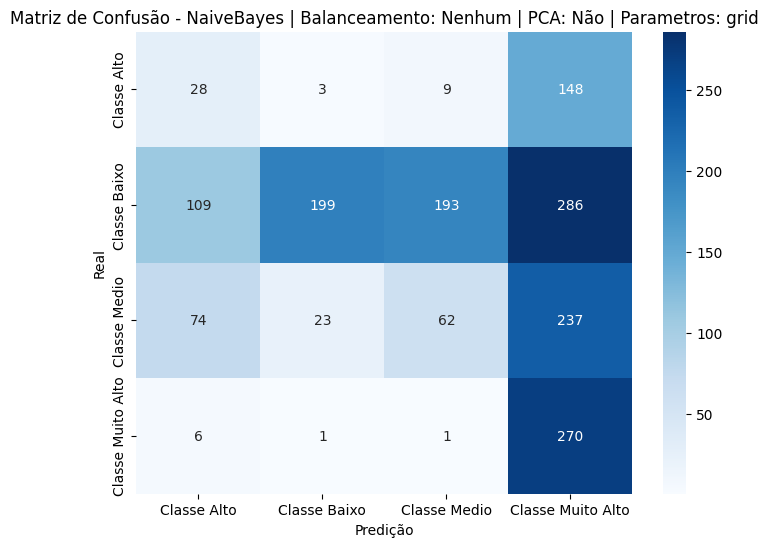


Relatório de Classificação para NaiveBayes | Balanceamento: Nenhum | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0552 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: Nenhum | P...        0.651304   
5  NeuralNetwork | Balanceamento: Nenhum | PCA: N...        0.647665   
2  SVM | Balanceamento: Nenhum | PCA: Não | Param...        0.642814   
1  RandomForest | Balanceamento: Nenhum | PCA: Nã...        0.624015   
4  DecisionTree | Balanceamento: Nenhum | PCA: Nã...        0.599757   
3  KNN | Balanceamento: Nenhum | PCA: Não | Param...        0.596725   
6  NaiveBayes | Balanceamento: Nenhum | PCA: Não ...        0.338993   

   Tempo Treinamento (s)                                Melhores Parâmetros  
0               8.355849     {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}  
5              41.704399  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
2             128.668786     {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}  
1              23.343821  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
4               1.151198  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
3               6.587835  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...  
6               0.055194                                                N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Não | Parametros: grid com acurácia de 0.6513!


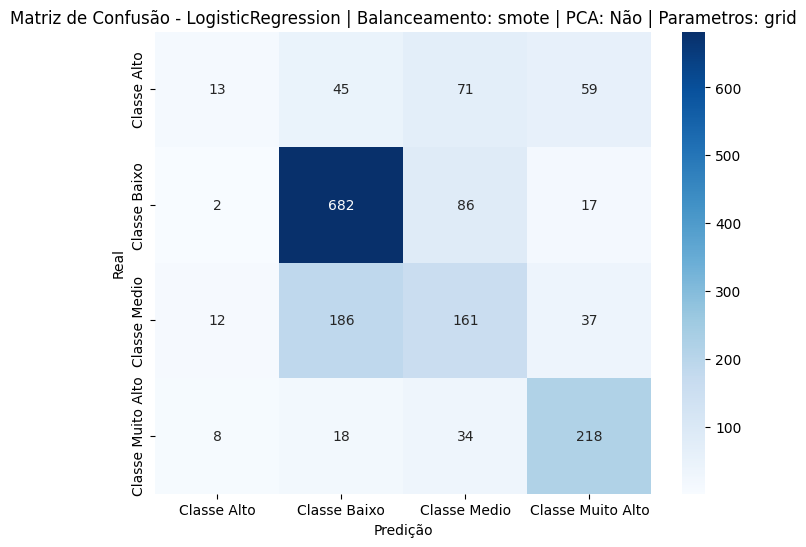


Relatório de Classificação para LogisticRegression | Balanceamento: smote | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 5.6403 segundos
📌 Melhores parâmetros encontrados para LogisticRegression:
{'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits


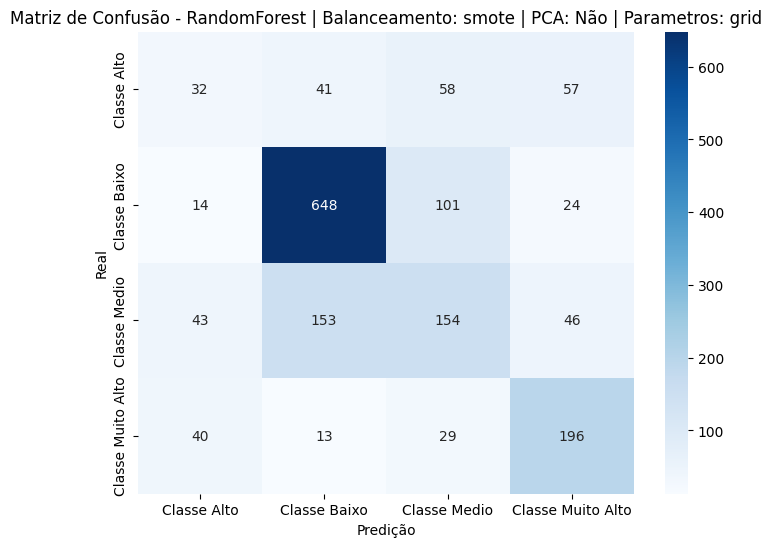


Relatório de Classificação para RandomForest | Balanceamento: smote | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.17      0.20       188
     Classe Baixo       0.76      0.82      0.79       787
     Classe Medio       0.45      0.39      0.42       396
Classe Muito Alto       0.61      0.71      0.65       278

         accuracy                           0.62      1649
        macro avg       0.52      0.52      0.52      1649
     weighted avg       0.60      0.62      0.61      1649

Tempo de treinamento: 24.8010 segundos
📌 Melhores parâmetros encontrados para RandomForest:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


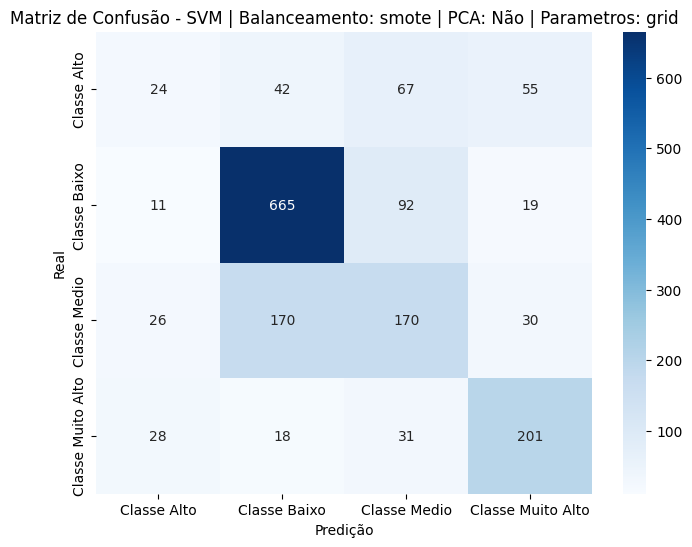


Relatório de Classificação para SVM | Balanceamento: smote | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 147.0769 segundos
📌 Melhores parâmetros encontrados para SVM:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_sc

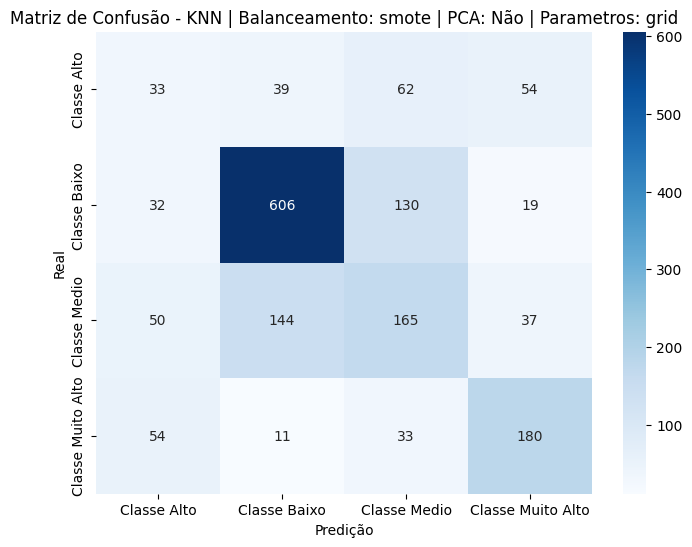


Relatório de Classificação para KNN | Balanceamento: smote | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.76       787
     Classe Medio       0.42      0.42      0.42       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.59      1649

Tempo de treinamento: 6.5089 segundos
📌 Melhores parâmetros encontrados para KNN:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


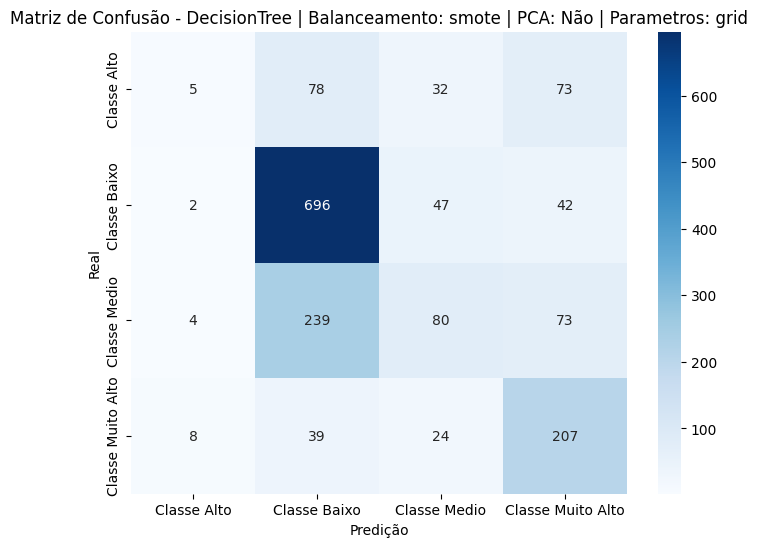


Relatório de Classificação para DecisionTree | Balanceamento: smote | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.88      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 1.0393 segundos
📌 Melhores parâmetros encontrados para DecisionTree:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/sit

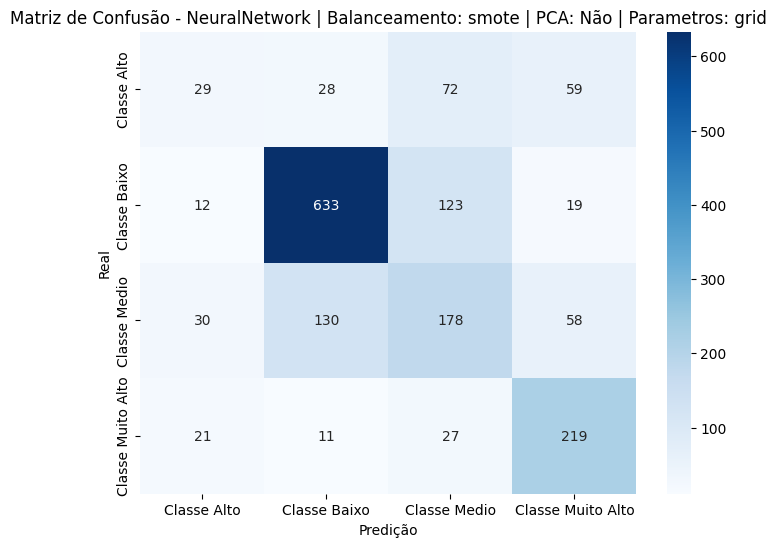


Relatório de Classificação para NeuralNetwork | Balanceamento: smote | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.32      0.15      0.21       188
     Classe Baixo       0.79      0.80      0.80       787
     Classe Medio       0.45      0.45      0.45       396
Classe Muito Alto       0.62      0.79      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.55      0.54      1649
     weighted avg       0.62      0.64      0.63      1649

Tempo de treinamento: 55.3317 segundos
📌 Melhores parâmetros encontrados para NeuralNetwork:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,)}

==================== NaiveBayes ====================


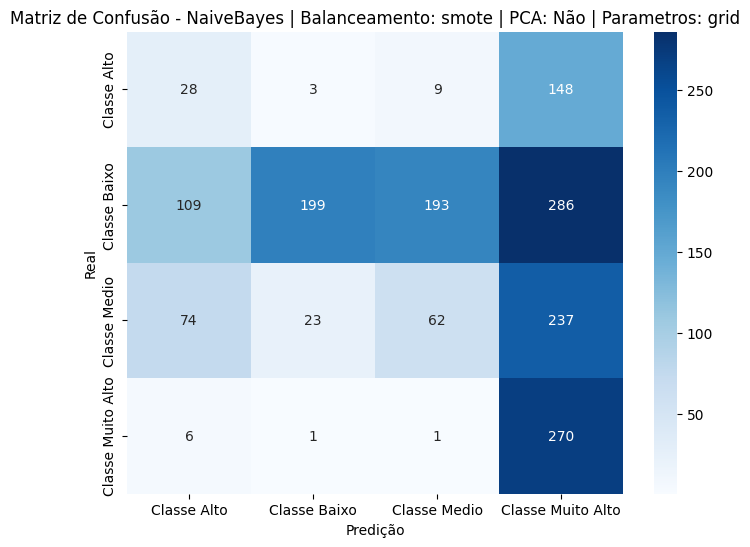


Relatório de Classificação para NaiveBayes | Balanceamento: smote | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0517 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: smote | PC...        0.651304   
2  SVM | Balanceamento: smote | PCA: Não | Parame...        0.642814   
5  NeuralNetwork | Balanceamento: smote | PCA: Nã...        0.642207   
1  RandomForest | Balanceamento: smote | PCA: Não...        0.624621   
4  DecisionTree | Balanceamento: smote | PCA: Não...        0.599151   
3  KNN | Balanceamento: smote | PCA: Não | Parame...        0.596725   
6  NaiveBayes | Balanceamento: smote | PCA: Não |...        0.338993   

   Tempo Treinamento (s)                                Melhores Parâmetros  
0               5.640313     {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}  
2             147.076905     {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}  
5              55.331706  {'activation': 'tanh', 'alpha': 0.0001, 'hidde...  
1              24.801025  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
4               1.039348  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
3               6.508871  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...  
6               0.051704                                                N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Não | Parametros: grid com acurácia de 0.6513!


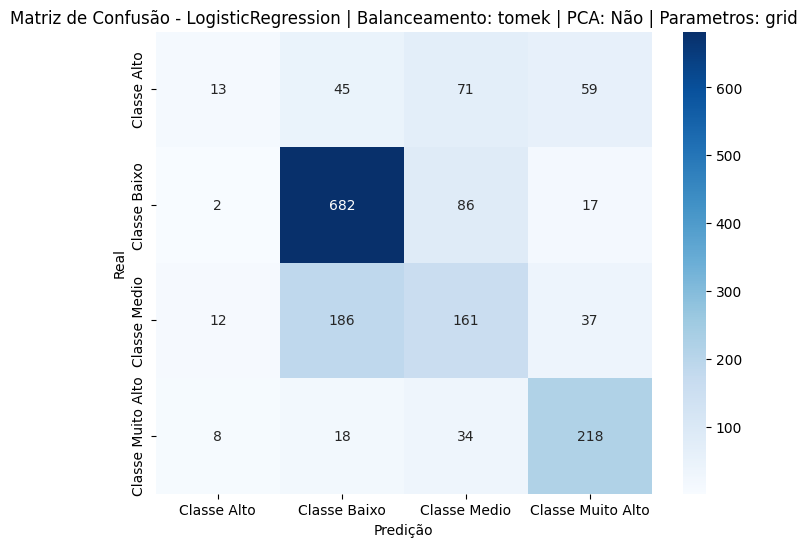


Relatório de Classificação para LogisticRegression | Balanceamento: tomek | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 7.4201 segundos
📌 Melhores parâmetros encontrados para LogisticRegression:
{'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits


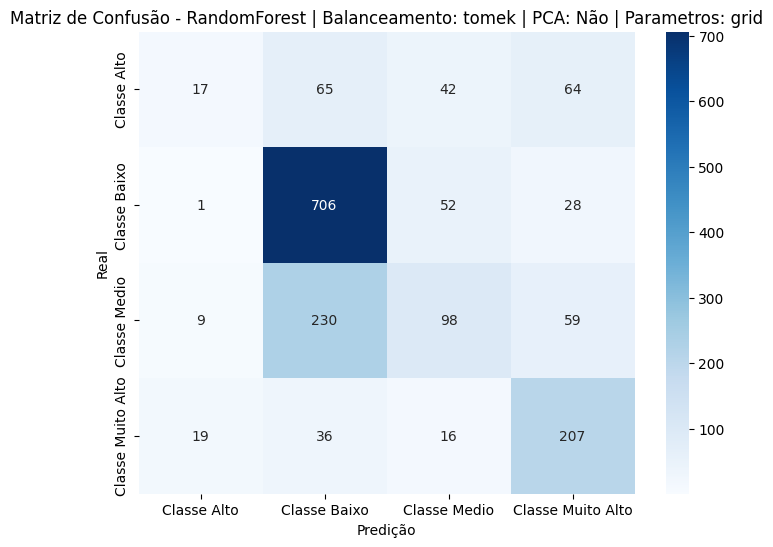


Relatório de Classificação para RandomForest | Balanceamento: tomek | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.09      0.15       188
     Classe Baixo       0.68      0.90      0.77       787
     Classe Medio       0.47      0.25      0.32       396
Classe Muito Alto       0.58      0.74      0.65       278

         accuracy                           0.62      1649
        macro avg       0.52      0.49      0.47      1649
     weighted avg       0.58      0.62      0.57      1649

Tempo de treinamento: 18.4734 segundos
📌 Melhores parâmetros encontrados para RandomForest:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


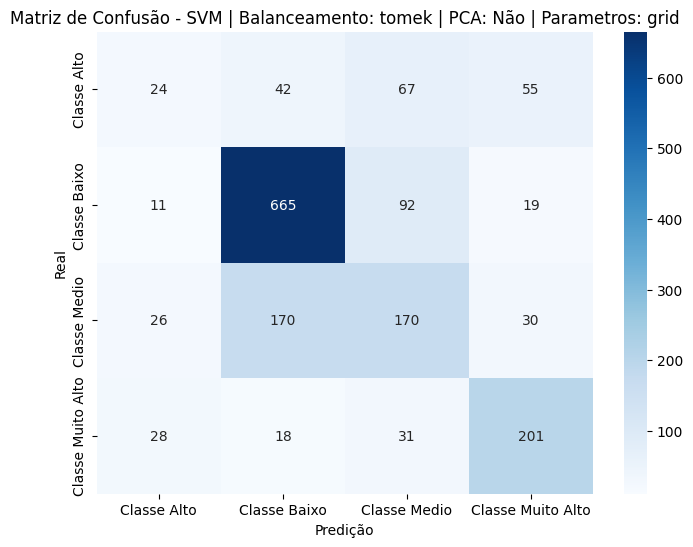


Relatório de Classificação para SVM | Balanceamento: tomek | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 171.5755 segundos
📌 Melhores parâmetros encontrados para SVM:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_sc

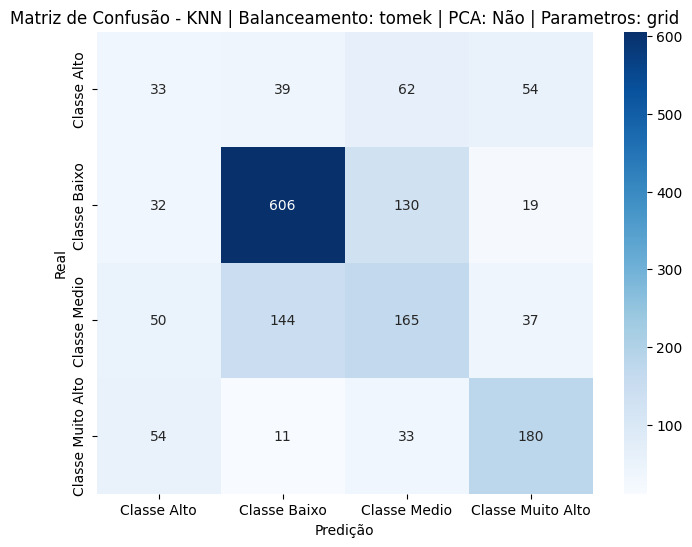


Relatório de Classificação para KNN | Balanceamento: tomek | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.76       787
     Classe Medio       0.42      0.42      0.42       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.59      1649

Tempo de treinamento: 6.6063 segundos
📌 Melhores parâmetros encontrados para KNN:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


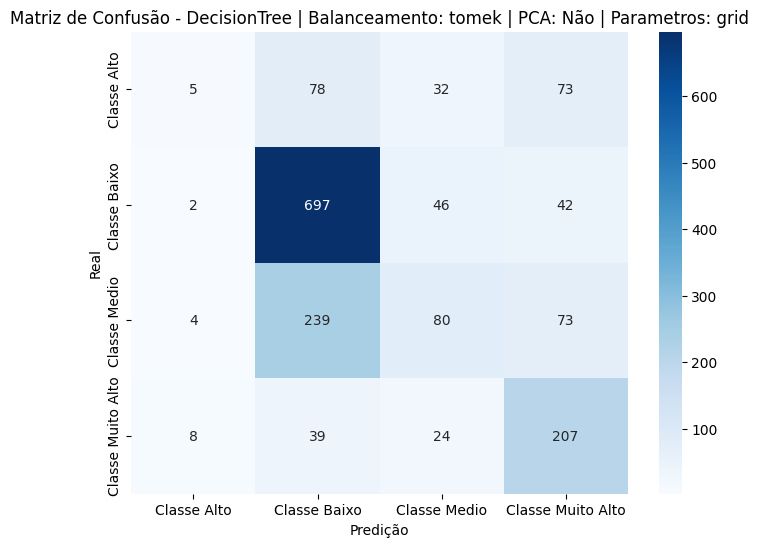


Relatório de Classificação para DecisionTree | Balanceamento: tomek | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.89      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.9879 segundos
📌 Melhores parâmetros encontrados para DecisionTree:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/sit

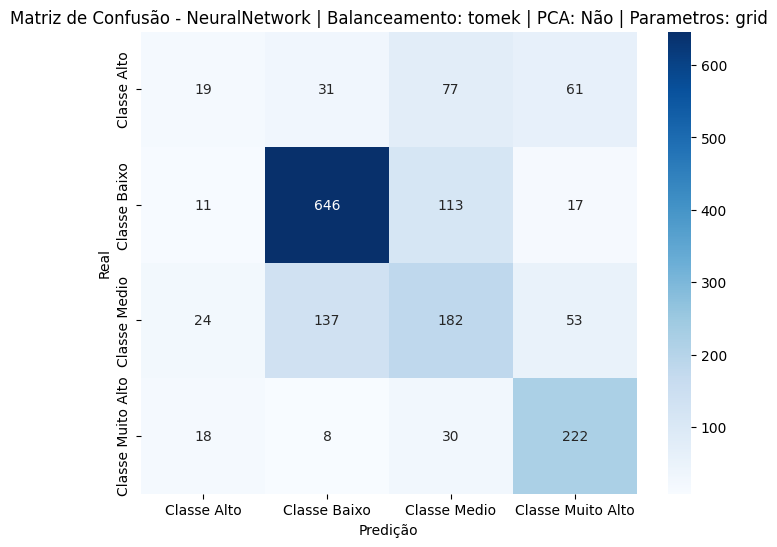


Relatório de Classificação para NeuralNetwork | Balanceamento: tomek | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.10      0.15       188
     Classe Baixo       0.79      0.82      0.80       787
     Classe Medio       0.45      0.46      0.46       396
Classe Muito Alto       0.63      0.80      0.70       278

         accuracy                           0.65      1649
        macro avg       0.53      0.55      0.53      1649
     weighted avg       0.62      0.65      0.63      1649

Tempo de treinamento: 51.4101 segundos
📌 Melhores parâmetros encontrados para NeuralNetwork:
{'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (50,)}

==================== NaiveBayes ====================


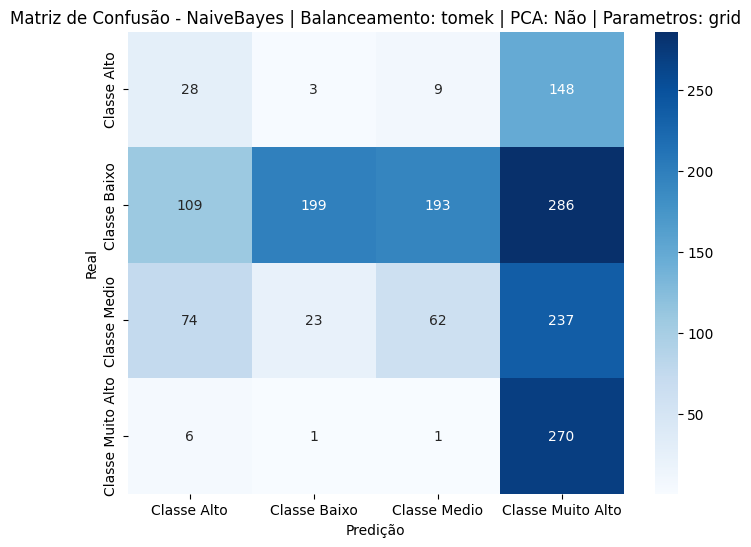


Relatório de Classificação para NaiveBayes | Balanceamento: tomek | PCA: Não | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0508 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: tomek | PC...        0.651304   
5  NeuralNetwork | Balanceamento: tomek | PCA: Nã...        0.648272   
2  SVM | Balanceamento: tomek | PCA: Não | Parame...        0.642814   
1  RandomForest | Balanceamento: tomek | PCA: Não...        0.623408   
4  DecisionTree | Balanceamento: tomek | PCA: Não...        0.599757   
3  KNN | Balanceamento: tomek | PCA: Não | Parame...        0.596725   
6  NaiveBayes | Balanceamento: tomek | PCA: Não |...        0.338993   

   Tempo Treinamento (s)                                Melhores Parâmetros  
0               7.420147     {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}  
5              51.410100  {'activation': 'tanh', 'alpha': 0.001, 'hidden...  
2             171.575536     {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}  
1              18.473373  {'max_depth': None, 'min_samples_leaf': 2, 'mi...  
4               0.987896  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
3               6.606347  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...  
6               0.050752                                                N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: grid com acurácia de 0.6270!


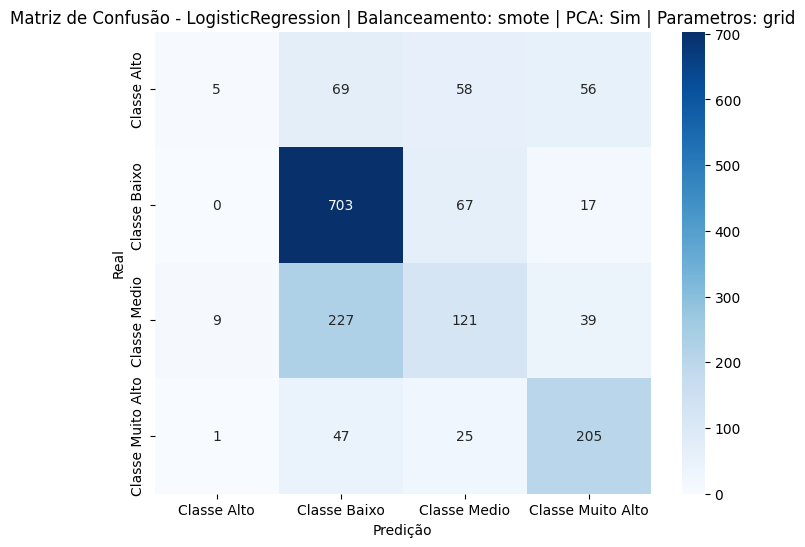


Relatório de Classificação para LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.33      0.03      0.05       188
     Classe Baixo       0.67      0.89      0.77       787
     Classe Medio       0.45      0.31      0.36       396
Classe Muito Alto       0.65      0.74      0.69       278

         accuracy                           0.63      1649
        macro avg       0.52      0.49      0.47      1649
     weighted avg       0.58      0.63      0.57      1649

Tempo de treinamento: 1.7558 segundos
📌 Melhores parâmetros encontrados para LogisticRegression:
{'C': 10.0, 'max_iter': 500, 'solver': 'liblinear'}

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✨ Novo melhor modelo encontrado: RandomForest | Balanceamento: smote | PCA: Sim | Parametros: grid com acurácia de 0.6319!


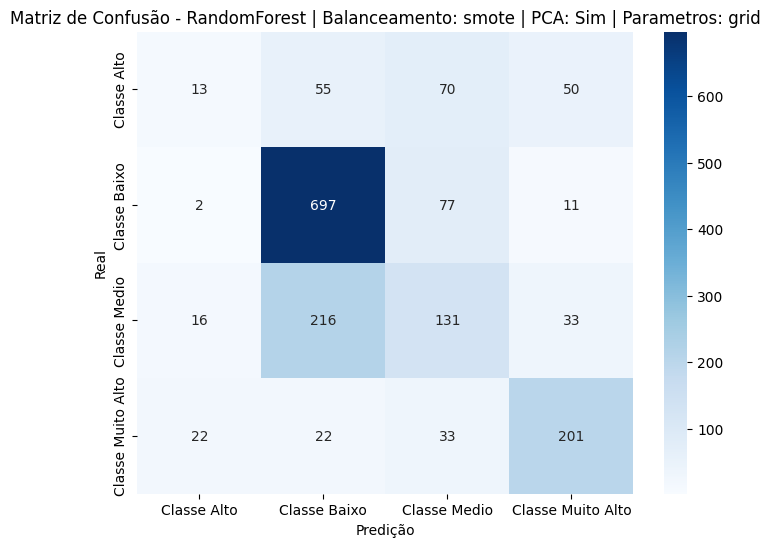


Relatório de Classificação para RandomForest | Balanceamento: smote | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.07      0.11       188
     Classe Baixo       0.70      0.89      0.78       787
     Classe Medio       0.42      0.33      0.37       396
Classe Muito Alto       0.68      0.72      0.70       278

         accuracy                           0.63      1649
        macro avg       0.51      0.50      0.49      1649
     weighted avg       0.58      0.63      0.59      1649

Tempo de treinamento: 31.2453 segundos
📌 Melhores parâmetros encontrados para RandomForest:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


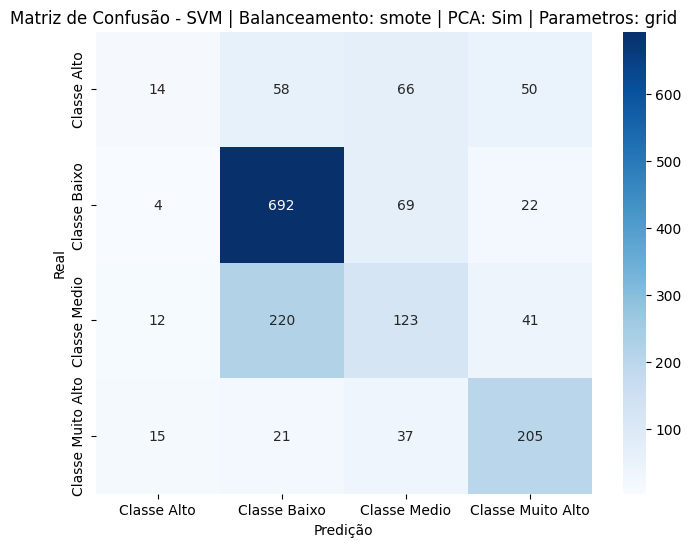


Relatório de Classificação para SVM | Balanceamento: smote | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.31      0.07      0.12       188
     Classe Baixo       0.70      0.88      0.78       787
     Classe Medio       0.42      0.31      0.36       396
Classe Muito Alto       0.64      0.74      0.69       278

         accuracy                           0.63      1649
        macro avg       0.52      0.50      0.49      1649
     weighted avg       0.58      0.63      0.59      1649

Tempo de treinamento: 5.9122 segundos
📌 Melhores parâmetros encontrados para SVM:
{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_sc

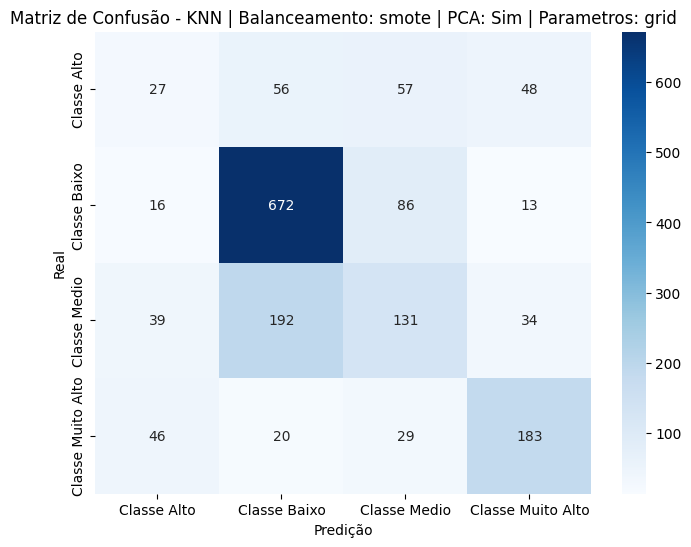


Relatório de Classificação para KNN | Balanceamento: smote | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.21      0.14      0.17       188
     Classe Baixo       0.71      0.85      0.78       787
     Classe Medio       0.43      0.33      0.37       396
Classe Muito Alto       0.66      0.66      0.66       278

         accuracy                           0.61      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.58      0.61      0.59      1649

Tempo de treinamento: 0.7451 segundos
📌 Melhores parâmetros encontrados para KNN:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


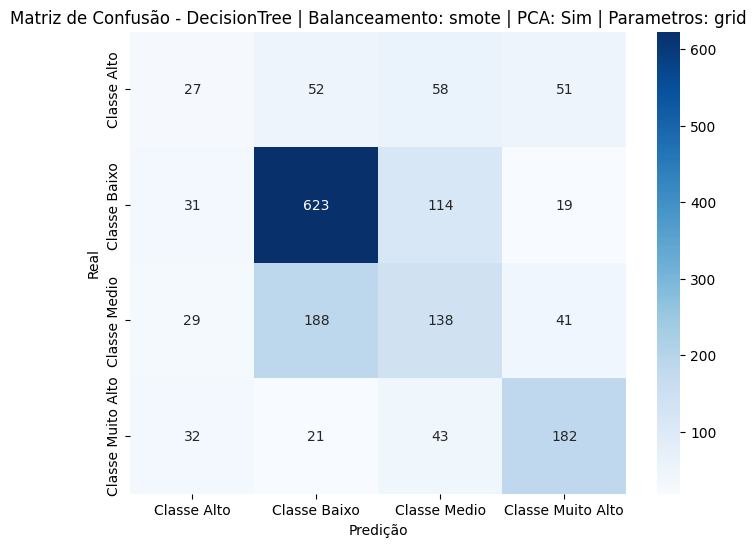


Relatório de Classificação para DecisionTree | Balanceamento: smote | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.23      0.14      0.18       188
     Classe Baixo       0.70      0.79      0.75       787
     Classe Medio       0.39      0.35      0.37       396
Classe Muito Alto       0.62      0.65      0.64       278

         accuracy                           0.59      1649
        macro avg       0.49      0.48      0.48      1649
     weighted avg       0.56      0.59      0.57      1649

Tempo de treinamento: 1.8977 segundos
📌 Melhores parâmetros encontrados para DecisionTree:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/sit

✨ Novo melhor modelo encontrado: NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: grid com acurácia de 0.6507!


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


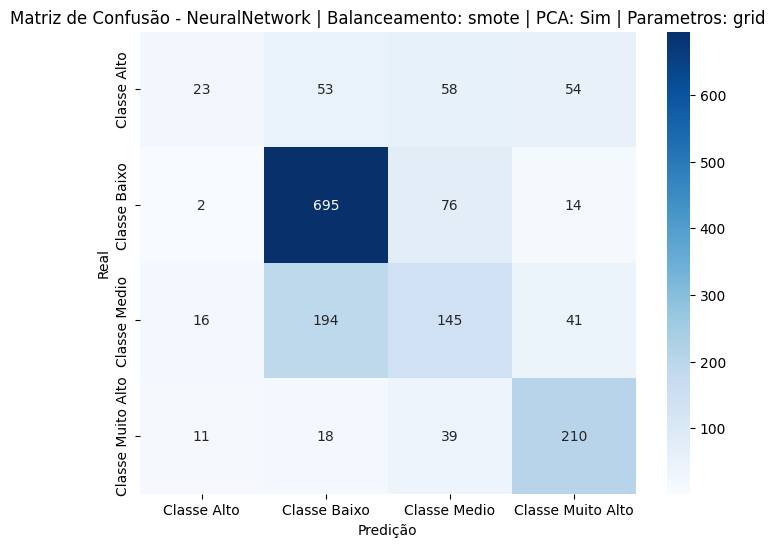


Relatório de Classificação para NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.44      0.12      0.19       188
     Classe Baixo       0.72      0.88      0.80       787
     Classe Medio       0.46      0.37      0.41       396
Classe Muito Alto       0.66      0.76      0.70       278

         accuracy                           0.65      1649
        macro avg       0.57      0.53      0.52      1649
     weighted avg       0.62      0.65      0.62      1649

Tempo de treinamento: 9.8982 segundos
📌 Melhores parâmetros encontrados para NeuralNetwork:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}

==================== NaiveBayes ====================


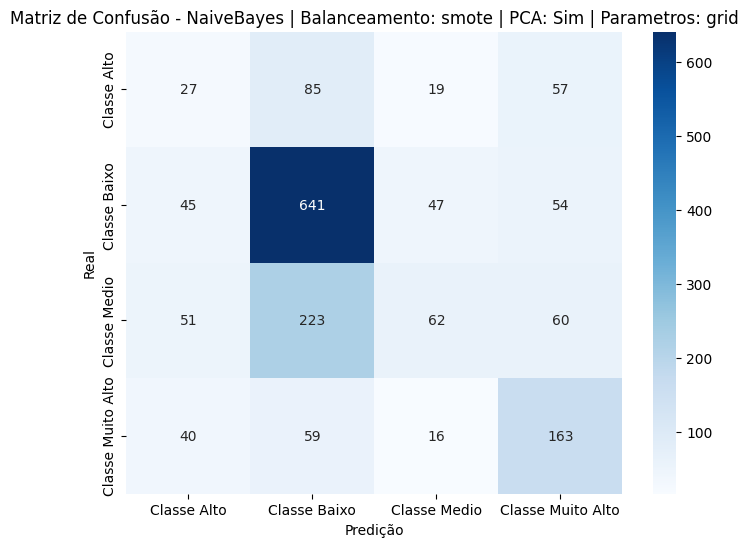


Relatório de Classificação para NaiveBayes | Balanceamento: smote | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.17      0.14      0.15       188
     Classe Baixo       0.64      0.81      0.71       787
     Classe Medio       0.43      0.16      0.23       396
Classe Muito Alto       0.49      0.59      0.53       278

         accuracy                           0.54      1649
        macro avg       0.43      0.43      0.41      1649
     weighted avg       0.51      0.54      0.50      1649

Tempo de treinamento: 0.0096 segundos


Modelo  Acurácia Teste  \
5  NeuralNetwork | Balanceamento: smote | PCA: Si...        0.650697   
1  RandomForest | Balanceamento: smote | PCA: Sim...        0.631898   
0  LogisticRegression | Balanceamento: smote | PC...        0.627047   
2  SVM | Balanceamento: smote | PCA: Sim | Parame...        0.627047   
3  KNN | Balanceamento: smote | PCA: Sim | Parame...        0.614312   
4  DecisionTree | Balanceamento: smote | PCA: Sim...        0.588235   
6  NaiveBayes | Balanceamento: smote | PCA: Sim |...        0.541540   

   Tempo Treinamento (s)                                Melhores Parâmetros  
5               9.898204  {'activation': 'tanh', 'alpha': 0.0001, 'hidde...  
1              31.245306  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
0               1.755803  {'C': 10.0, 'max_iter': 500, 'solver': 'liblin...  
2               5.912172        {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}  
3               0.745148  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...  
4               1.897719  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
6               0.009592                                                N/A

✨ Melhor modelo salvo: NeuralNetwork com acurácia de 0.6507!

==================== LogisticRegression ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: grid com acurácia de 0.6246!


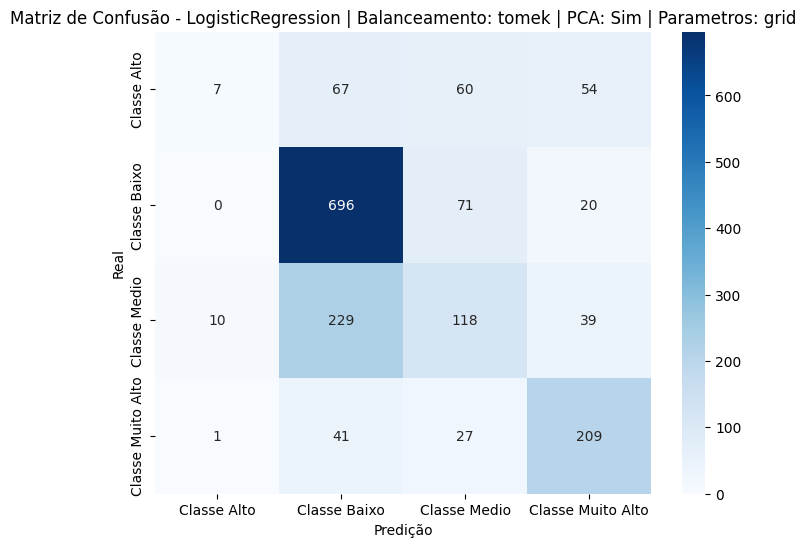


Relatório de Classificação para LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.39      0.04      0.07       188
     Classe Baixo       0.67      0.88      0.76       787
     Classe Medio       0.43      0.30      0.35       396
Classe Muito Alto       0.65      0.75      0.70       278

         accuracy                           0.62      1649
        macro avg       0.53      0.49      0.47      1649
     weighted avg       0.58      0.62      0.57      1649

Tempo de treinamento: 1.6163 segundos
📌 Melhores parâmetros encontrados para LogisticRegression:
{'C': 10.0, 'max_iter': 500, 'solver': 'liblinear'}

==================== RandomForest ====================
Fitting 5 folds for each of 36 candidates, totalling 180 fits
✨ Novo melhor modelo encontrado: RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: grid com acurácia de 0.6380!


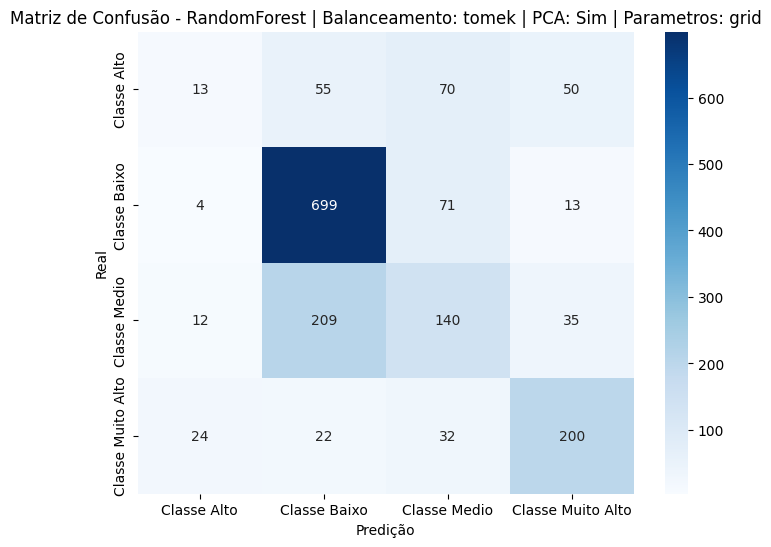


Relatório de Classificação para RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.07      0.11       188
     Classe Baixo       0.71      0.89      0.79       787
     Classe Medio       0.45      0.35      0.39       396
Classe Muito Alto       0.67      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.52      0.51      0.50      1649
     weighted avg       0.59      0.64      0.60      1649

Tempo de treinamento: 36.8173 segundos
📌 Melhores parâmetros encontrados para RandomForest:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

==================== SVM ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


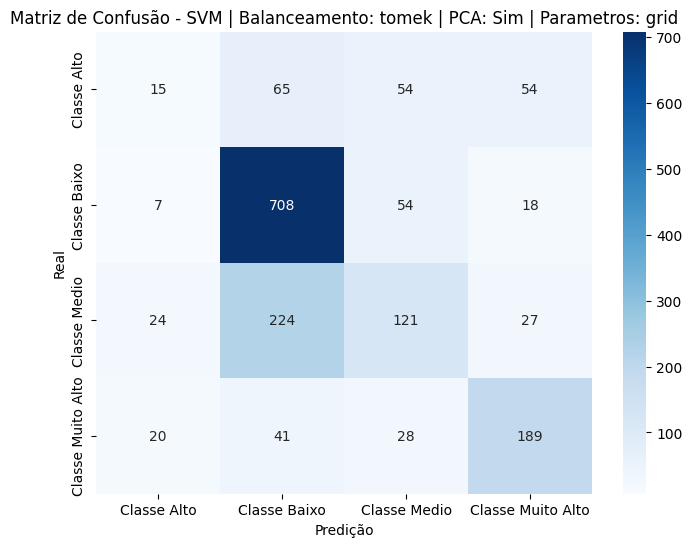


Relatório de Classificação para SVM | Balanceamento: tomek | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.23      0.08      0.12       188
     Classe Baixo       0.68      0.90      0.78       787
     Classe Medio       0.47      0.31      0.37       396
Classe Muito Alto       0.66      0.68      0.67       278

         accuracy                           0.63      1649
        macro avg       0.51      0.49      0.48      1649
     weighted avg       0.58      0.63      0.59      1649

Tempo de treinamento: 7.8652 segundos
📌 Melhores parâmetros encontrados para SVM:
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

==================== KNN ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:953: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 942, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 308, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_sc

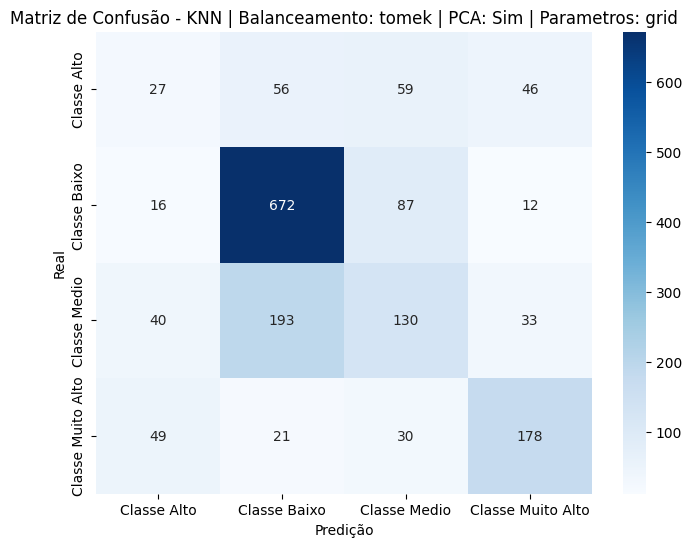


Relatório de Classificação para KNN | Balanceamento: tomek | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.14      0.17       188
     Classe Baixo       0.71      0.85      0.78       787
     Classe Medio       0.42      0.33      0.37       396
Classe Muito Alto       0.66      0.64      0.65       278

         accuracy                           0.61      1649
        macro avg       0.50      0.49      0.49      1649
     weighted avg       0.58      0.61      0.59      1649

Tempo de treinamento: 0.8084 segundos
📌 Melhores parâmetros encontrados para KNN:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

==================== DecisionTree ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


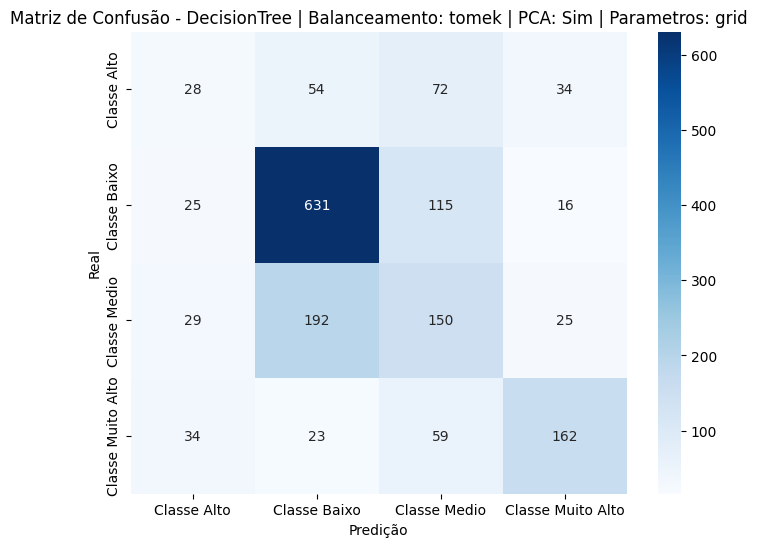


Relatório de Classificação para DecisionTree | Balanceamento: tomek | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.24      0.15      0.18       188
     Classe Baixo       0.70      0.80      0.75       787
     Classe Medio       0.38      0.38      0.38       396
Classe Muito Alto       0.68      0.58      0.63       278

         accuracy                           0.59      1649
        macro avg       0.50      0.48      0.49      1649
     weighted avg       0.57      0.59      0.58      1649

Tempo de treinamento: 1.9546 segundos
📌 Melhores parâmetros encontrados para DecisionTree:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}

==================== NeuralNetwork ====================
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/sit

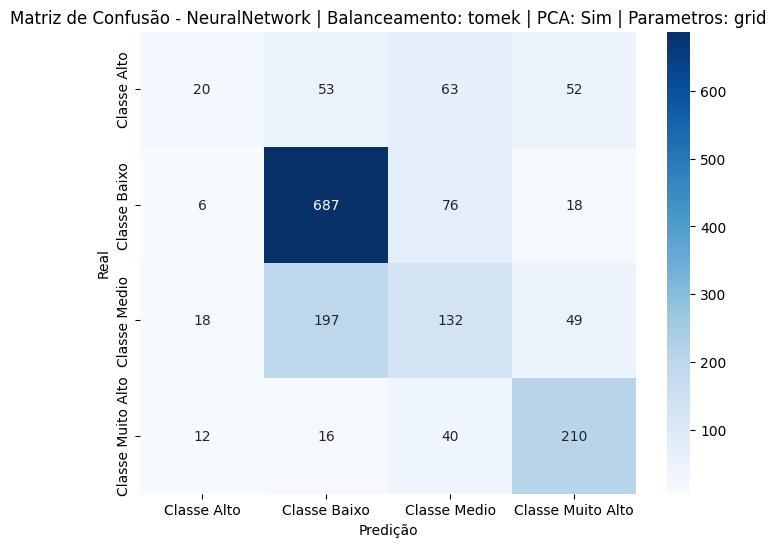


Relatório de Classificação para NeuralNetwork | Balanceamento: tomek | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.36      0.11      0.16       188
     Classe Baixo       0.72      0.87      0.79       787
     Classe Medio       0.42      0.33      0.37       396
Classe Muito Alto       0.64      0.76      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.52      0.50      1649
     weighted avg       0.59      0.64      0.60      1649

Tempo de treinamento: 9.8324 segundos
📌 Melhores parâmetros encontrados para NeuralNetwork:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}

==================== NaiveBayes ====================


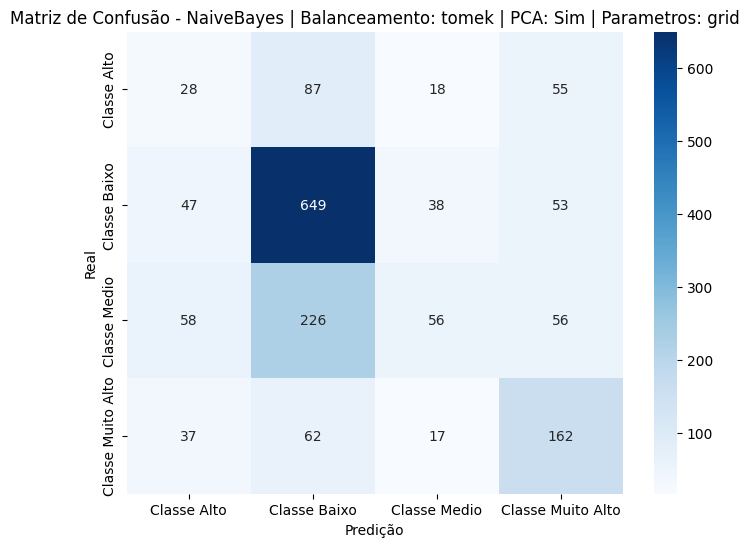


Relatório de Classificação para NaiveBayes | Balanceamento: tomek | PCA: Sim | Parametros: grid:
                   precision    recall  f1-score   support

      Classe Alto       0.16      0.15      0.16       188
     Classe Baixo       0.63      0.82      0.72       787
     Classe Medio       0.43      0.14      0.21       396
Classe Muito Alto       0.50      0.58      0.54       278

         accuracy                           0.54      1649
        macro avg       0.43      0.42      0.41      1649
     weighted avg       0.51      0.54      0.50      1649

Tempo de treinamento: 0.0097 segundos


Modelo  Acurácia Teste  \
1  RandomForest | Balanceamento: tomek | PCA: Sim...        0.637962   
5  NeuralNetwork | Balanceamento: tomek | PCA: Si...        0.636143   
2  SVM | Balanceamento: tomek | PCA: Sim | Parame...        0.626440   
0  LogisticRegression | Balanceamento: tomek | PC...        0.624621   
3  KNN | Balanceamento: tomek | PCA: Sim | Parame...        0.610673   
4  DecisionTree | Balanceamento: tomek | PCA: Sim...        0.588842   
6  NaiveBayes | Balanceamento: tomek | PCA: Sim |...        0.542753   

   Tempo Treinamento (s)                                Melhores Parâmetros  
1              36.817311  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
5               9.832359  {'activation': 'tanh', 'alpha': 0.0001, 'hidde...  
2               7.865198    {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}  
0               1.616282  {'C': 10.0, 'max_iter': 500, 'solver': 'liblin...  
3               0.808442  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...  
4               1.954643  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
6               0.009708                                                N/A

✨ Melhor modelo salvo: RandomForest com acurácia de 0.6380!
Evaluating scenario: default


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for default: 0.6531231049120679
Evaluating scenario: default + SMOTE


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for default + SMOTE: 0.6531231049120679
Evaluating scenario: default + Tomek


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for default + Tomek: 0.6531231049120679
Evaluating scenario: default + PCA + SMOTE


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for default + PCA + SMOTE: 0.6531231049120679
Evaluating scenario: default + PCA + Tomek
Score for default + PCA + Tomek: 0.6422073984232869
Evaluating scenario: grid
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Score for grid: 0.6513038204972711
Evaluating scenario: grid + SMOTE
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Score for grid + SMOTE: 0.6513038204972711
Evaluating scenario: grid + Tomek
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Score for grid + Tomek: 0.6513038204972711
Evaluating scenario: grid + PCA + SMOTE
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/sit

Score for grid + PCA + SMOTE: 0.645239539114615
Evaluating scenario: grid + PCA + Tomek
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Score for grid + PCA + Tomek: 0.6228016979987872


In [45]:
# Example usage of the treinar_modelos function
scenarios = []

# Default Parameters
scenarios.append(("default", treinar_modelos()))
scenarios.append(("default + SMOTE", treinar_modelos(balanceamento="smote")))
scenarios.append(("default + Tomek", treinar_modelos(balanceamento="tomek")))
scenarios.append(("default + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True)))
scenarios.append(("default + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True)))

# # GridSearch
scenarios.append(("grid", treinar_modelos(tipo_parametros="grid")))
scenarios.append(("grid + SMOTE", treinar_modelos(balanceamento="smote", tipo_parametros="grid")))
scenarios.append(("grid + Tomek", treinar_modelos(balanceamento="tomek", tipo_parametros="grid")))
scenarios.append(("grid + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True, tipo_parametros="grid")))
scenarios.append(("grid + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True, tipo_parametros="grid")))

# # Best Parameters
# scenarios.append(("best", treinar_modelos(tipo_parametros="best")))
# scenarios.append(("best + SMOTE", treinar_modelos(balanceamento="smote", tipo_parametros="best")))
# scenarios.append(("best + Tomek", treinar_modelos(balanceamento="tomek", tipo_parametros="best")))
# scenarios.append(("best + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True, tipo_parametros="best")))
# scenarios.append(("best + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True, tipo_parametros="best")))

# Iterate through scenarios and evaluate
for name, pipeline in scenarios:
    print(f"Evaluating scenario: {name}")
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"Score for {name}: {score}")

Cenarios

In [46]:
df_resultados_globais = pd.DataFrame(resultados_global)
df_resultados_globais.head()

Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: Nenhum | P...        0.653123   
1  RandomForest | Balanceamento: Nenhum | PCA: Nã...        0.601577   
2  SVM | Balanceamento: Nenhum | PCA: Não | Param...        0.642207   
3  KNN | Balanceamento: Nenhum | PCA: Não | Param...        0.593087   
4  DecisionTree | Balanceamento: Nenhum | PCA: Nã...        0.584597   

   Tempo Treinamento (s) Melhores Parâmetros  
0               0.892039                 N/A  
1               3.614778                 N/A  
2              17.994667                 N/A  
3               0.007397                 N/A  
4               0.429140                 N/A

In [47]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def treinar_modelos(balanceamento=None, usar_pca=False, tipo_parametros='default', salvar_parametros=True):

    resultados = []
    models_best_parameters = {}

    # Variáveis para armazenar o melhor modelo
    melhor_pipeline = None
    nome_melhor_modelo = ""
    melhor_score = 0.0
    # Aplicar balanceamento, se necessário
    if balanceamento == "SMOTE":
        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    elif balanceamento == "TomekLinks":
        tml = TomekLinks()
        X_train_bal, y_train_bal = tml.fit_resample(X_train, y_train)
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Aplicar PCA, se necessário
    if usar_pca:
        pca = PCA(n_components=100)
        X_train_bal = pca.fit_transform(X_train_bal)
        X_test_pca = pca.transform(X_test)
    else:
        X_test_pca = X_test

    # Loop para treinar os modelos
    for name, model in best_models.items():
        param_file = f"/content/dados/parametros_{name}.pkl"
        if os.path.exists(param_file):
            models_best_parameters[name] = joblib.load(param_file)

        descricao_cenario = (
            f"{name} | Balanceamento: {balanceamento if balanceamento else 'Nenhum'} "
            f"| PCA: {'Sim' if usar_pca else 'Não'} | Parametros: {tipo_parametros}"
        )

        print(f"\n==================== {name} ====================")

        # Condicional para NaiveBayes (sem GridSearch)
        if tipo_parametros == "default" or name == "NaiveBayes":
            grid_search = model
        elif tipo_parametros == "grid":
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=5,
                n_jobs=-1,
                scoring='accuracy',
                verbose=1
            )
        elif tipo_parametros == "best":
            if name in models_best_parameters:
                grid_search = model.set_params(**models_best_parameters[name])
            else:
                print(f"Atenção ⚠️: Não encontrei parâmetros salvos para {name}, usando default.")
                grid_search = model

        # Treinamento com medição de tempo
        inicio = time.time()
        grid_search.fit(X_train_bal, y_train_bal)
        fim = time.time()
        tempo_treino = fim - inicio

        # Previsões
        y_pred_test = grid_search.predict(X_test_pca)
        acc_test = accuracy_score(y_test, y_pred_test)

        # Atualizar melhor modelo
        if acc_test > melhor_score:
            print(f"✨ Novo melhor modelo encontrado: {descricao_cenario} com acurácia de {acc_test:.4f}!")
            melhor_score = acc_test
            melhor_pipeline = grid_search
            nome_melhor_modelo = name

        # Classes dinâmicas
        classes = unique_labels(y_test, y_pred_test)
        target_names = [f"Classe {c}" for c in classes]

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred_test, labels=classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confusão - {descricao_cenario}')
        plt.show()

        # Relatório de classificação
        print(f"\nRelatório de Classificação para {descricao_cenario}:")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")

        # Salvar resultados
        if name != "NaiveBayes":
            if tipo_parametros == "grid":
                best_params = grid_search.best_params_
                print(f"📌 Melhores parâmetros encontrados para {name}:")
                print(grid_search.best_params_)
            elif tipo_parametros == "best":
                best_params = models_best_parameters.get(name, "N/A")
            else:
                best_params = "N/A"

            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": best_params
            })

            # Salvar parâmetros apenas se for grid
            if salvar_parametros and tipo_parametros == "grid":
                joblib.dump(grid_search.best_params_, f'/parametros_{name}.pkl')
        else:
            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": "N/A"
            })

        print("=" * 52)

    # Comparação final
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="Acurácia Teste", ascending=False))

    resultados_global.extend(resultados)

    # Salvar o melhor modelo
    joblib.dump(melhor_pipeline, f'/ dados/{nome_melhor_modelo}_melhor_modelo.pkl')
    print(f"✨ Melhor modelo salvo: {nome_melhor_modelo} com acurácia de {melhor_score:.4f}!")

    # RETORNA o melhor modelo treinado
    return melhor_pipeline


In [48]:
df_resultados_globais = pd.DataFrame(resultados_global)
df_resultados_globais.head()

df_resultados_globais.to_csv("resultados_globais.csv", index=False)

print("Arquivo 'resultados_globais.csv' salvo com sucesso!")

Arquivo 'resultados_globais.csv' salvo com sucesso!


In [49]:
import pandas as pd

# Garantir que tipo_parametros já está extraído
df_resultados_globais["tipo_parametros"] = df_resultados_globais["Modelo"].str.extract(r"Parametros: (\w+)")

# Filtrar apenas os modelos com grid
df_filtrado = df_resultados_globais[df_resultados_globais["tipo_parametros"] == "grid"]

# Extrair o nome base do modelo (primeira parte antes do "|")
df_filtrado["ModeloBase"] = df_filtrado["Modelo"].str.split("|").str[0].str.strip()

# Agora, pegar o melhor por cada modelo base
melhores_por_modelo = df_filtrado.loc[
    df_filtrado.groupby("ModeloBase")["Acurácia Teste"].idxmax()
]

print("Melhor parâmetro (grid) para cada modelo:")
print(melhores_por_modelo[["ModeloBase", "Acurácia Teste", "Melhores Parâmetros"]])
# Selecionar apenas as colunas que você quer salvar
df_to_save = melhores_por_modelo[["ModeloBase", "Acurácia Teste", "Melhores Parâmetros"]]

# Salvar em CSV
df_to_save.to_csv("melhores_modelos_grid.csv", index=False)

print("Arquivo 'melhores_modelos_grid.csv' salvo com sucesso!")

Melhor parâmetro (grid) para cada modelo:
            ModeloBase  Acurácia Teste  \
39        DecisionTree        0.599757   
59                 KNN        0.614312   
35  LogisticRegression        0.651304   
69          NaiveBayes        0.542753   
61       NeuralNetwork        0.650697   
64        RandomForest        0.637962   
37                 SVM        0.642814   

                                  Melhores Parâmetros  
39  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
59  {'metric': 'manhattan', 'n_neighbors': 7, 'wei...  
35     {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}  
69                                                N/A  
61  {'activation': 'tanh', 'alpha': 0.0001, 'hidde...  
64  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
37     {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}  
Arquivo 'melhores_modelos_grid.csv' salvo com sucesso!


/tmp/ipykernel_2915397/867929677.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["ModeloBase"] = df_filtrado["Modelo"].str.split("|").str[0].str.strip()


In [50]:
best_params_dict = dict(zip(melhores_por_modelo["ModeloBase"], melhores_por_modelo["Melhores Parâmetros"]))
print(best_params_dict)

{'DecisionTree': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}, 'KNN': {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}, 'LogisticRegression': {'C': 1.0, 'max_iter': 500, 'solver': 'lbfgs'}, 'NaiveBayes': 'N/A', 'NeuralNetwork': {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}, 'RandomForest': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}, 'SVM': {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}}


In [51]:
best_params_dict = dict(zip(melhores_por_modelo["ModeloBase"], melhores_por_modelo["Melhores Parâmetros"]))

best_params_cleaned = {
    modelo: params if isinstance(params, dict) else {}
    for modelo, params in best_params_dict.items()
}

best_models = {
    "LogisticRegression": LogisticRegression(**best_params_cleaned.get("LogisticRegression", {})),
    "RandomForest": RandomForestClassifier(**best_params_cleaned.get("RandomForest", {})),
    "SVM": SVC(**best_params_cleaned.get("SVM", {})),
    "KNN": KNeighborsClassifier(**best_params_cleaned.get("KNN", {})),
    "DecisionTree": DecisionTreeClassifier(**best_params_cleaned.get("DecisionTree", {})),
    "NeuralNetwork": MLPClassifier(**best_params_cleaned.get("NeuralNetwork", {})),
    "NaiveBayes": GaussianNB(**best_params_cleaned.get("NaiveBayes", {})),
}


In [52]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def treinar_modelos(balanceamento=None, usar_pca=False, tipo_parametros='default', salvar_parametros=True):

    resultados = []
    models_best_parameters = {}

    # Variáveis para armazenar o melhor modelo
    melhor_pipeline = None
    nome_melhor_modelo = ""
    melhor_score = 0.0
    # Aplicar balanceamento, se necessário
    if balanceamento == "SMOTE":
        sm = SMOTE(random_state=42)
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    elif balanceamento == "TomekLinks":
        tml = TomekLinks()
        X_train_bal, y_train_bal = tml.fit_resample(X_train, y_train)
    else:
        X_train_bal, y_train_bal = X_train, y_train

    # Aplicar PCA, se necessário
    if usar_pca:
        pca = PCA(n_components=100)
        X_train_bal = pca.fit_transform(X_train_bal)
        X_test_pca = pca.transform(X_test)
    else:
        X_test_pca = X_test

    # Loop para treinar os modelos
    for name, model in best_models.items():
        param_file = f"/content/dados/parametros_{name}.pkl"
        if os.path.exists(param_file):
            models_best_parameters[name] = joblib.load(param_file)

        descricao_cenario = (
            f"{name} | Balanceamento: {balanceamento if balanceamento else 'Nenhum'} "
            f"| PCA: {'Sim' if usar_pca else 'Não'} | Parametros: {tipo_parametros}"
        )

        print(f"\n==================== {name} ====================")

        # Condicional para NaiveBayes (sem GridSearch)
        if tipo_parametros == "default" or name == "NaiveBayes":
            grid_search = model
        elif tipo_parametros == "grid":
            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                cv=5,
                n_jobs=-1,
                scoring='accuracy',
                verbose=1
            )
        elif tipo_parametros == "best":
            if name in models_best_parameters:
                grid_search = model.set_params(**models_best_parameters[name])
            else:
                print(f"Atenção ⚠️: Não encontrei parâmetros salvos para {name}, usando default.")
                grid_search = model

        # Treinamento com medição de tempo
        inicio = time.time()
        grid_search.fit(X_train_bal, y_train_bal)
        fim = time.time()
        tempo_treino = fim - inicio

        # Previsões
        y_pred_test = grid_search.predict(X_test_pca)
        acc_test = accuracy_score(y_test, y_pred_test)

        # Atualizar melhor modelo
        if acc_test > melhor_score:
            print(f"✨ Novo melhor modelo encontrado: {descricao_cenario} com acurácia de {acc_test:.4f}!")
            melhor_score = acc_test
            melhor_pipeline = grid_search
            nome_melhor_modelo = name

        # Classes dinâmicas
        classes = unique_labels(y_test, y_pred_test)
        target_names = [f"Classe {c}" for c in classes]

        # Matriz de Confusão
        cm = confusion_matrix(y_test, y_pred_test, labels=classes)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.title(f'Matriz de Confusão - {descricao_cenario}')
        plt.show()

        # Relatório de classificação
        print(f"\nRelatório de Classificação para {descricao_cenario}:")
        print(classification_report(y_test, y_pred_test, target_names=target_names))
        print(f"Tempo de treinamento: {tempo_treino:.4f} segundos")

        # Salvar resultados
        if name != "NaiveBayes":
            if tipo_parametros == "grid":
                best_params = grid_search.best_params_
                print(f"📌 Melhores parâmetros encontrados para {name}:")
                print(grid_search.best_params_)
            elif tipo_parametros == "best":
                best_params = models_best_parameters.get(name, "N/A")
            else:
                best_params = "N/A"

            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": best_params
            })

            # Salvar parâmetros apenas se for grid
            if salvar_parametros and tipo_parametros == "grid":
                joblib.dump(grid_search.best_params_, f'/parametros_{name}.pkl')
        else:
            resultados.append({
                "Modelo": descricao_cenario,
                "Acurácia Teste": acc_test,
                "Tempo Treinamento (s)": tempo_treino,
                "Melhores Parâmetros": "N/A"
            })

        print("=" * 52)

    # Comparação final
    df_resultados = pd.DataFrame(resultados)
    display(df_resultados.sort_values(by="Acurácia Teste", ascending=False))

    resultados_global.extend(resultados)

    # Salvar o melhor modelo
    joblib.dump(melhor_pipeline, f'dados/{nome_melhor_modelo}_melhor_modelo.pkl')
    print(f"✨ Melhor modelo salvo: {nome_melhor_modelo} com acurácia de {melhor_score:.4f}!")

    # RETORNA o melhor modelo treinado
    return melhor_pipeline


#### Cenários com os melhores Parametro


==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: best com acurácia de 0.6513!


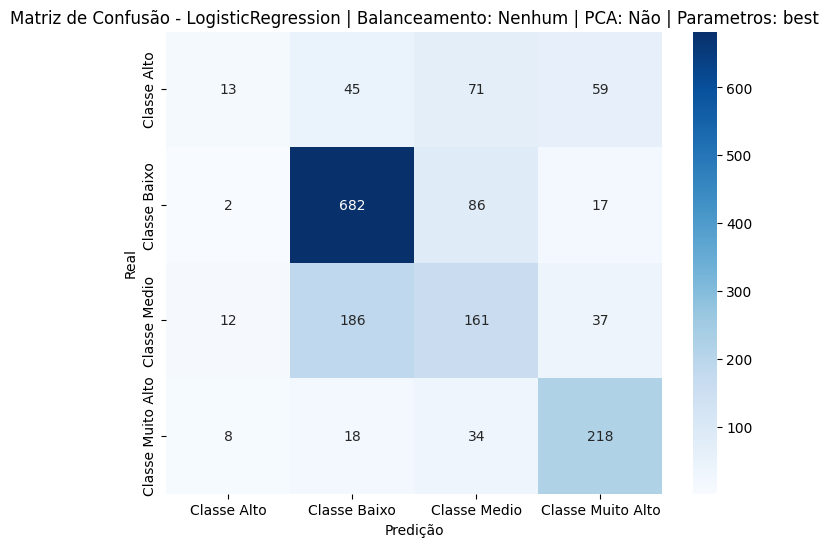


Relatório de Classificação para LogisticRegression | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 0.6935 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.


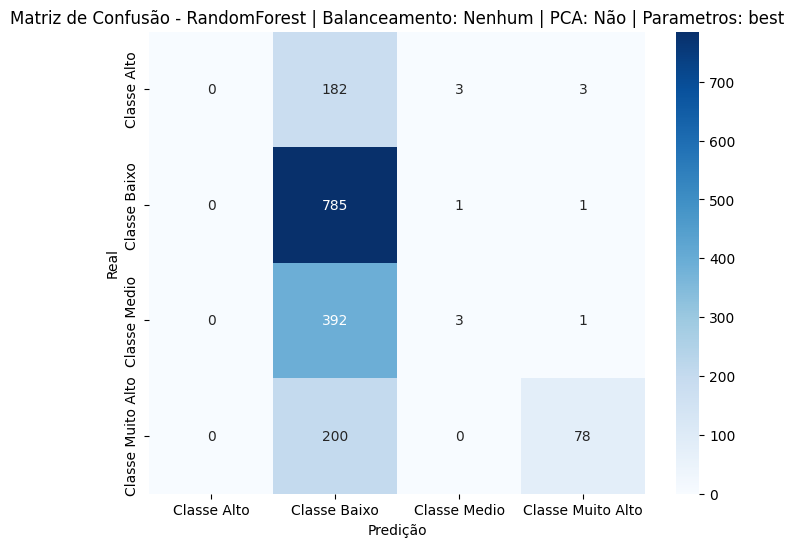


Relatório de Classificação para RandomForest | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.50      1.00      0.67       787
     Classe Medio       0.43      0.01      0.01       396
Classe Muito Alto       0.94      0.28      0.43       278

         accuracy                           0.53      1649
        macro avg       0.47      0.32      0.28      1649
     weighted avg       0.50      0.53      0.40      1649

Tempo de treinamento: 2.3431 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


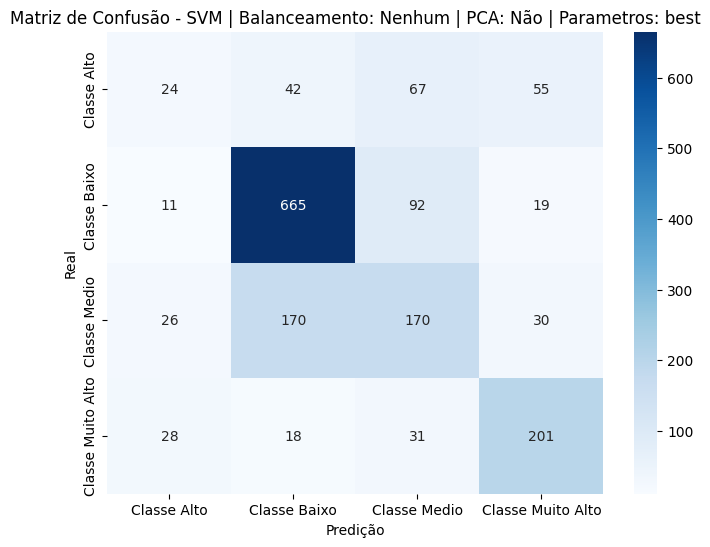


Relatório de Classificação para SVM | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 15.1749 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


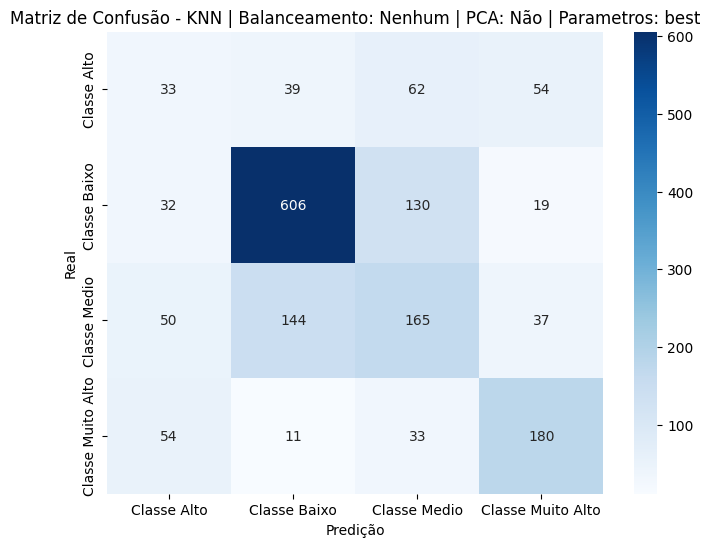


Relatório de Classificação para KNN | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.76       787
     Classe Medio       0.42      0.42      0.42       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.59      1649

Tempo de treinamento: 0.0070 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


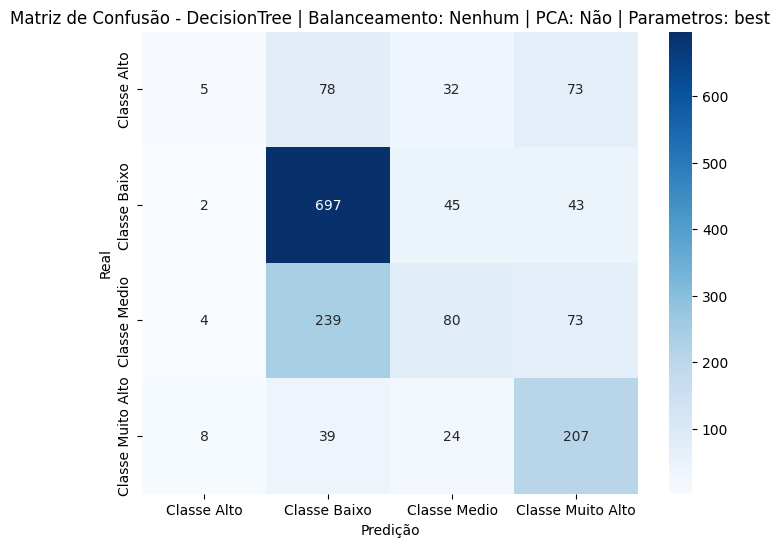


Relatório de Classificação para DecisionTree | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.89      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.61       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.1441 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


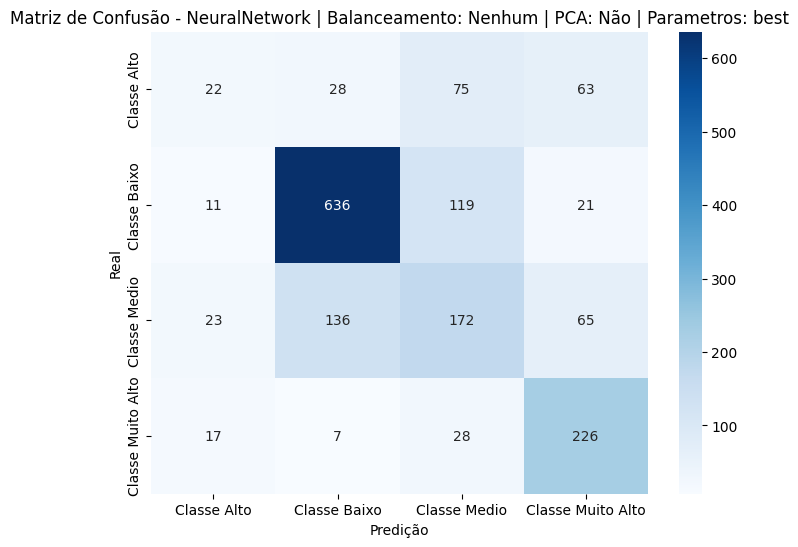


Relatório de Classificação para NeuralNetwork | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.30      0.12      0.17       188
     Classe Baixo       0.79      0.81      0.80       787
     Classe Medio       0.44      0.43      0.44       396
Classe Muito Alto       0.60      0.81      0.69       278

         accuracy                           0.64      1649
        macro avg       0.53      0.54      0.52      1649
     weighted avg       0.62      0.64      0.62      1649

Tempo de treinamento: 12.6749 segundos

==================== NaiveBayes ====================


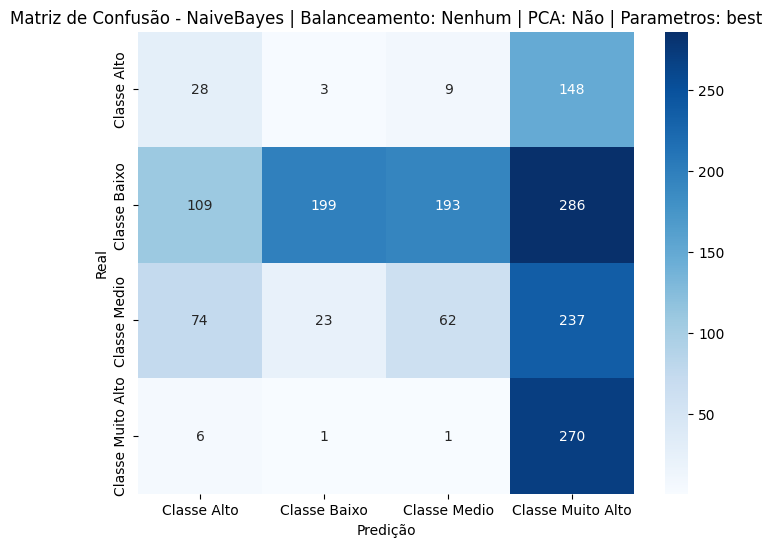


Relatório de Classificação para NaiveBayes | Balanceamento: Nenhum | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0515 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: Nenhum | P...        0.651304   
2  SVM | Balanceamento: Nenhum | PCA: Não | Param...        0.642814   
5  NeuralNetwork | Balanceamento: Nenhum | PCA: N...        0.640388   
4  DecisionTree | Balanceamento: Nenhum | PCA: Nã...        0.599757   
3  KNN | Balanceamento: Nenhum | PCA: Não | Param...        0.596725   
1  RandomForest | Balanceamento: Nenhum | PCA: Nã...        0.525167   
6  NaiveBayes | Balanceamento: Nenhum | PCA: Não ...        0.338993   

   Tempo Treinamento (s) Melhores Parâmetros  
0               0.693455                 N/A  
2              15.174905                 N/A  
5              12.674868                 N/A  
4               0.144115                 N/A  
3               0.007001                 N/A  
1               2.343135                 N/A  
6               0.051459                 N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Não | Parametros: best com acurácia de 0.6513!


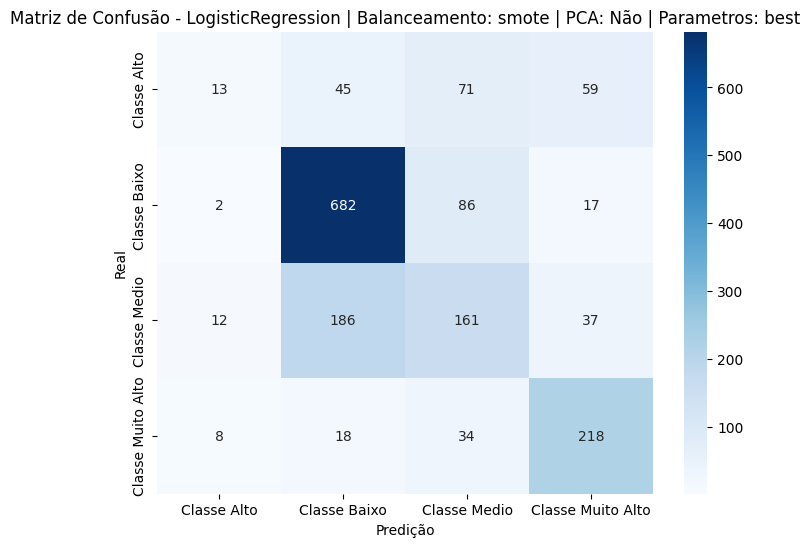


Relatório de Classificação para LogisticRegression | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 0.5830 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.


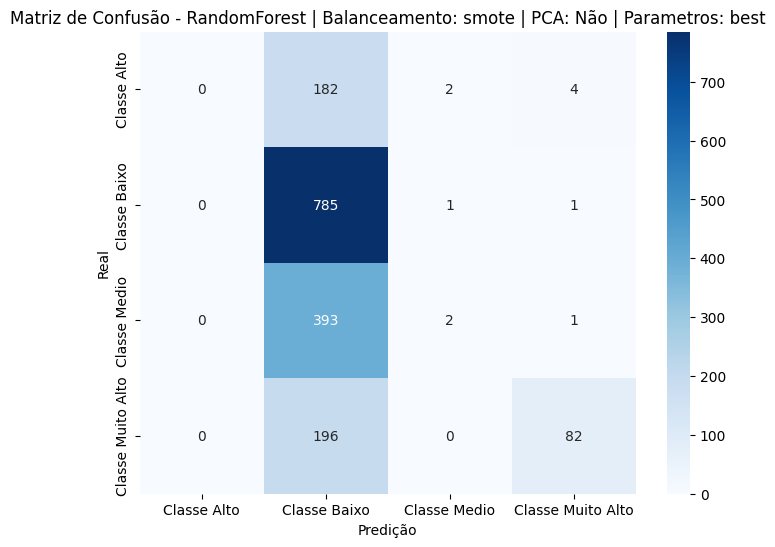


Relatório de Classificação para RandomForest | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.50      1.00      0.67       787
     Classe Medio       0.40      0.01      0.01       396
Classe Muito Alto       0.93      0.29      0.45       278

         accuracy                           0.53      1649
        macro avg       0.46      0.32      0.28      1649
     weighted avg       0.49      0.53      0.40      1649

Tempo de treinamento: 2.5021 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


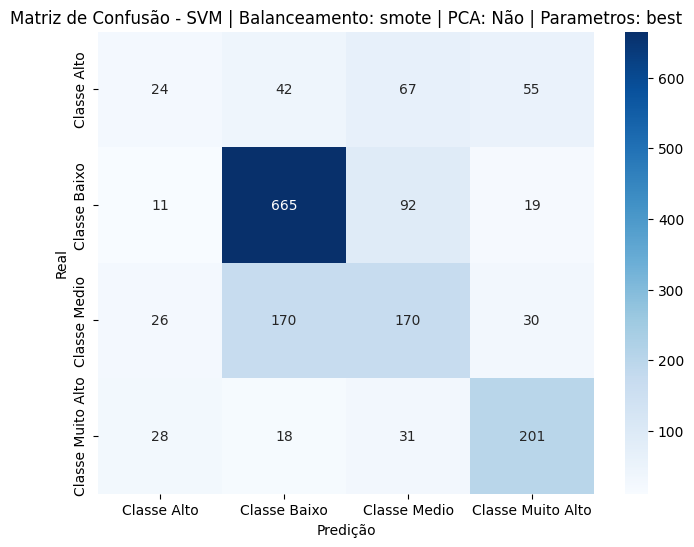


Relatório de Classificação para SVM | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 15.7453 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


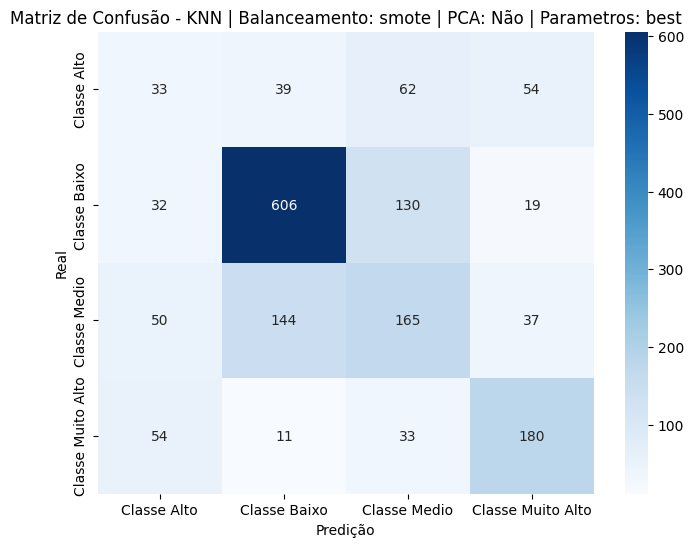


Relatório de Classificação para KNN | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.76       787
     Classe Medio       0.42      0.42      0.42       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.59      1649

Tempo de treinamento: 0.0067 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


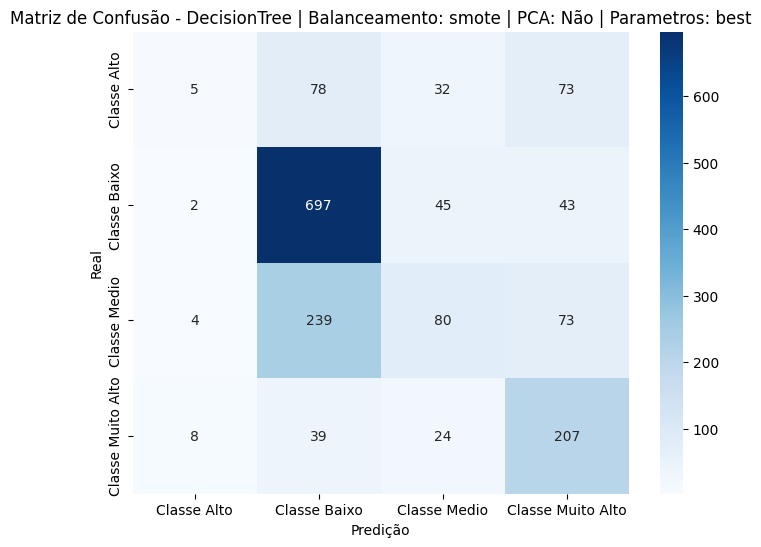


Relatório de Classificação para DecisionTree | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.89      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.52      0.74      0.61       278

         accuracy                           0.60      1649
        macro avg       0.47      0.46      0.42      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.1497 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


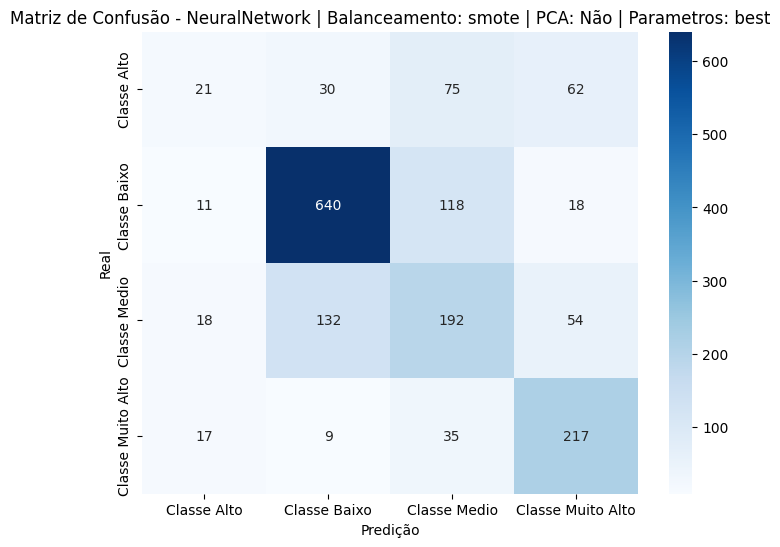


Relatório de Classificação para NeuralNetwork | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.31      0.11      0.16       188
     Classe Baixo       0.79      0.81      0.80       787
     Classe Medio       0.46      0.48      0.47       396
Classe Muito Alto       0.62      0.78      0.69       278

         accuracy                           0.65      1649
        macro avg       0.54      0.55      0.53      1649
     weighted avg       0.63      0.65      0.63      1649

Tempo de treinamento: 11.7318 segundos

==================== NaiveBayes ====================


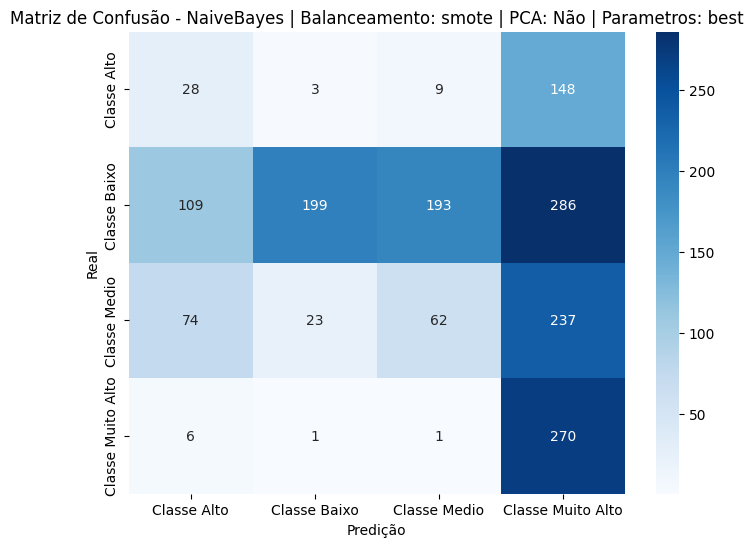


Relatório de Classificação para NaiveBayes | Balanceamento: smote | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0487 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: smote | PC...        0.651304   
5  NeuralNetwork | Balanceamento: smote | PCA: Nã...        0.648878   
2  SVM | Balanceamento: smote | PCA: Não | Parame...        0.642814   
4  DecisionTree | Balanceamento: smote | PCA: Não...        0.599757   
3  KNN | Balanceamento: smote | PCA: Não | Parame...        0.596725   
1  RandomForest | Balanceamento: smote | PCA: Não...        0.526986   
6  NaiveBayes | Balanceamento: smote | PCA: Não |...        0.338993   

   Tempo Treinamento (s) Melhores Parâmetros  
0               0.582985                 N/A  
5              11.731764                 N/A  
2              15.745343                 N/A  
4               0.149710                 N/A  
3               0.006741                 N/A  
1               2.502088                 N/A  
6               0.048703                 N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Não | Parametros: best com acurácia de 0.6513!


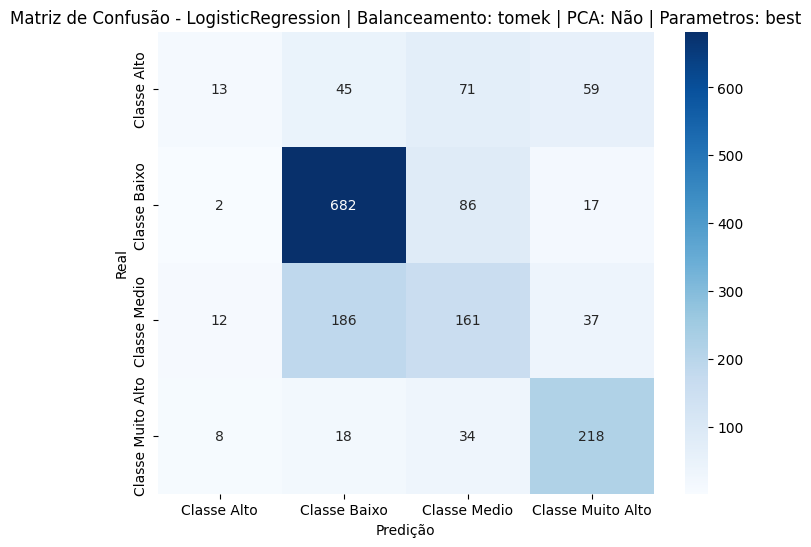


Relatório de Classificação para LogisticRegression | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.07      0.12       188
     Classe Baixo       0.73      0.87      0.79       787
     Classe Medio       0.46      0.41      0.43       396
Classe Muito Alto       0.66      0.78      0.72       278

         accuracy                           0.65      1649
        macro avg       0.55      0.53      0.51      1649
     weighted avg       0.61      0.65      0.62      1649

Tempo de treinamento: 0.8853 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.


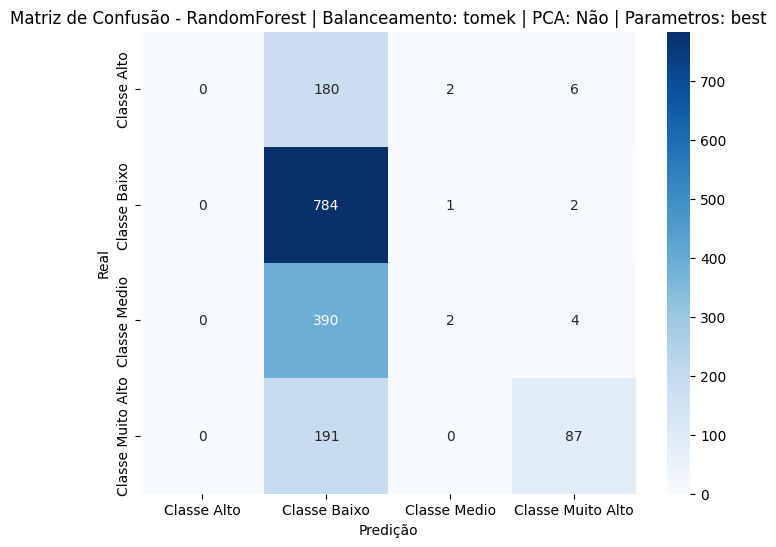


Relatório de Classificação para RandomForest | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.00      0.00      0.00       188
     Classe Baixo       0.51      1.00      0.67       787
     Classe Medio       0.40      0.01      0.01       396
Classe Muito Alto       0.88      0.31      0.46       278

         accuracy                           0.53      1649
        macro avg       0.45      0.33      0.29      1649
     weighted avg       0.49      0.53      0.40      1649

Tempo de treinamento: 2.3796 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


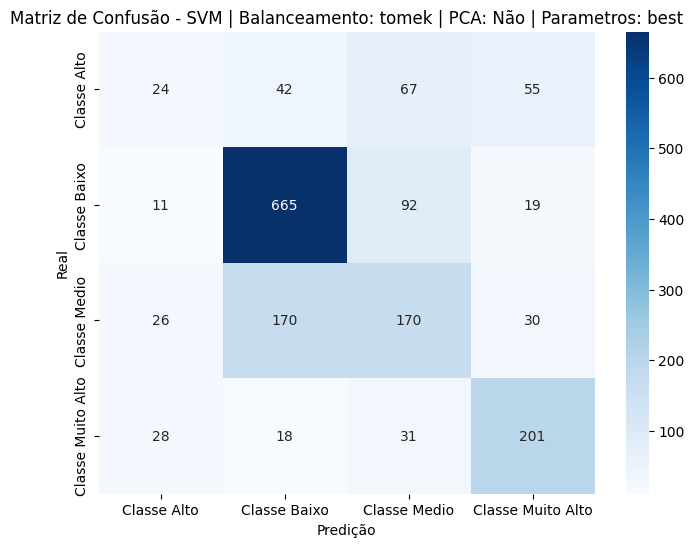


Relatório de Classificação para SVM | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.13      0.17       188
     Classe Baixo       0.74      0.84      0.79       787
     Classe Medio       0.47      0.43      0.45       396
Classe Muito Alto       0.66      0.72      0.69       278

         accuracy                           0.64      1649
        macro avg       0.54      0.53      0.53      1649
     weighted avg       0.61      0.64      0.62      1649

Tempo de treinamento: 14.6406 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


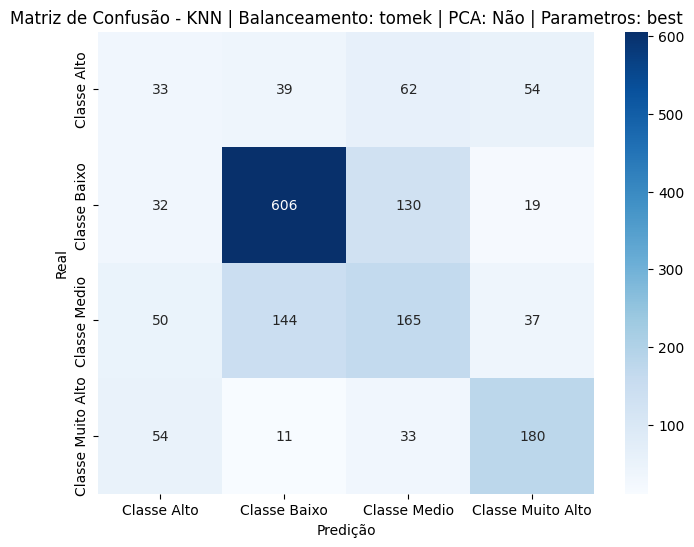


Relatório de Classificação para KNN | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.20      0.18      0.18       188
     Classe Baixo       0.76      0.77      0.76       787
     Classe Medio       0.42      0.42      0.42       396
Classe Muito Alto       0.62      0.65      0.63       278

         accuracy                           0.60      1649
        macro avg       0.50      0.50      0.50      1649
     weighted avg       0.59      0.60      0.59      1649

Tempo de treinamento: 0.0069 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


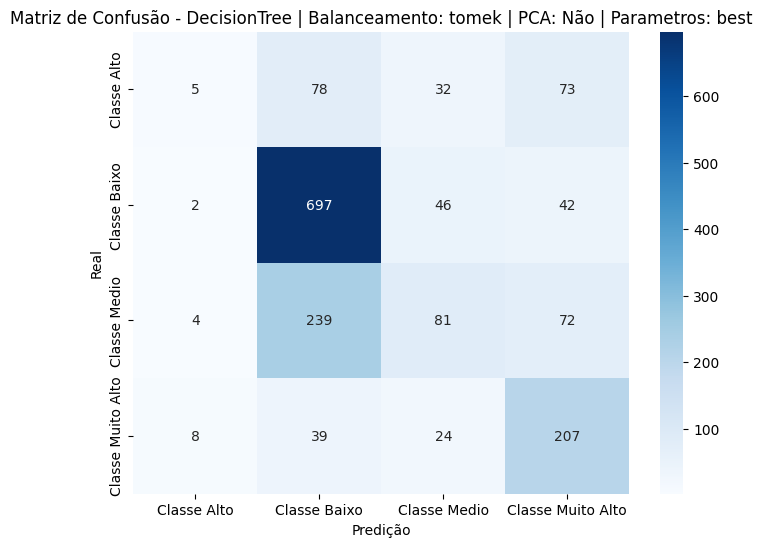


Relatório de Classificação para DecisionTree | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.26      0.03      0.05       188
     Classe Baixo       0.66      0.89      0.76       787
     Classe Medio       0.44      0.20      0.28       396
Classe Muito Alto       0.53      0.74      0.62       278

         accuracy                           0.60      1649
        macro avg       0.47      0.47      0.43      1649
     weighted avg       0.54      0.60      0.54      1649

Tempo de treinamento: 0.1428 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


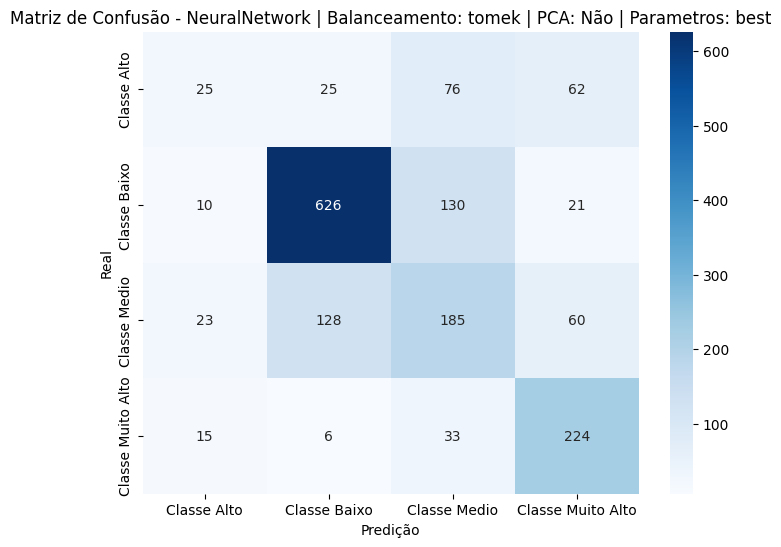


Relatório de Classificação para NeuralNetwork | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.34      0.13      0.19       188
     Classe Baixo       0.80      0.80      0.80       787
     Classe Medio       0.44      0.47      0.45       396
Classe Muito Alto       0.61      0.81      0.69       278

         accuracy                           0.64      1649
        macro avg       0.55      0.55      0.53      1649
     weighted avg       0.63      0.64      0.63      1649

Tempo de treinamento: 13.1361 segundos

==================== NaiveBayes ====================


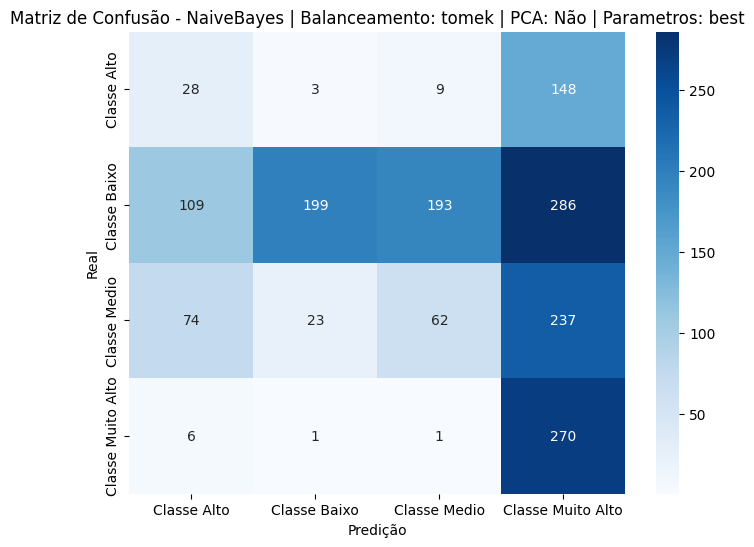


Relatório de Classificação para NaiveBayes | Balanceamento: tomek | PCA: Não | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.13      0.15      0.14       188
     Classe Baixo       0.88      0.25      0.39       787
     Classe Medio       0.23      0.16      0.19       396
Classe Muito Alto       0.29      0.97      0.44       278

         accuracy                           0.34      1649
        macro avg       0.38      0.38      0.29      1649
     weighted avg       0.54      0.34      0.32      1649

Tempo de treinamento: 0.0475 segundos


Modelo  Acurácia Teste  \
0  LogisticRegression | Balanceamento: tomek | PC...        0.651304   
2  SVM | Balanceamento: tomek | PCA: Não | Parame...        0.642814   
5  NeuralNetwork | Balanceamento: tomek | PCA: Nã...        0.642814   
4  DecisionTree | Balanceamento: tomek | PCA: Não...        0.600364   
3  KNN | Balanceamento: tomek | PCA: Não | Parame...        0.596725   
1  RandomForest | Balanceamento: tomek | PCA: Não...        0.529412   
6  NaiveBayes | Balanceamento: tomek | PCA: Não |...        0.338993   

   Tempo Treinamento (s) Melhores Parâmetros  
0               0.885260                 N/A  
2              14.640632                 N/A  
5              13.136096                 N/A  
4               0.142786                 N/A  
3               0.006916                 N/A  
1               2.379620                 N/A  
6               0.047547                 N/A

✨ Melhor modelo salvo: LogisticRegression com acurácia de 0.6513!

==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: best com acurácia de 0.6216!


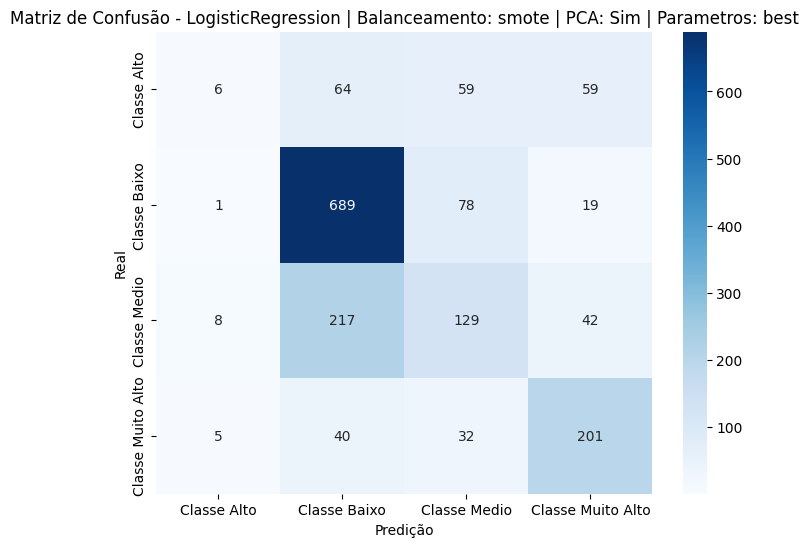


Relatório de Classificação para LogisticRegression | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.30      0.03      0.06       188
     Classe Baixo       0.68      0.88      0.77       787
     Classe Medio       0.43      0.33      0.37       396
Classe Muito Alto       0.63      0.72      0.67       278

         accuracy                           0.62      1649
        macro avg       0.51      0.49      0.47      1649
     weighted avg       0.57      0.62      0.57      1649

Tempo de treinamento: 0.1853 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.
✨ Novo melhor modelo encontrado: RandomForest | Balanceamento: smote | PCA: Sim | Parametros: best com acurácia de 0.6422!


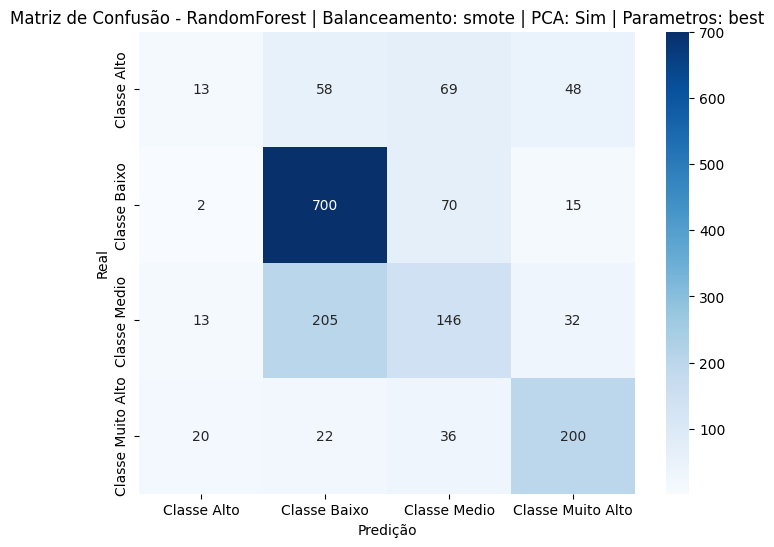


Relatório de Classificação para RandomForest | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.27      0.07      0.11       188
     Classe Baixo       0.71      0.89      0.79       787
     Classe Medio       0.45      0.37      0.41       396
Classe Muito Alto       0.68      0.72      0.70       278

         accuracy                           0.64      1649
        macro avg       0.53      0.51      0.50      1649
     weighted avg       0.59      0.64      0.61      1649

Tempo de treinamento: 15.7095 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


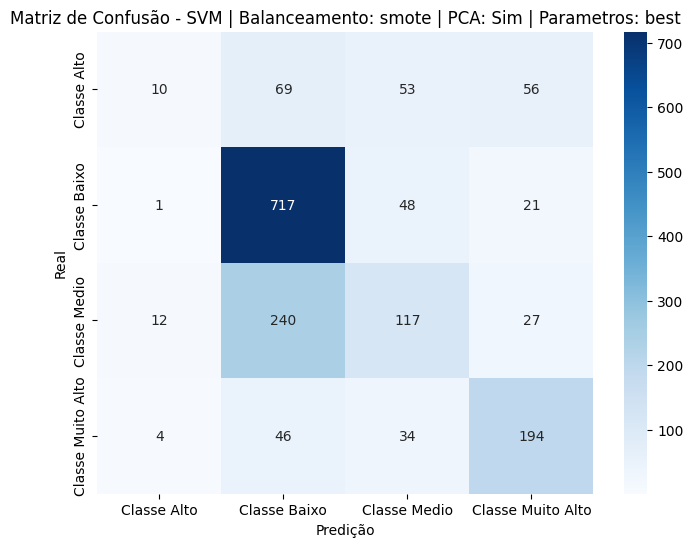


Relatório de Classificação para SVM | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.37      0.05      0.09       188
     Classe Baixo       0.67      0.91      0.77       787
     Classe Medio       0.46      0.30      0.36       396
Classe Muito Alto       0.65      0.70      0.67       278

         accuracy                           0.63      1649
        macro avg       0.54      0.49      0.47      1649
     weighted avg       0.58      0.63      0.58      1649

Tempo de treinamento: 1.6687 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


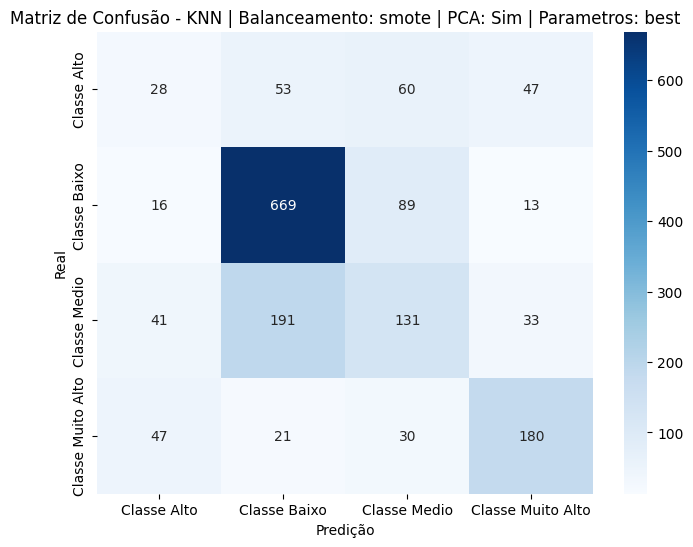


Relatório de Classificação para KNN | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.21      0.15      0.17       188
     Classe Baixo       0.72      0.85      0.78       787
     Classe Medio       0.42      0.33      0.37       396
Classe Muito Alto       0.66      0.65      0.65       278

         accuracy                           0.61      1649
        macro avg       0.50      0.49      0.49      1649
     weighted avg       0.58      0.61      0.59      1649

Tempo de treinamento: 0.0058 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


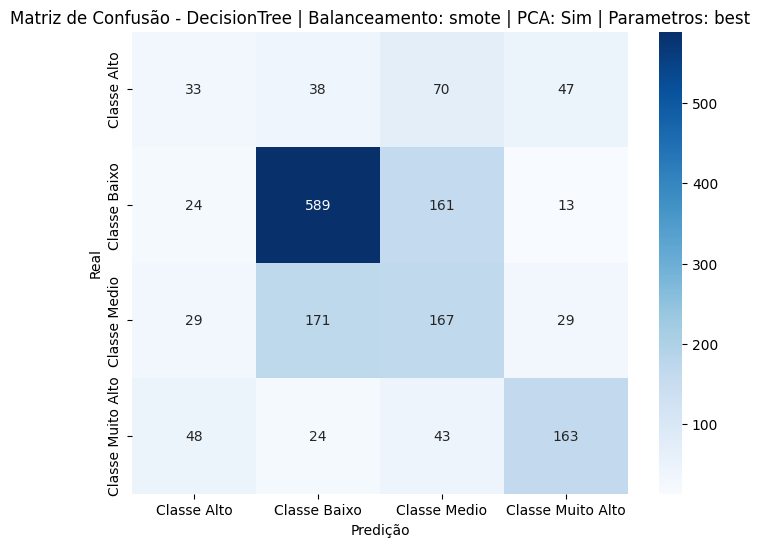


Relatório de Classificação para DecisionTree | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.25      0.18      0.20       188
     Classe Baixo       0.72      0.75      0.73       787
     Classe Medio       0.38      0.42      0.40       396
Classe Muito Alto       0.65      0.59      0.62       278

         accuracy                           0.58      1649
        macro avg       0.50      0.48      0.49      1649
     weighted avg       0.57      0.58      0.57      1649

Tempo de treinamento: 0.7772 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.
✨ Novo melhor modelo encontrado: NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: best com acurácia de 0.6428!


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


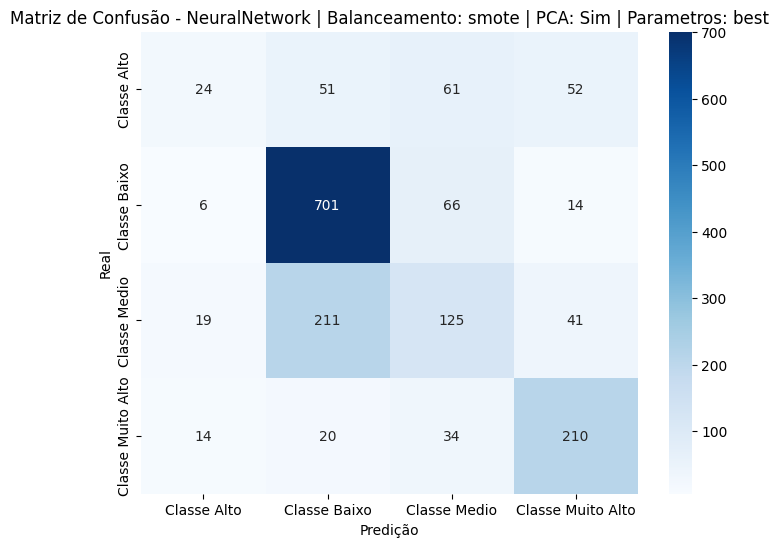


Relatório de Classificação para NeuralNetwork | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.38      0.13      0.19       188
     Classe Baixo       0.71      0.89      0.79       787
     Classe Medio       0.44      0.32      0.37       396
Classe Muito Alto       0.66      0.76      0.71       278

         accuracy                           0.64      1649
        macro avg       0.55      0.52      0.51      1649
     weighted avg       0.60      0.64      0.61      1649

Tempo de treinamento: 3.9927 segundos

==================== NaiveBayes ====================


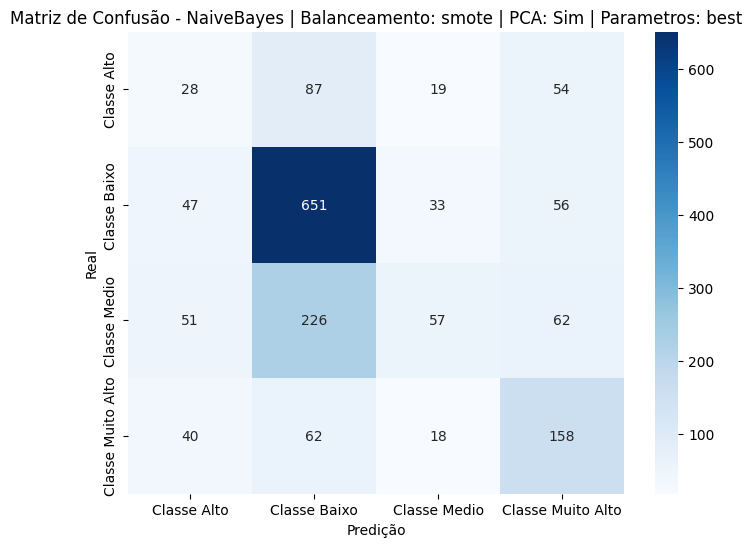


Relatório de Classificação para NaiveBayes | Balanceamento: smote | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.17      0.15      0.16       188
     Classe Baixo       0.63      0.83      0.72       787
     Classe Medio       0.45      0.14      0.22       396
Classe Muito Alto       0.48      0.57      0.52       278

         accuracy                           0.54      1649
        macro avg       0.43      0.42      0.40      1649
     weighted avg       0.51      0.54      0.50      1649

Tempo de treinamento: 0.0090 segundos


Modelo  Acurácia Teste  \
5  NeuralNetwork | Balanceamento: smote | PCA: Si...        0.642814   
1  RandomForest | Balanceamento: smote | PCA: Sim...        0.642207   
2  SVM | Balanceamento: smote | PCA: Sim | Parame...        0.629472   
0  LogisticRegression | Balanceamento: smote | PC...        0.621589   
3  KNN | Balanceamento: smote | PCA: Sim | Parame...        0.611280   
4  DecisionTree | Balanceamento: smote | PCA: Sim...        0.577320   
6  NaiveBayes | Balanceamento: smote | PCA: Sim |...        0.542147   

   Tempo Treinamento (s) Melhores Parâmetros  
5               3.992689                 N/A  
1              15.709461                 N/A  
2               1.668718                 N/A  
0               0.185334                 N/A  
3               0.005785                 N/A  
4               0.777194                 N/A  
6               0.009045                 N/A

✨ Melhor modelo salvo: NeuralNetwork com acurácia de 0.6428!

==================== LogisticRegression ====================
Atenção ⚠️: Não encontrei parâmetros salvos para LogisticRegression, usando default.
✨ Novo melhor modelo encontrado: LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: best com acurácia de 0.6240!


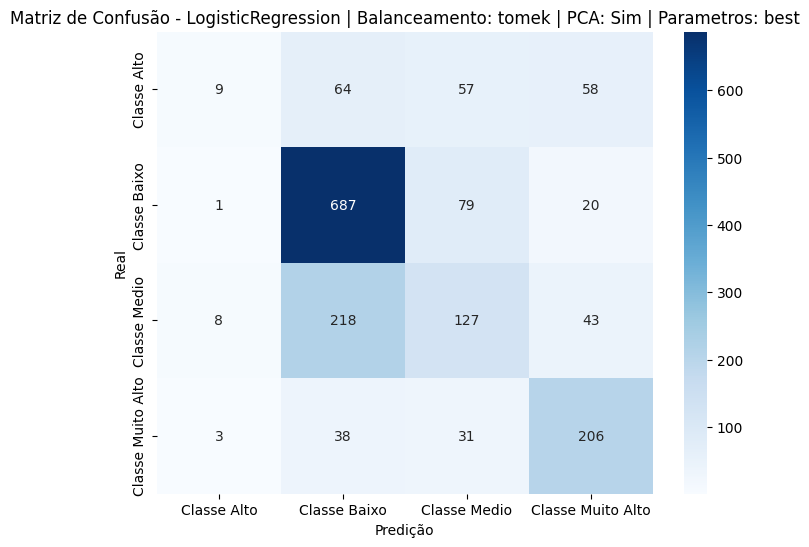


Relatório de Classificação para LogisticRegression | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.43      0.05      0.09       188
     Classe Baixo       0.68      0.87      0.77       787
     Classe Medio       0.43      0.32      0.37       396
Classe Muito Alto       0.63      0.74      0.68       278

         accuracy                           0.62      1649
        macro avg       0.54      0.50      0.48      1649
     weighted avg       0.58      0.62      0.58      1649

Tempo de treinamento: 0.1401 segundos

==================== RandomForest ====================
Atenção ⚠️: Não encontrei parâmetros salvos para RandomForest, usando default.
✨ Novo melhor modelo encontrado: RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: best com acurácia de 0.6404!


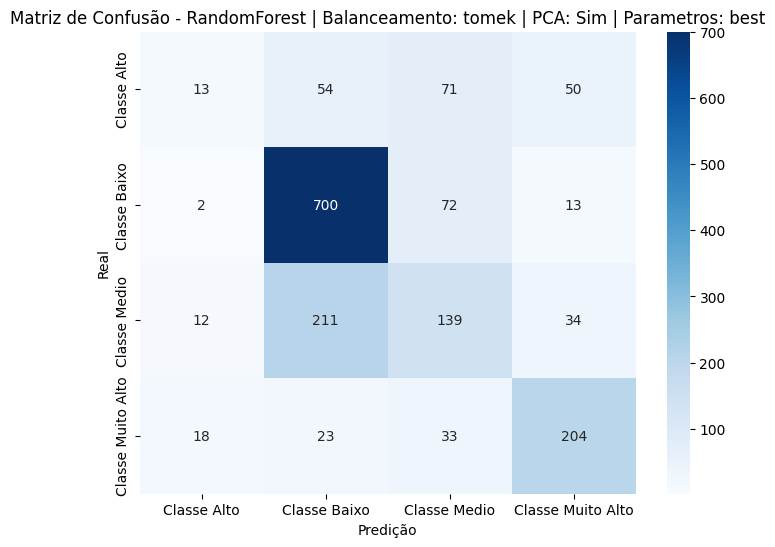


Relatório de Classificação para RandomForest | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.29      0.07      0.11       188
     Classe Baixo       0.71      0.89      0.79       787
     Classe Medio       0.44      0.35      0.39       396
Classe Muito Alto       0.68      0.73      0.70       278

         accuracy                           0.64      1649
        macro avg       0.53      0.51      0.50      1649
     weighted avg       0.59      0.64      0.60      1649

Tempo de treinamento: 15.6958 segundos

==================== SVM ====================
Atenção ⚠️: Não encontrei parâmetros salvos para SVM, usando default.


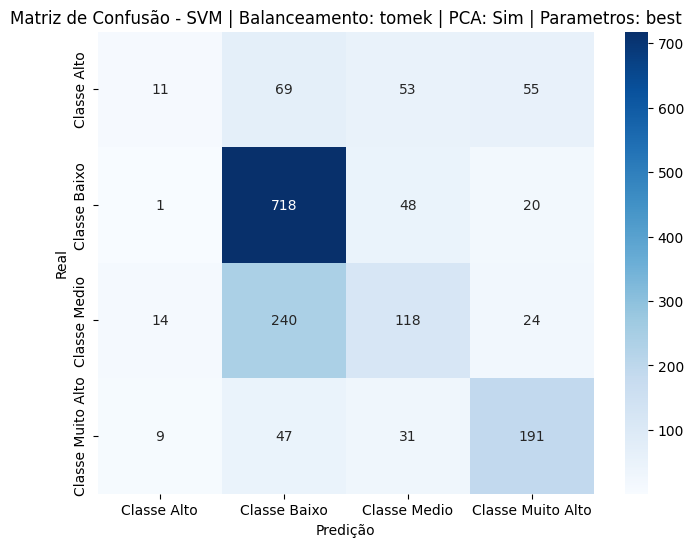


Relatório de Classificação para SVM | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.31      0.06      0.10       188
     Classe Baixo       0.67      0.91      0.77       787
     Classe Medio       0.47      0.30      0.37       396
Classe Muito Alto       0.66      0.69      0.67       278

         accuracy                           0.63      1649
        macro avg       0.53      0.49      0.48      1649
     weighted avg       0.58      0.63      0.58      1649

Tempo de treinamento: 1.7287 segundos

==================== KNN ====================
Atenção ⚠️: Não encontrei parâmetros salvos para KNN, usando default.


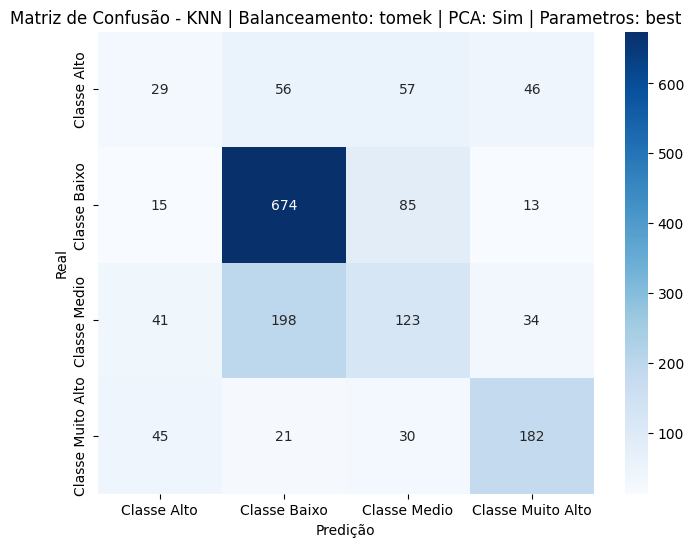


Relatório de Classificação para KNN | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.22      0.15      0.18       188
     Classe Baixo       0.71      0.86      0.78       787
     Classe Medio       0.42      0.31      0.36       396
Classe Muito Alto       0.66      0.65      0.66       278

         accuracy                           0.61      1649
        macro avg       0.50      0.49      0.49      1649
     weighted avg       0.58      0.61      0.59      1649

Tempo de treinamento: 0.0055 segundos

==================== DecisionTree ====================
Atenção ⚠️: Não encontrei parâmetros salvos para DecisionTree, usando default.


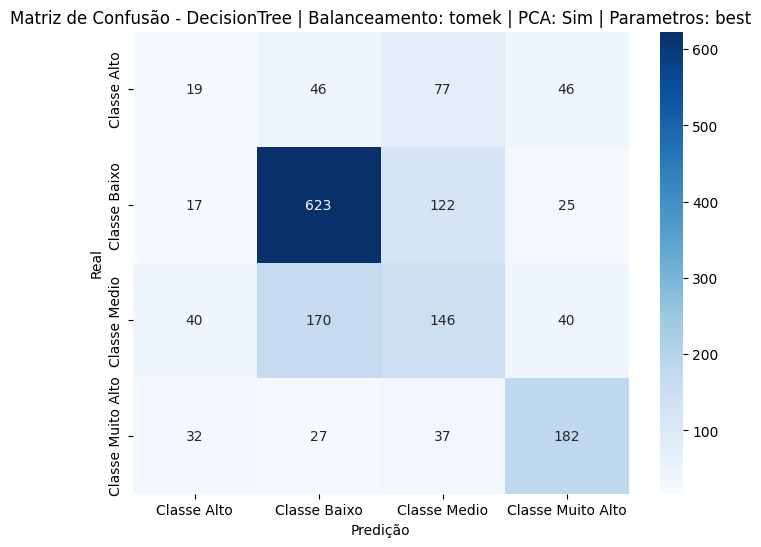


Relatório de Classificação para DecisionTree | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.18      0.10      0.13       188
     Classe Baixo       0.72      0.79      0.75       787
     Classe Medio       0.38      0.37      0.38       396
Classe Muito Alto       0.62      0.65      0.64       278

         accuracy                           0.59      1649
        macro avg       0.47      0.48      0.47      1649
     weighted avg       0.56      0.59      0.57      1649

Tempo de treinamento: 0.7831 segundos

==================== NeuralNetwork ====================
Atenção ⚠️: Não encontrei parâmetros salvos para NeuralNetwork, usando default.
✨ Novo melhor modelo encontrado: NeuralNetwork | Balanceamento: tomek | PCA: Sim | Parametros: best com acurácia de 0.6428!


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


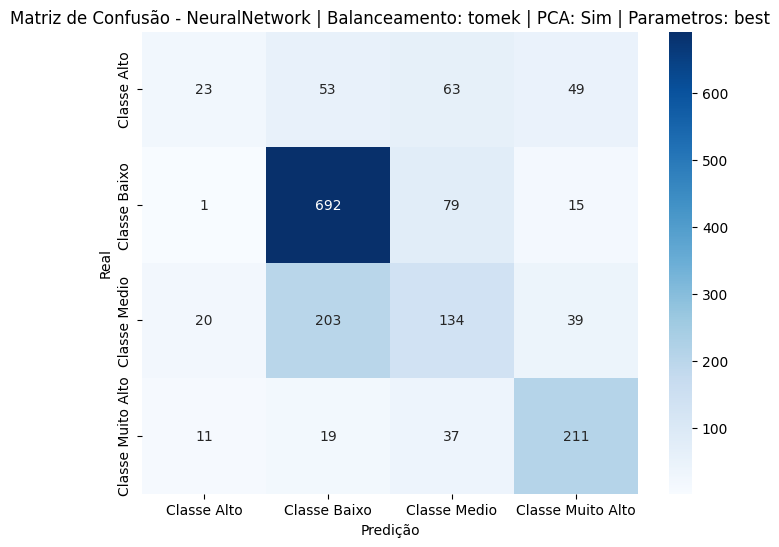


Relatório de Classificação para NeuralNetwork | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.42      0.12      0.19       188
     Classe Baixo       0.72      0.88      0.79       787
     Classe Medio       0.43      0.34      0.38       396
Classe Muito Alto       0.67      0.76      0.71       278

         accuracy                           0.64      1649
        macro avg       0.56      0.52      0.52      1649
     weighted avg       0.61      0.64      0.61      1649

Tempo de treinamento: 4.0118 segundos

==================== NaiveBayes ====================


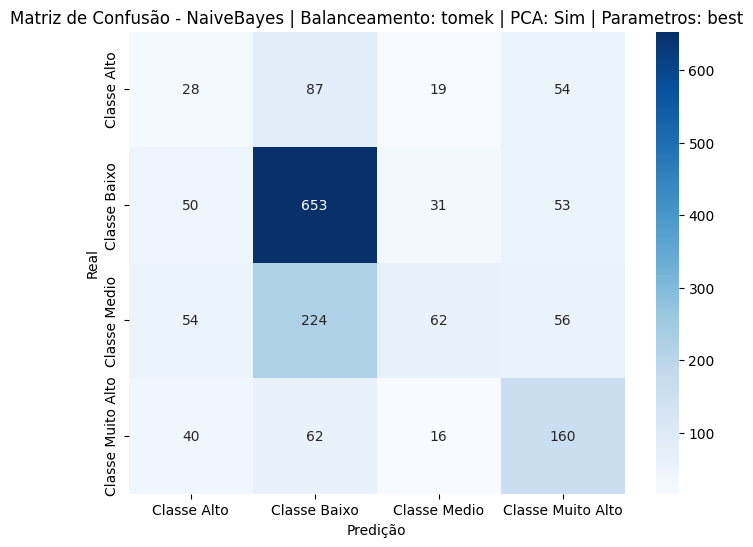


Relatório de Classificação para NaiveBayes | Balanceamento: tomek | PCA: Sim | Parametros: best:
                   precision    recall  f1-score   support

      Classe Alto       0.16      0.15      0.16       188
     Classe Baixo       0.64      0.83      0.72       787
     Classe Medio       0.48      0.16      0.24       396
Classe Muito Alto       0.50      0.58      0.53       278

         accuracy                           0.55      1649
        macro avg       0.44      0.43      0.41      1649
     weighted avg       0.52      0.55      0.51      1649

Tempo de treinamento: 0.0097 segundos


Modelo  Acurácia Teste  \
5  NeuralNetwork | Balanceamento: tomek | PCA: Si...        0.642814   
1  RandomForest | Balanceamento: tomek | PCA: Sim...        0.640388   
2  SVM | Balanceamento: tomek | PCA: Sim | Parame...        0.629472   
0  LogisticRegression | Balanceamento: tomek | PC...        0.624015   
3  KNN | Balanceamento: tomek | PCA: Sim | Parame...        0.611280   
4  DecisionTree | Balanceamento: tomek | PCA: Sim...        0.588235   
6  NaiveBayes | Balanceamento: tomek | PCA: Sim |...        0.547605   

   Tempo Treinamento (s) Melhores Parâmetros  
5               4.011809                 N/A  
1              15.695821                 N/A  
2               1.728741                 N/A  
0               0.140135                 N/A  
3               0.005474                 N/A  
4               0.783142                 N/A  
6               0.009746                 N/A

✨ Melhor modelo salvo: NeuralNetwork com acurácia de 0.6428!
Evaluating scenario: default


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for default: 0.6531231049120679
Evaluating scenario: default + SMOTE


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for default + SMOTE: 0.6531231049120679
Evaluating scenario: default + Tomek


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for default + Tomek: 0.6531231049120679
Evaluating scenario: default + PCA + SMOTE


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score for default + PCA + SMOTE: 0.6531231049120679
Evaluating scenario: default + PCA + Tomek
Score for default + PCA + Tomek: 0.6422073984232869
Evaluating scenario: grid
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Score for grid: 0.6513038204972711
Evaluating scenario: grid + SMOTE
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Score for grid + SMOTE: 0.6513038204972711
Evaluating scenario: grid + Tomek
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Score for grid + Tomek: 0.6513038204972711
Evaluating scenario: grid + PCA + SMOTE
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/llmdom/tes/venv/lib/python3.13/sit

Score for grid + PCA + SMOTE: 0.6440266828380837
Evaluating scenario: grid + PCA + Tomek
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Score for grid + PCA + Tomek: 0.6288659793814433
Evaluating scenario: best
Score for best: 0.6513038204972711
Evaluating scenario: best + SMOTE
Score for best + SMOTE: 0.6513038204972711
Evaluating scenario: best + Tomek
Score for best + Tomek: 0.6513038204972711
Evaluating scenario: best + PCA + SMOTE


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Score for best + PCA + SMOTE: 0.6422073984232869
Evaluating scenario: best + PCA + Tomek
Score for best + PCA + Tomek: 0.6397816858702243


/home/llmdom/tes/venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [53]:
# # Best Parameters
scenarios.append(("best", treinar_modelos(tipo_parametros="best")))
scenarios.append(("best + SMOTE", treinar_modelos(balanceamento="smote", tipo_parametros="best")))
scenarios.append(("best + Tomek", treinar_modelos(balanceamento="tomek", tipo_parametros="best")))
scenarios.append(("best + PCA + SMOTE", treinar_modelos(balanceamento="smote", usar_pca=True, tipo_parametros="best")))
scenarios.append(("best + PCA + Tomek", treinar_modelos(balanceamento="tomek", usar_pca=True, tipo_parametros="best")))

# Iterate through scenarios and evaluate
for name, pipeline in scenarios:
    print(f"Evaluating scenario: {name}")
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"Score for {name}: {score}")

# Interface Grafica - Gradio

In [54]:
import gradio as gr
import joblib
import pandas as pd
import numpy as np

# Carregue o modelo e os pré-processadores
modelo = joblib.load("dados/LogisticRegression_melhor_modelo.pkl")
scaler_std = joblib.load("dados/scaler_std.pkl")
ohe_enc = joblib.load("dados/ohe_enc.pkl")


# Defina as features na ordem correta
num_features = ['area', 'bedrooms', 'garage']
cat_features = ['district', 'type']

def preprocess_input(area, bedrooms, garage, district, type_):
    # Crie DataFrame com as features na ordem correta
    data = pd.DataFrame([{
        'area': area,
        'bedrooms': bedrooms,
        'garage': garage,
        'district': district,
        'type': type_
    }])
    # Numéricas
    X_num = scaler_std.transform(data[num_features])
    # Categóricas
    X_cat = ohe_enc.transform(data[cat_features])
    # Junta tudo
    X_final = np.hstack([X_num, X_cat])
    return X_final

def predict(area, bedrooms, garage, district, type_):
    X_input = preprocess_input(area, bedrooms, garage, district, type_)
    pred = modelo.predict(X_input)[0]
    return f"Nível de preço previsto: {pred}"

inputs = [
    gr.Number(label="Área (m²)",minimum=20, maximum=90, step=1),
    gr.Number(label="Quartos", minimum=1,maximum=5, step=1),
    gr.Number(label="Vagas de garagem",minimum=0,maximum=5, step=1),
    gr.Dropdown(
        choices=[bairros for bairros in df['district'].unique() if pd.notna(bairros)],
        label="Bairro"
    ),
    gr.Dropdown(
        choices=["Studio e kitnet", "Casa em condomínio", "Apartamento", "Casa"],
        label="Tipo de imóvel"
    )
]

iface = gr.Interface(
    fn=predict,
    inputs=inputs,
    outputs="text",
    title="Previsão de Nível de Preço do Aluguel em SP"
)

if __name__ == "__main__":
    iface.launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
